In [1]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [8]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=3
lat2=29
lon1=15
lon2=61

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_500",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.7 ,0.2)[::-1]*10000
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

temp_clim=interpol1d(temp_clim, press_clim)
press_int=np.insert(p_std, 0, 101300)      
dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse_clim=Cp*temp_clim+g*z

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    
cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])


convergencehx=[]
convergencehy=[]
convergencev=[]
CONVhx=[]
CONVhy=[]
CONVv=[]

test=0

for e in heat_index:
    
    if (int_list[test]>=cut[0]  and int_list[test]<=cut[1]):
    
    #     if test==10:
    #         break

#         test=test+1

        print(test)

        i=e[0]
        j=int(e[1])
    #     print(i,j)
        t_list=e[2]
        ignore=0

        for t in t_list:

    #         t=t_0+k
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

            if np.min(press.values[0])<95000:
                ignore=1
                print(np.min(press.values[0]))
                continue

            temp=interpol1d(temp, press)

            press_int=np.insert(p_std, 0, 101300)       

            # dz calculation

            dp=(press_int[:-1]-press_int[1:])

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)

            dse=(Cp*temp+g*z-dse_clim)
            dse=((dse)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

            DSE=(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
#             DSE=((DSE)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

    #         DSE=xr.DataArray(data=DSE[:34], dims=["p","lat", "lon"])
    #         DSE=DSE.assign_coords(p=p_std[:34],lat=lat_deg[:,0],lon=lon_deg[0,:])

    #         DSE[:7].sum(dim='p').plot.contourf()
    #         plt.show()

            convergencehy.append(dse[:33,1:-1,1:-1])
            convergencehx.append(DSE[:33])

        if ignore==0:
            CONVhy.append(convergencehy)
            CONVhx.append((convergencehx))
    #         convergencehx=np.array(convergencehx)
    #         CONVhx.append((convergencehx[1:]+convergencehx[:-1])/2)
        convergencehx=[]
        convergencehy=[]
        convergencev=[]
    test=test+1

with gzip.open('/home/scratch/Abel_data/dse3d_Lintk', 'wb') as f:
    pickle.dump([CONVhy, CONVhx], f)

9
29
86
99
118
119
121
94815.69
127
131
147
158
165
189
212
213
225
229
278
288
320
327
330
343
364
365
367
370
372
398
411
438
455
469
489
515
523
526
542
550
551
552
556
557
560
583
584
587
590
591
595
617
634
650
676
679
683
686
688
690
702
707
709
713
715
722
728
756
758
760
794
797
94827.0
94273.81
94145.625
94652.1
800
809
813
816
818
820
840
852
855
859
868
872
874
884
885
896
898
901
905
908
909
912
913
935
954
973
984
986
988
1002
1006
1008
1046
1050
1068
1084
1086
1092
1100
1103
1119
1120
1129
1132
1134
1137
94935.39
1159
1174
1183
1195
1200
1203
1210
1222
1232
1248
1249
1256
1265
1267
1277
1287
1293
1294
1320
1333
1337
94930.984
94619.36
1344
1370
1381


143


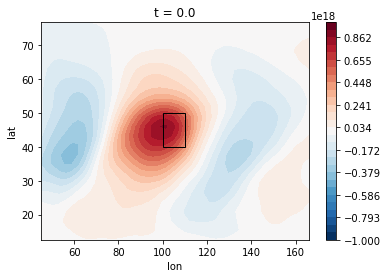

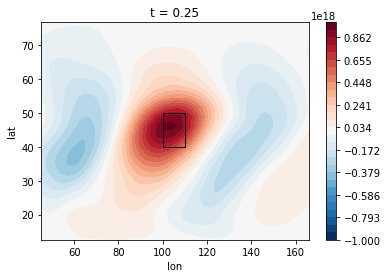

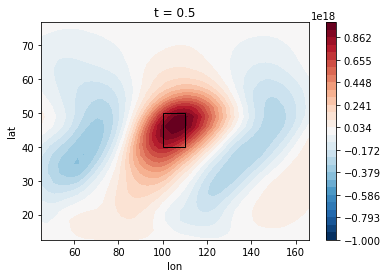

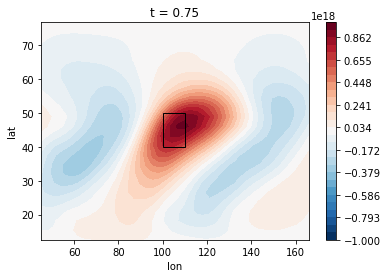

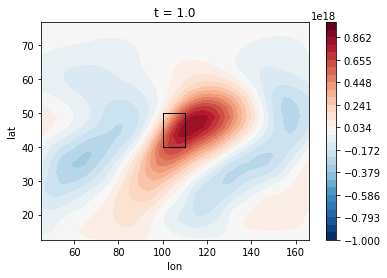

In [24]:
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/dse3d_Ldurk', 'rb') as f:
    dse_anom=pickle.load(f)[0]
    
lat1=4
lat2=28
lon1=16
lon2=60

import os
os.chdir('/home/scratch/Abel_data/long_run2')  
common=xr.open_zarr("common",consolidated=False)

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

t_std=np.array([0,0.25,0.5,0.75,1])
def intercomp(X, t):
    
    h,lt,ln=np.shape(X)
    out=np.zeros((len(t_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(t[:], X[:,i,j])
            out[:,i,j]=f(t_std)
            
    return out

int_list=[]
dur_list=[]
dse_list=[]

for i in range(len(dse_anom)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    
    d=dse_anom[i]
    d_arr=[]
    for e in d:
        d_arr.append(e[:6,:,:].sum(axis=0))
        
    d_arr=np.array(d_arr)
#     d_arr=((d_arr[1:]+d_arr[:-1])/2)
    d_arr=intercomp(d_arr, np.linspace(0,1,len(d_arr)))
    dse_list.append(d_arr)
    
cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

dur_sel=[]
int_sel=[]
dse_sel=[]

for i in range(len(dse_list)):
    if (dur_list[i]>=cut[0]  and dur_list[i]<=cut[5]):
        dur_sel.append(dur_list[i])
        int_sel.append(int_list[i])
        dse_sel.append(dse_list[i])

print(len(dse_sel))
dse_comp=np.array(dse_sel).mean(axis=0)
dse_comp=xr.DataArray(data=dse_comp, dims=["t","lat", "lon"])
dse_comp=dse_comp.assign_coords(t=t_std,lat=lat_deg[:,0],lon=lon_deg[0,:])

import matplotlib.patches as patches

lim=1e18
for i in range(5):
#     print(dse_comp[i].values[:].sum())
    dse_comp[i,:,:].plot.contourf(cmap='RdBu_r',levels=30, vmin=-lim,vmax=lim)
    ax = plt.gca()
    rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.show()

143


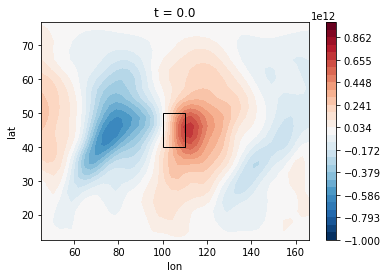

In [29]:
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/dse3d_Ldurk', 'rb') as f:
    dse_anom=pickle.load(f)[1]
        
lat1=4
lat2=28
lon1=16
lon2=60

import os
os.chdir('/home/scratch/Abel_data/long_run2')  
common=xr.open_zarr("common",consolidated=False)

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

t_std=np.array([0,0.25,0.5,0.75,1])
def intercomp(X, t):
    
    h,lt,ln=np.shape(X)
    out=np.zeros((len(t_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(t[:], X[:,i,j])
            out[:,i,j]=f(t_std)
            
    return out

int_list=[]
dur_list=[]
dse_list=[]

for i in range(len(dse_anom)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    
    d=dse_anom[i]
    d_arr=[]
    for e in d:
        d_arr.append(e[:6,:,:].sum(axis=0))
        
    d_arr=np.array(d_arr)
#     d_arr=((d_arr[1:]+d_arr[:-1])/2)
    d_arr=intercomp(d_arr, np.linspace(0,1,len(d_arr)))
    dse_list.append(d_arr)
    
cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

dur_sel=[]
int_sel=[]
dse_sel=[]

for i in range(len(dse_list)):
    if (dur_list[i]>=cut[0]  and dur_list[i]<=cut[5]):
        dur_sel.append(dur_list[i])
        int_sel.append(int_list[i])
        dse_sel.append(dse_list[i])

print(len(dse_sel))
dse_comp=np.array(dse_sel).mean(axis=0)
dse_comp=xr.DataArray(data=dse_comp, dims=["t","lat", "lon"])
dse_comp=-dse_comp.assign_coords(t=t_std,lat=lat_deg[:,0],lon=lon_deg[0,:])

import matplotlib.patches as patches
lim=1e12
for i in range(5):
#     print(dse_comp[i].values[:].sum())
    dse_comp[i].plot.contourf(cmap='RdBu_r',levels=30, vmin=-lim, vmax=lim)
    ax = plt.gca()
    rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [30]:
lat1=14
lat2=18
lon1=36
lon2=40

import os
os.chdir('/home/scratch/Abel_data/long_run2')  
common=xr.open_zarr("common",consolidated=False)

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

with gzip.open('/home/scratch/Abel_data/advection_meank', 'rb') as f:
    DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean= pickle.load(f)

windx=(windxmean[:7,:,:].mean(axis=0))
windx=xr.DataArray(data=windx, dims=["lat", "lon"])
windx=windx.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])

windx.plot.contourf(cmap='Blues')

In [3]:
####################################### heatwave identify modified ###############################
%matplotlib notebook

lat1=14
lat2=18
lon1=36
lon2=40

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

with gzip.open('A_comb', 'rb') as f:
    temp=pickle.load(f)[:]

obs70=np.quantile(temp,0.95)
obs95=np.quantile(temp,0.95)
mean=np.mean(temp)
print(mean)
print(obs95-mean)
print(obs70,obs95)

heat_count=0
heat_index=[]

for i in range(1,51):
        
    with gzip.open('A'+str(i), 'rb') as f:
        obs=pickle.load(f)[:]

    l=0
    ind_curr=[]
    int_heat=[]

    for k in range(365*72*20):

        if obs[k]>obs70:
            ind_curr.append(k)
            int_heat.append(obs[k])
            if obs[k]>obs95:
                l=l+1
            else:
                if l<=3*72:
                    l=0

        else:
            if l>3*72:
                ind_curr.append(k)
                int_heat.append(obs[k])
                
                yr1=np.floor(ind_curr[0]/(72*365))
                yr2=np.floor(ind_curr[-1]/(72*365))
                if yr1==yr2:
                    ind=np.array(ind_curr)-yr1*72*365
                    st=np.floor(ind[0]/72)-1; end=np.ceil(ind[-1]/72)+1
                    if end<366 and st>=0:
                        fr=np.ceil(ind[0]/72)-(ind[0]/72); bk=(ind[-1]/72)-np.floor(ind[-1]/72)
                        ind=np.arange(int(st),int(end))
                        heat_index.append([i,yr1+1,ind,np.mean(int_heat)-obs70,len(ind_curr)/72,np.max(int_heat)-obs70,int_heat,fr,bk])
            
            l=0
            ind_curr=[]
            int_heat=[]

print(len(heat_index))

with gzip.open('/home/scratch/Abel_data/heat_indexmodk', 'wb') as f:
    pickle.dump(heat_index, f)

# plt.contourf(common['longitude'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)),
#              common['latitude'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)),
#              temp_field[273]-mean)
# plt.colorbar()

288.7833717285834
5.4746967086784935
294.2580684372619 294.2580684372619
1398


In [2]:
########################################### animation ###########################################################

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

writer = animation.writers['ffmpeg']
writer = writer(fps=1, bitrate=900)

# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexmodk', 'rb') as f:
    heat_index= pickle.load(f)

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=3
lat2=29
lon1=15
lon2=61

# lat1=13
# lat2=19
# lon1=35
# lon2=41

lat1s=13
lat2s=19
lon1s=35
lon2s=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.7 ,0.2)[::-1]*10000
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

temp_clim=interpol1d(temp_clim, press_clim)
press_int=np.insert(p_std, 0, 101300)      
dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse_clim=Cp*temp_clim+g*z

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

cut=np.sort(int_list)[-5]
print(cut)

convergencehx=[]
convergencehy=[]
convergencev=[]
CONVhx=[]
CONVhy=[]
CONVv=[]

test=0

for e in heat_index:
    
    if (int_list[test]>=cut):
    
#     #     if test==10:
#     #         break

#         test=test+1

        print(test)

        i=e[0]
        j=int(e[1])
    #     print(i,j)
        t_list=e[2]
        ignore=0

        for t in t_list:

    #         t=t_0+k
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            
            if np.min(press.values[0])<95000:
                ignore=1
                print(np.min(press.values[0]))
                continue

            temp=interpol1d(temp, press)

            press_int=np.insert(p_std, 0, 101300)       

            # dz calculation

            dp=(press_int[:-1]-press_int[1:])

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)

            dse=(Cp*temp+g*z-dse_clim)
            dse=((dse)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

            DSE=-(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
            
            print(dse[:6,1:-1,1:-1].sum())
            convergencehy.append(dse[:33,1:-1,1:-1])
            convergencehx.append(DSE[:33])

        if ignore==0:
    
            fig, axs = plt.subplots(1, 2, figsize=(18, 6),dpi=150, facecolor='white', gridspec_kw={'width_ratios': [1.5, 1]})
            bar_flag=0
            lim1=1.4e18
            lim2=2e12
#             lim=1e12
            def animate(i):

                rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')

                axs[0].clear()
                cs = axs[0].contourf(lon_deg[0,1:-1], lat_deg[1:-1,0],
                convergencehy[i][:6].sum(axis=0), levels=30, cmap='RdBu_r', robust=True, vmin=-lim1, vmax=lim1)
                global bar_flag
                if bar_flag==0:
                    fig.colorbar(cs, ax=axs[0])
                    bar_flag=1

                axs[0].set_xlabel('Lon')
                axs[0].set_ylabel('Lat')    
#                 axs[0].set_title('Day '+str(i-1))
#                 axs.axhline(20, linestyle='dashed',linewidth=0.7,color='black')
#                 axs.axhline(60, linestyle='dashed',linewidth=0.7,color='black')
                axs[0].add_patch(rect)
                
                axs[1].clear()
                lat_st=lat1s-lat1;lon_st=lon1s-lon1
                dse_grad= np.average(convergencehx[i][:6,lat_st:lat_st+4,lon_st:lon_st+4].sum(axis=0),
                                     weights=np.cos(lat_rad)[lat_st:lat_st+4, 0], axis=0)
                axs[1].plot(lon_deg[0,1+lon_st:lon_st+5], dse_grad)

                axs[1].set_xlabel('Lon')
                axs[1].set_ylabel('Average -d/dx(DSE)')
                axs[1].set_ylim((-lim2,lim2))
                
                fig.suptitle('Day '+str(i-1))

                fig.tight_layout()

            ani = animation.FuncAnimation(fig, animate, len(convergencehy), blit=False)

            ani.save('/home/data/lab_abel/Paper1/intense'+str(test)+'.gif', writer=writer, dpi=150)
            
        
        convergencehx=[]
        convergencehy=[]
    test=test+1

# with gzip.open('/home/scratch/Abel_data/dse3d_Lintk', 'wb') as f:
#     pickle.dump([CONVhy, CONVhx], f)

3.0235889268113283
191
-1.2852703265832649e+20
-1.3657411834485349e+20
-1.2693514090999379e+20
-1.1189070993642966e+20
-9.46352351357948e+19
-6.938428721861797e+19
603
1.560593352538414e+20
1.4057081358440545e+20
9.247820186590632e+19
4.100573685622978e+19
5.513096354088337e+18
-1.6439621136934828e+19
-4.972405888884872e+19
940
2.5846059114553303e+19
1.1363647476180914e+19
-8.793827533556251e+18
-2.635052363031488e+19
-2.344253463682873e+19
-1.338084498537626e+19
-2.5018290268456067e+19
1186
-6.333230295037741e+18
-2.399305360986711e+19
-1.951097168308493e+19
2.5786025051574753e+18
1.1041679439523043e+19
9.199217293887054e+18
2.4958777746577193e+18
1323
-2.4668787105745453e+19
3.3842265235197983e+18
2.98835784806902e+19
4.463906243648971e+19
5.069743302093145e+19
4.7274636242166415e+19
94402.914


0.26151895821260496
118
3.4705567078246818e+19
6.981732393108956e+19
9.27871554552384e+19
6.868165050858244e+19
3.70627763838669e+19
1.6914157892981518e+19
6.359000178643133e+18
276
-1.3485684173157355e+20
-1.4974249722542906e+20
-1.477584455436751e+20
-1.2278393480976525e+20
-9.122521140760946e+19
-7.389217489056065e+19
286
-1.2823262098534321e+20
-1.7382721123833194e+20
-1.7948652272619255e+20
-1.7034848063149375e+20
-1.641321277393172e+20
-1.5073229511158156e+20
-1.3443141243066358e+20
511
7.52410082916218e+19
5.433206824230882e+19
3.569435297216968e+19
4.05837055601252e+19
4.077334474722496e+19
3.716592026029605e+19
2.7409545615209128e+19
2.7298721732061897e+19
793
2.695425566297418e+19
6.383254647452304e+19
8.620014951744786e+19
9.256723900417858e+19
1.0648318216171528e+20
1.1596345930073702e+20


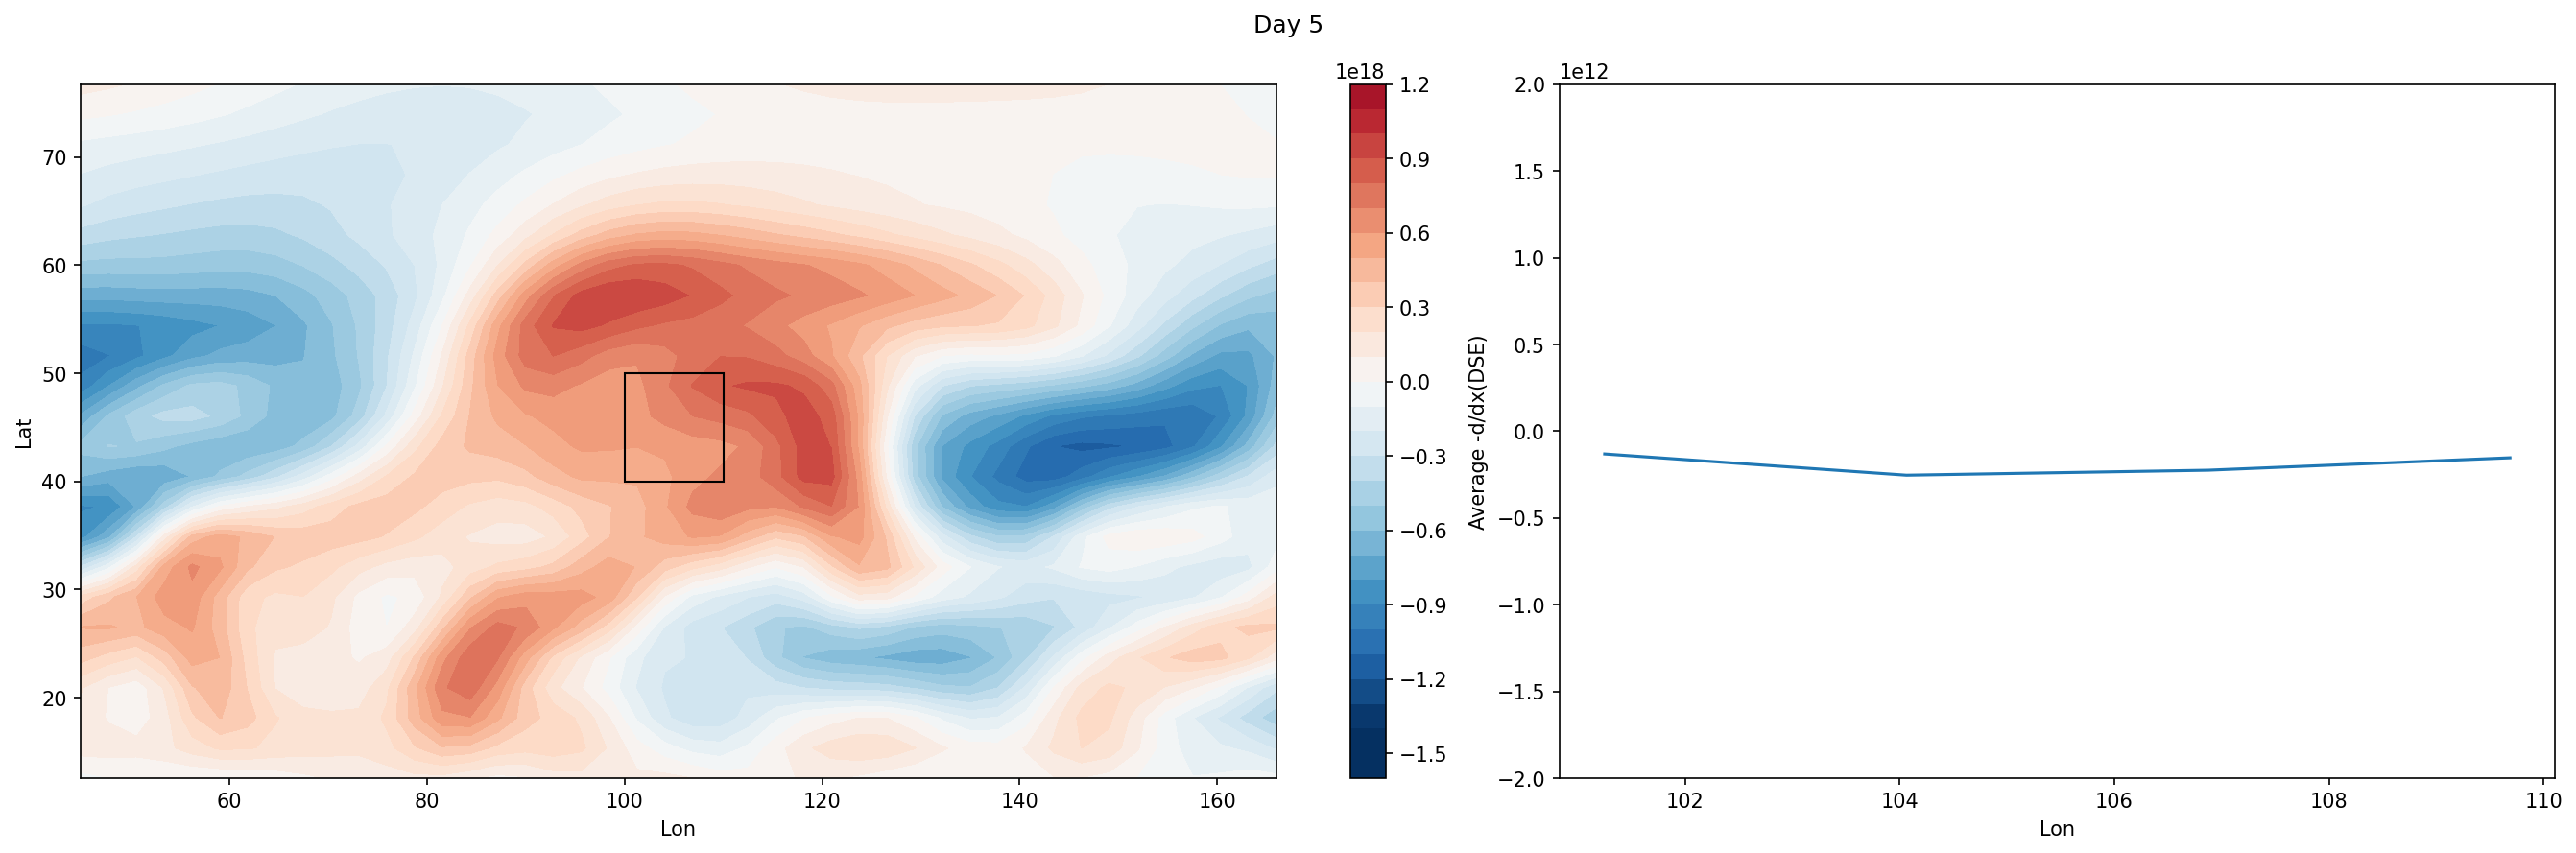

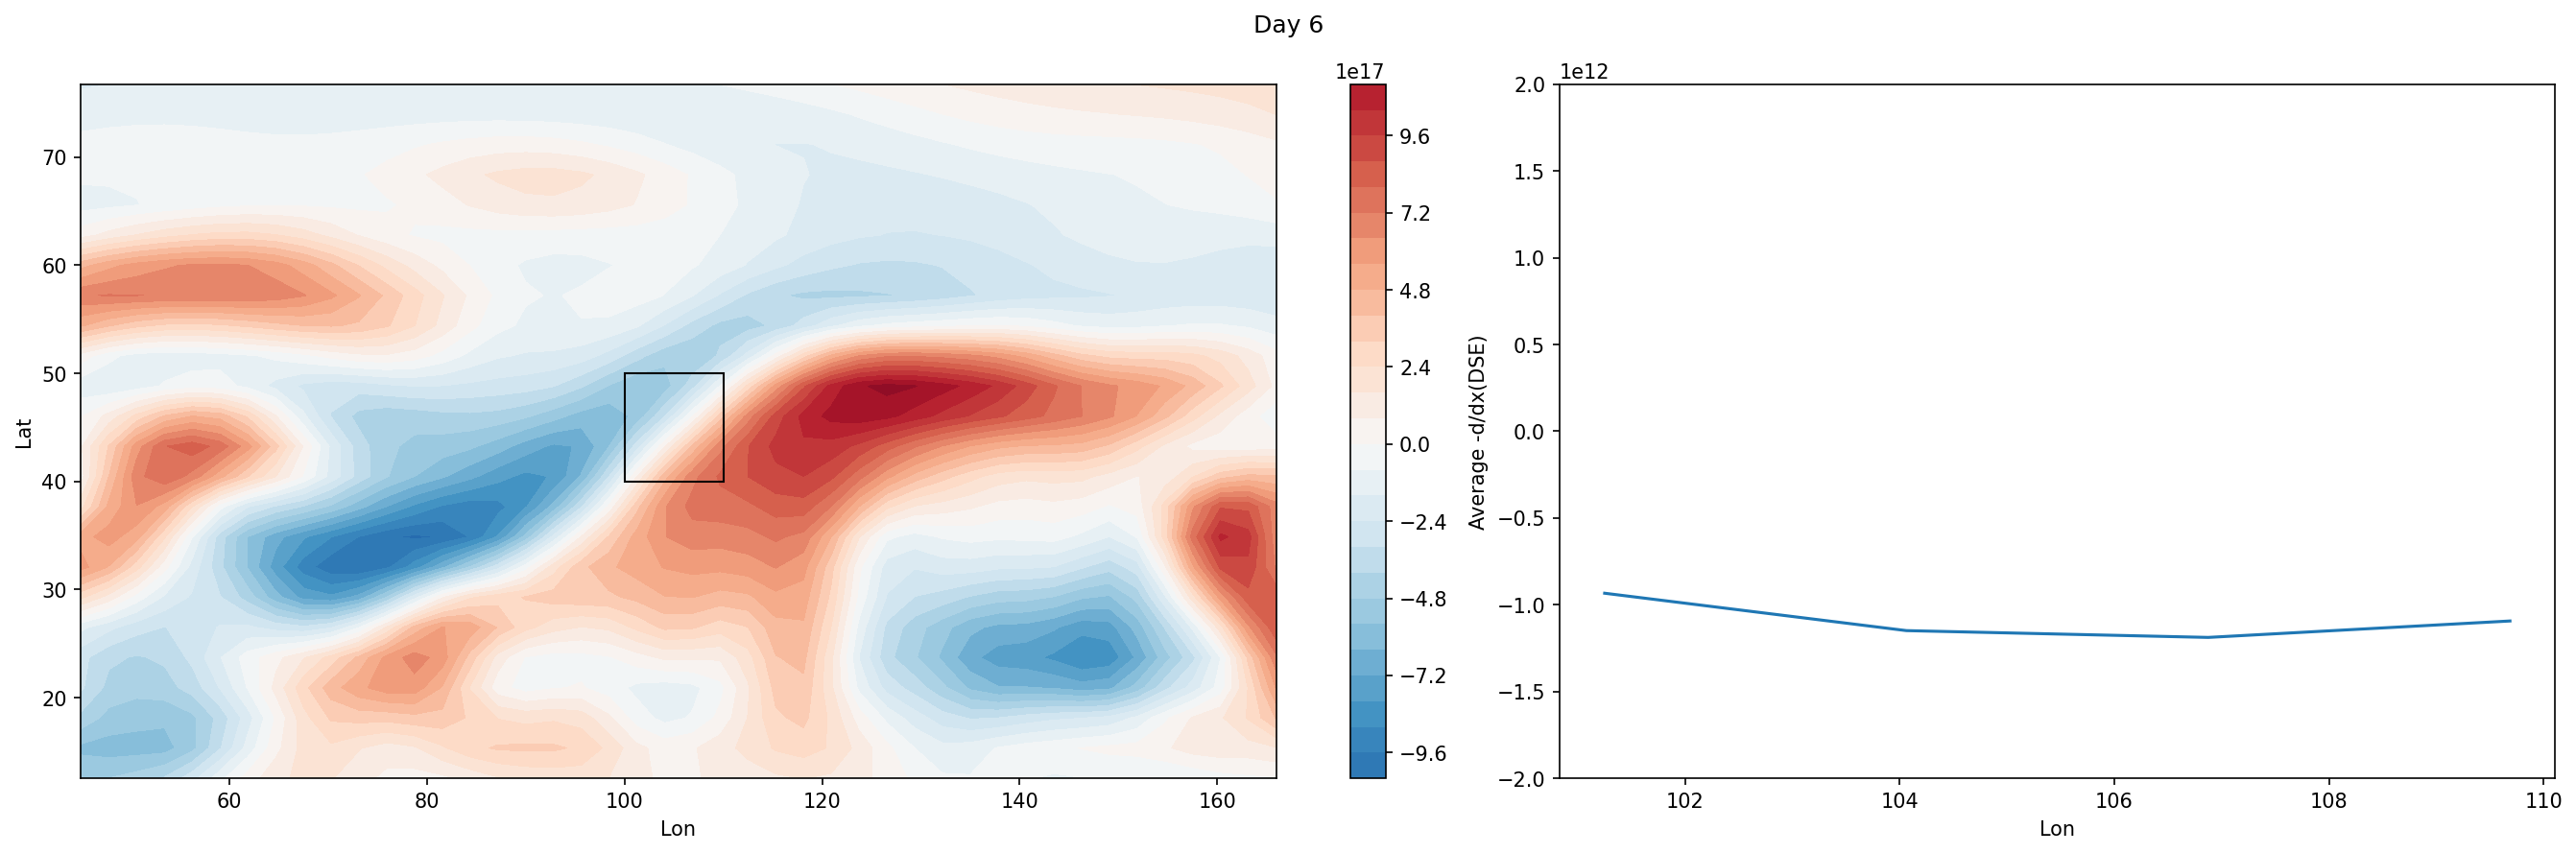

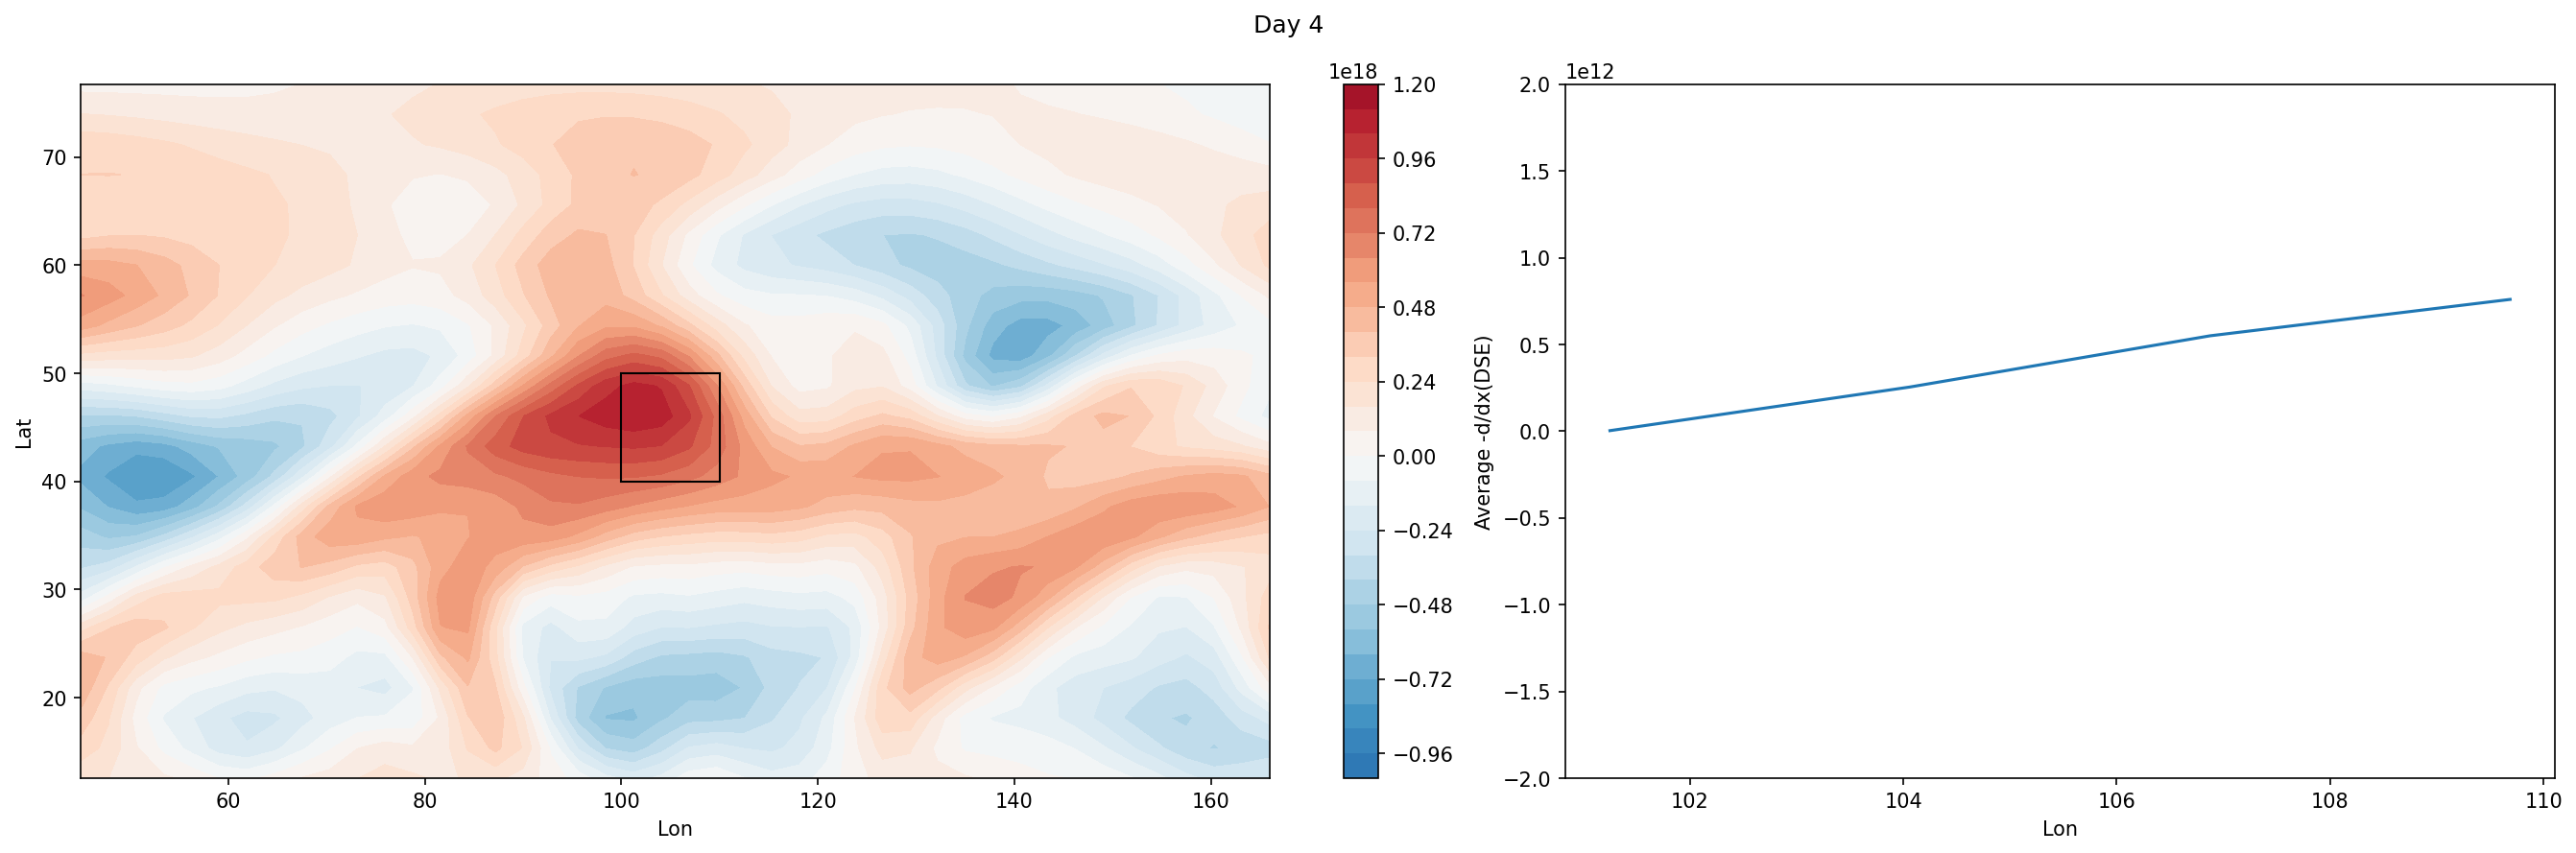

In [3]:
########################################### animation ###########################################################

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

writer = animation.writers['ffmpeg']
writer = writer(fps=1, bitrate=900)

# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexmodk', 'rb') as f:
    heat_index= pickle.load(f)

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=3
lat2=29
lon1=15
lon2=61

# lat1=13
# lat2=19
# lon1=35
# lon2=41

lat1s=13
lat2s=19
lon1s=35
lon2s=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.7 ,0.2)[::-1]*10000
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

temp_clim=interpol1d(temp_clim, press_clim)
press_int=np.insert(p_std, 0, 101300)      
dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse_clim=Cp*temp_clim+g*z

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

cut=np.sort(int_list)[4]
print(cut)

convergencehx=[]
convergencehy=[]
convergencev=[]
CONVhx=[]
CONVhy=[]
CONVv=[]

test=0

for e in heat_index:
    
    if (int_list[test]<=cut):
    
#     #     if test==10:
#     #         break

#         test=test+1

        print(test)

        i=e[0]
        j=int(e[1])
    #     print(i,j)
        t_list=e[2]
        ignore=0

        for t in t_list:

    #         t=t_0+k
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            
            if np.min(press.values[0])<95000:
                ignore=1
                print(np.min(press.values[0]))
                continue

            temp=interpol1d(temp, press)

            press_int=np.insert(p_std, 0, 101300)       

            # dz calculation

            dp=(press_int[:-1]-press_int[1:])

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)

            dse=(Cp*temp+g*z-dse_clim)
            dse=((dse)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

            DSE=-(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
            
            print(dse[:6,1:-1,1:-1].sum())
            convergencehy.append(dse[:33,1:-1,1:-1])
            convergencehx.append(DSE[:33])

        if ignore==0:
    
            fig, axs = plt.subplots(1, 2, figsize=(18, 6),dpi=150, facecolor='white', gridspec_kw={'width_ratios': [1.5, 1]})
            bar_flag=0
            lim1=1.4e18
            lim2=2e12
#             lim=1e12
            def animate(i):

                rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')

                axs[0].clear()
                cs = axs[0].contourf(lon_deg[0,1:-1], lat_deg[1:-1,0],
                convergencehy[i][:6].sum(axis=0), levels=30, cmap='RdBu_r', robust=True, vmin=-lim1, vmax=lim1)
                global bar_flag
                if bar_flag==0:
                    fig.colorbar(cs, ax=axs[0])
                    bar_flag=1

                axs[0].set_xlabel('Lon')
                axs[0].set_ylabel('Lat')    
#                 axs[0].set_title('Day '+str(i-1))
#                 axs.axhline(20, linestyle='dashed',linewidth=0.7,color='black')
#                 axs.axhline(60, linestyle='dashed',linewidth=0.7,color='black')
                axs[0].add_patch(rect)
                
                axs[1].clear()
                lat_st=lat1s-lat1;lon_st=lon1s-lon1
                dse_grad= np.average(convergencehx[i][:6,lat_st:lat_st+4,lon_st:lon_st+4].sum(axis=0),
                                     weights=np.cos(lat_rad)[lat_st:lat_st+4, 0], axis=0)
                axs[1].plot(lon_deg[0,1+lon_st:lon_st+5], dse_grad)

                axs[1].set_xlabel('Lon')
                axs[1].set_ylabel('Average -d/dx(DSE)')
                axs[1].set_ylim((-lim2,lim2))
                
                fig.suptitle('Day '+str(i-1))

                fig.tight_layout()

            ani = animation.FuncAnimation(fig, animate, len(convergencehy), blit=False)

            ani.save('/home/data/lab_abel/Paper1/weak'+str(test)+'.gif', writer=writer, dpi=150)
            
        
        convergencehx=[]
        convergencehy=[]
    test=test+1

# with gzip.open('/home/scratch/Abel_data/dse3d_Lintk', 'wb') as f:
#     pickle.dump([CONVhy, CONVhx], f)

11.86111111111111
182
4.341435893717367e+19
5.122923063294874e+19
7.751146188238286e+19
1.2245946579230654e+20
94909.71
94802.3
1.7335148211695432e+20
1.4557563365855016e+20
1.0961454476186629e+20
1.1674134546026063e+20
1.3367696182011735e+20
1.339184022151502e+20
1.087516267852113e+20
8.331392611443157e+19
7.59829047393692e+19
7.677579416617622e+19
7.608157303577536e+19
6.566916901204656e+19
4.662830161495966e+19
2.057650822581848e+19
6.069967935483302e+18
7.994877994861369e+18
242
-6.131243872520049e+17
-6.275284587054655e+18
1.3551809791493198e+19
2.4509894829874938e+19
1.4285271138975506e+19
1.842760842808957e+19
3.0257631750737863e+19
5.552269586758155e+19
5.4053447517868474e+19
4.0312363159007355e+19
4.811391388069403e+19
3.551561165129016e+19
1.718213083750393e+19
1.2757477715043279e+19
1.228394533058374e+19
269
9.84199729690916e+18
5.24794556549994e+19
9.320930221068619e+19
8.421332219651765e+19
8.606933489712615e+19
7.855540974156995e+19
5.037089420355045e+19
5.699508499940098

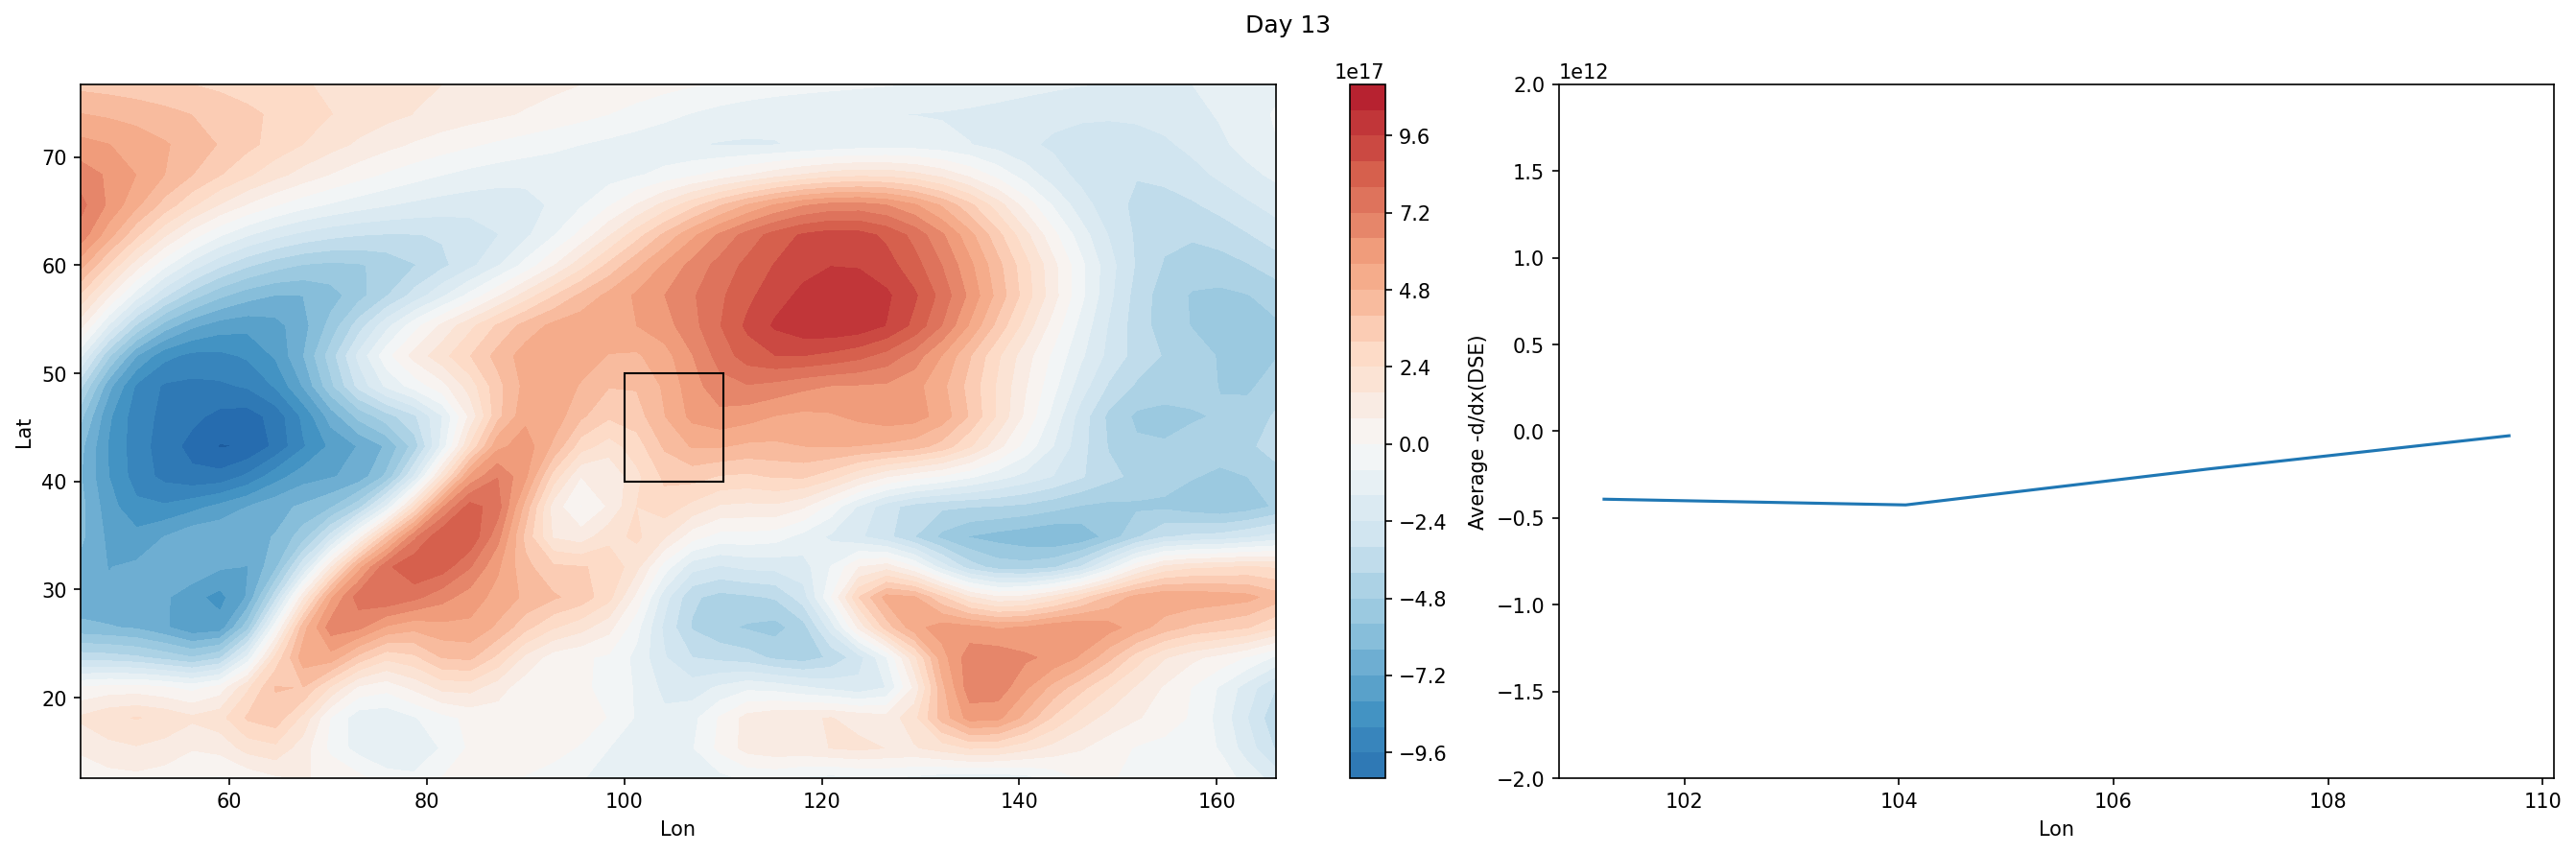

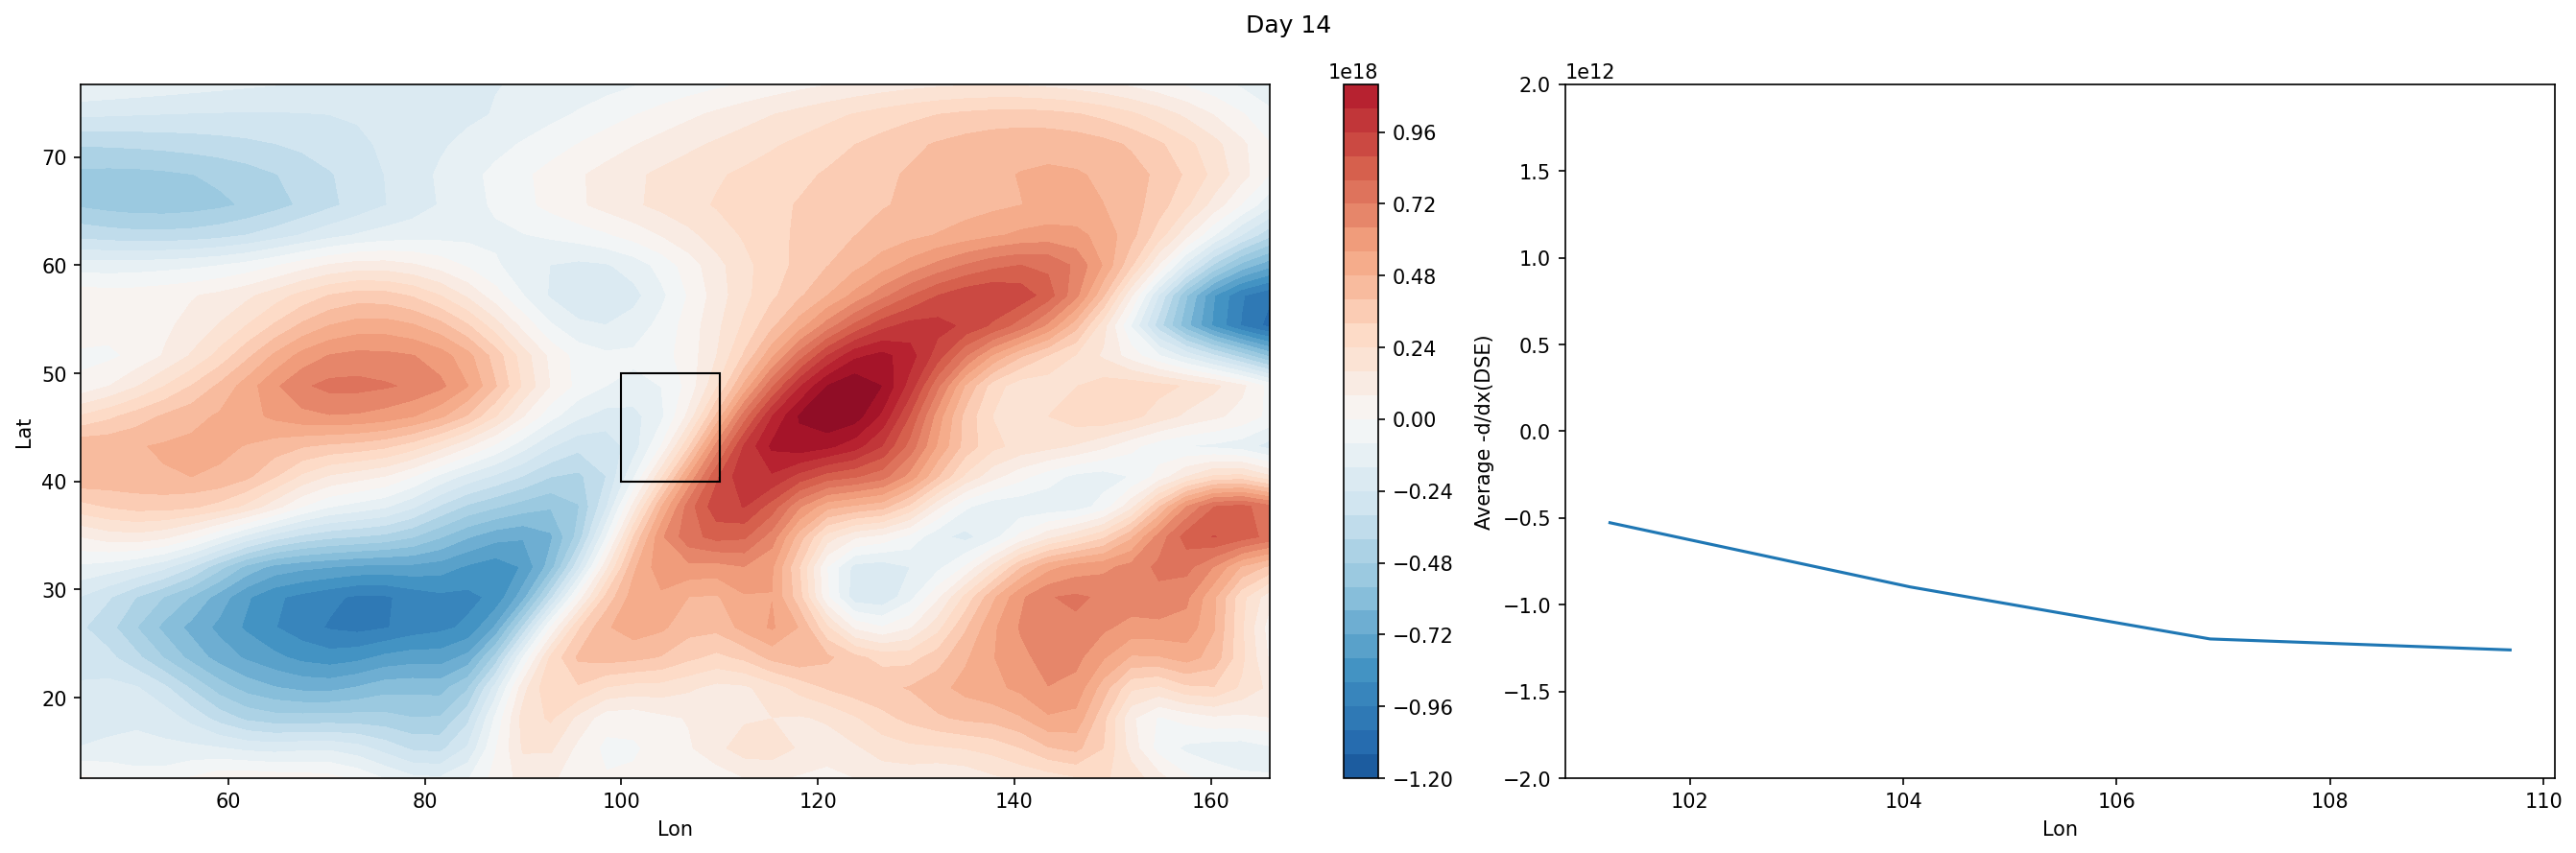

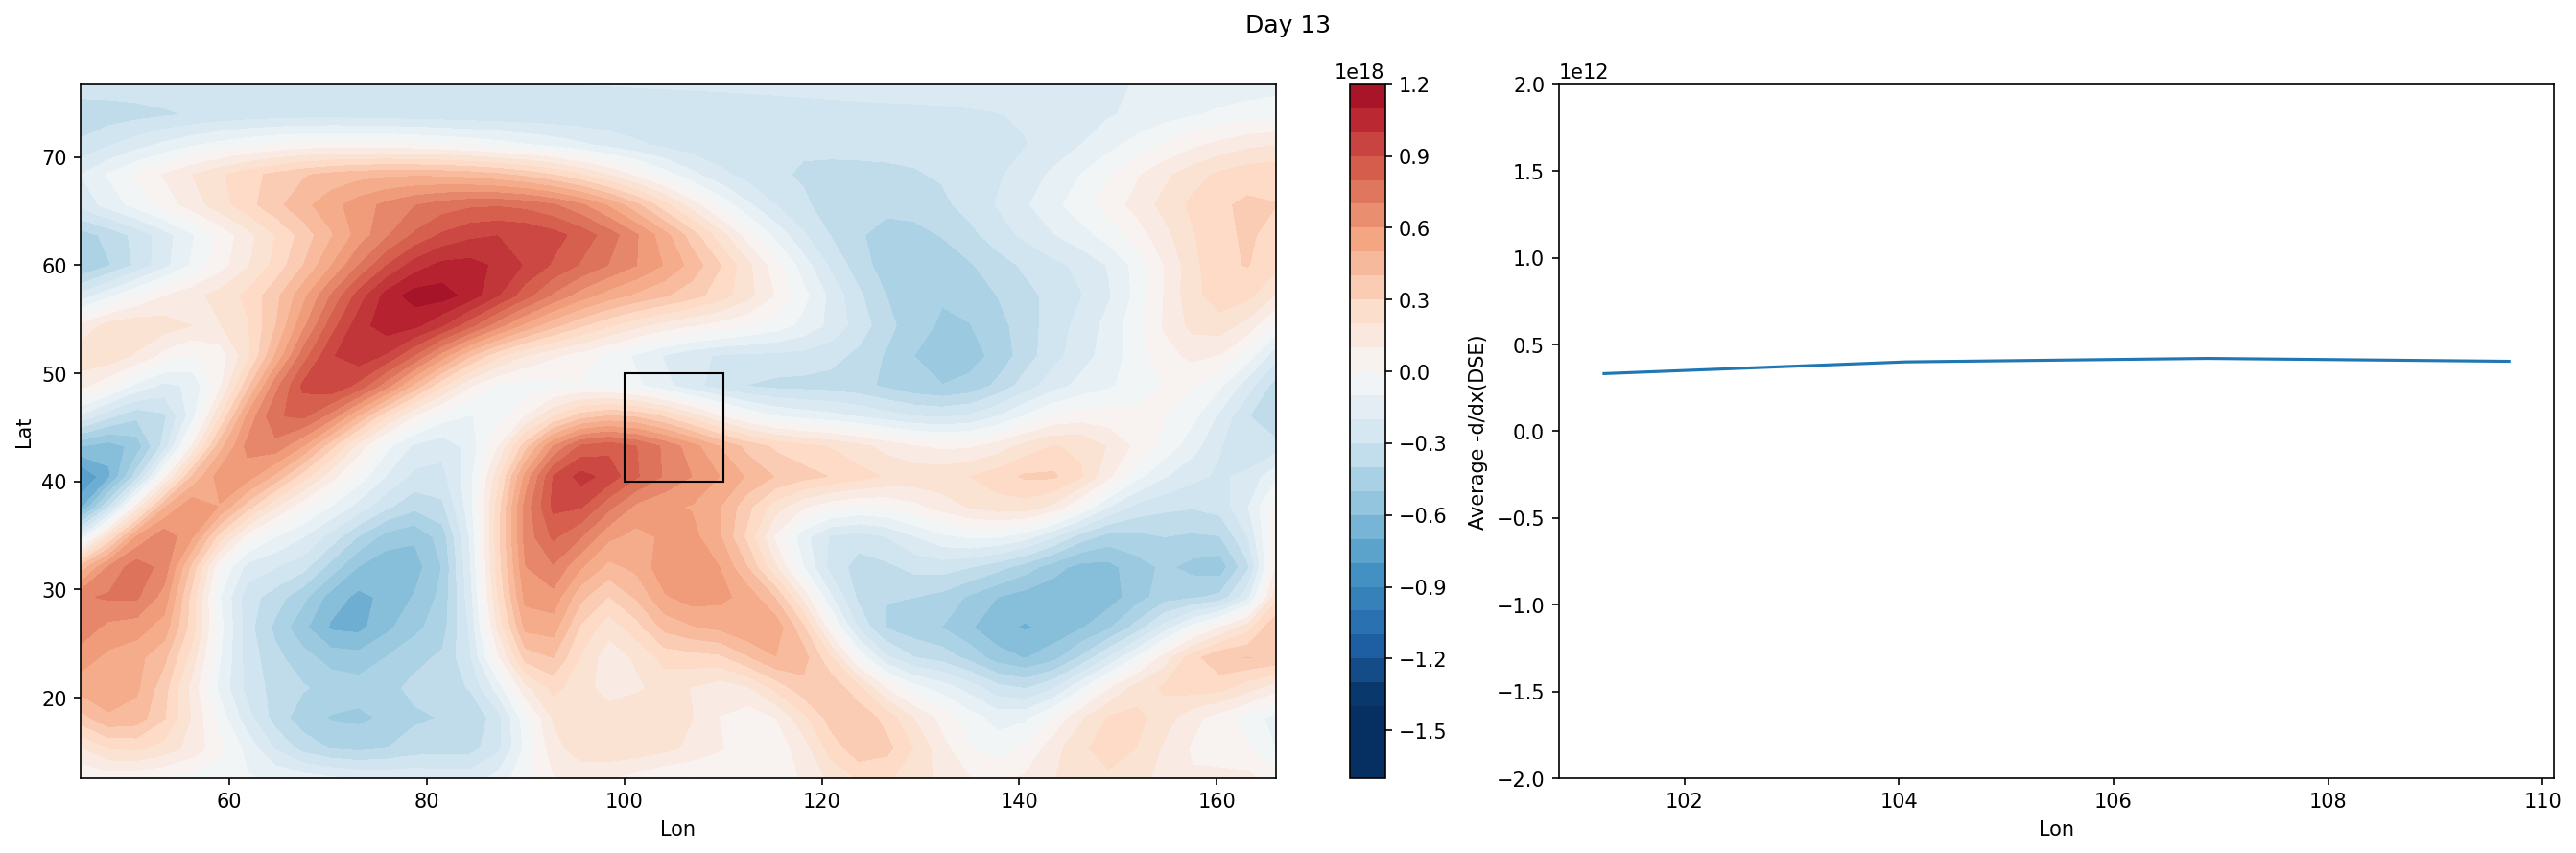

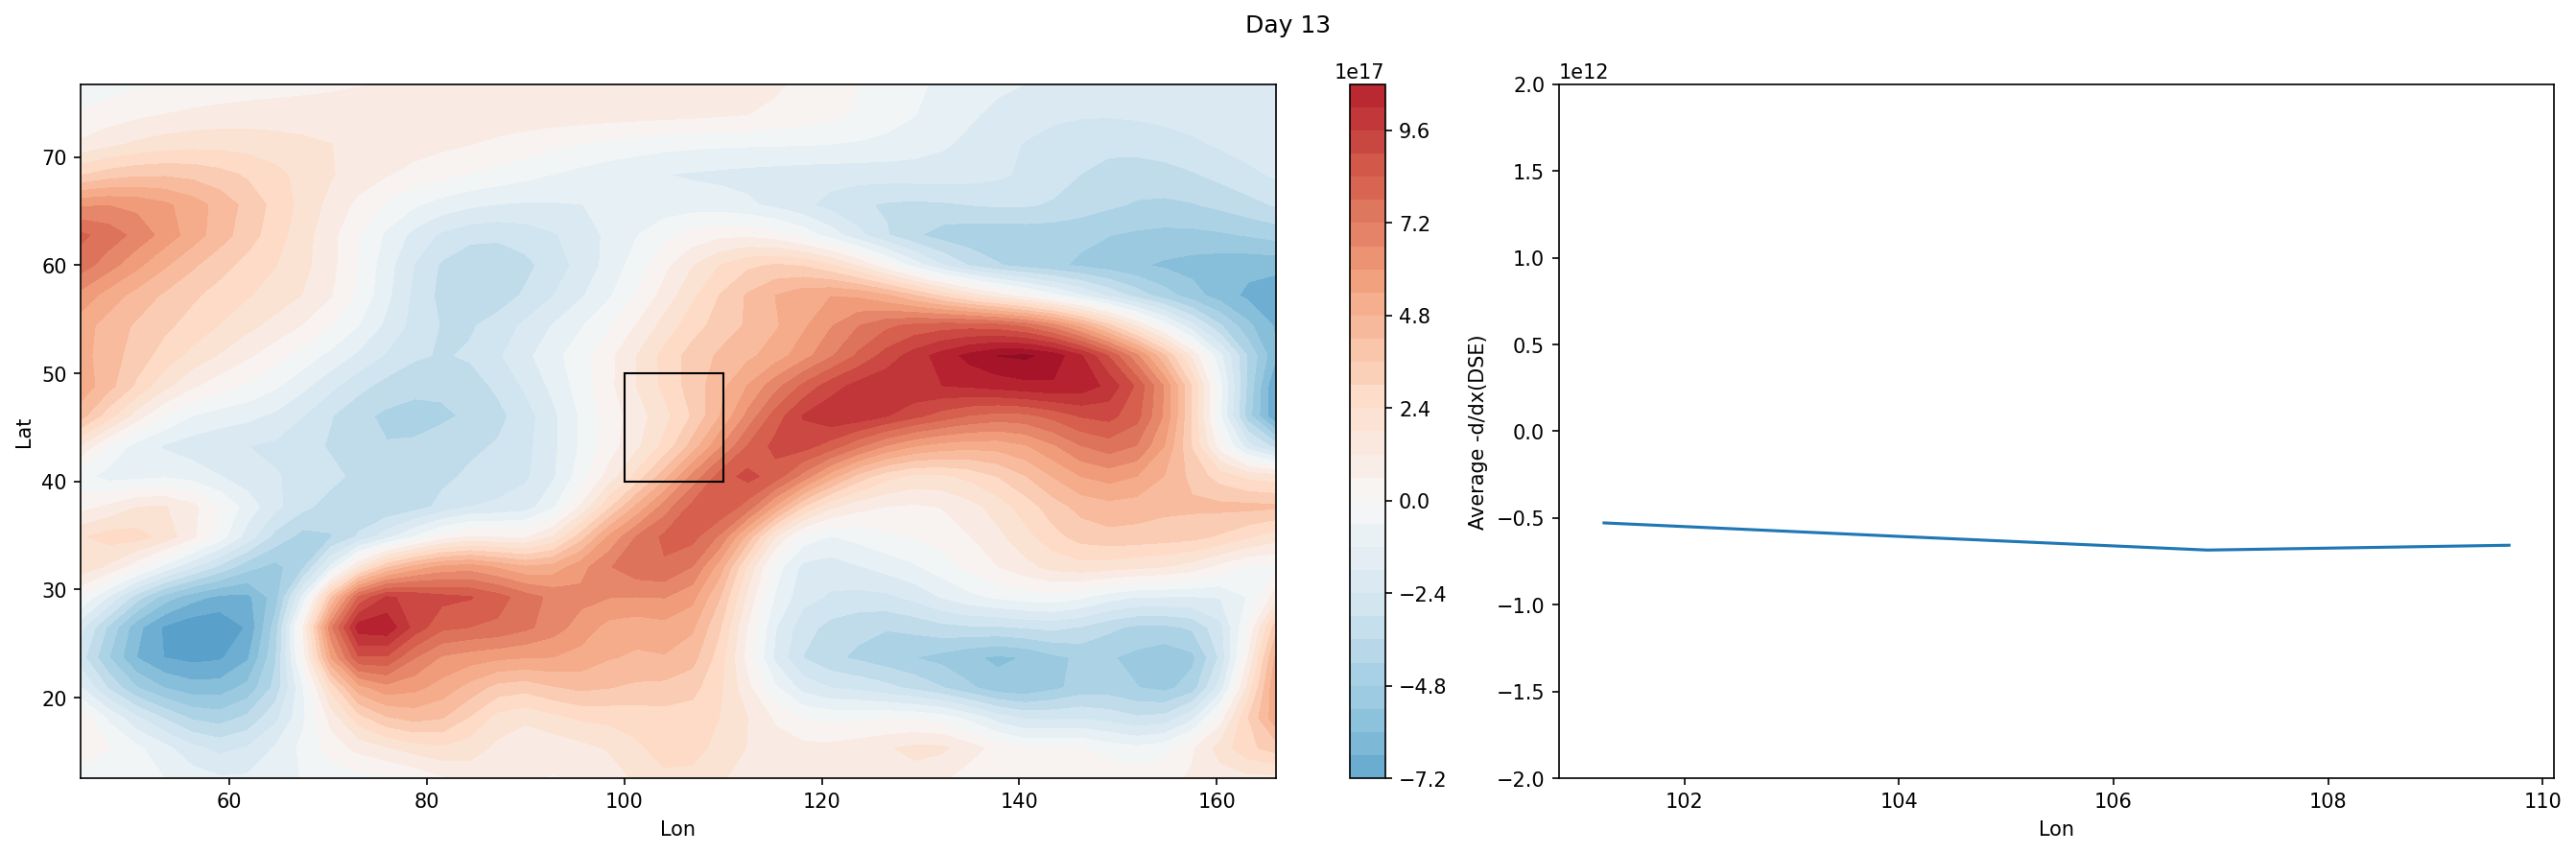

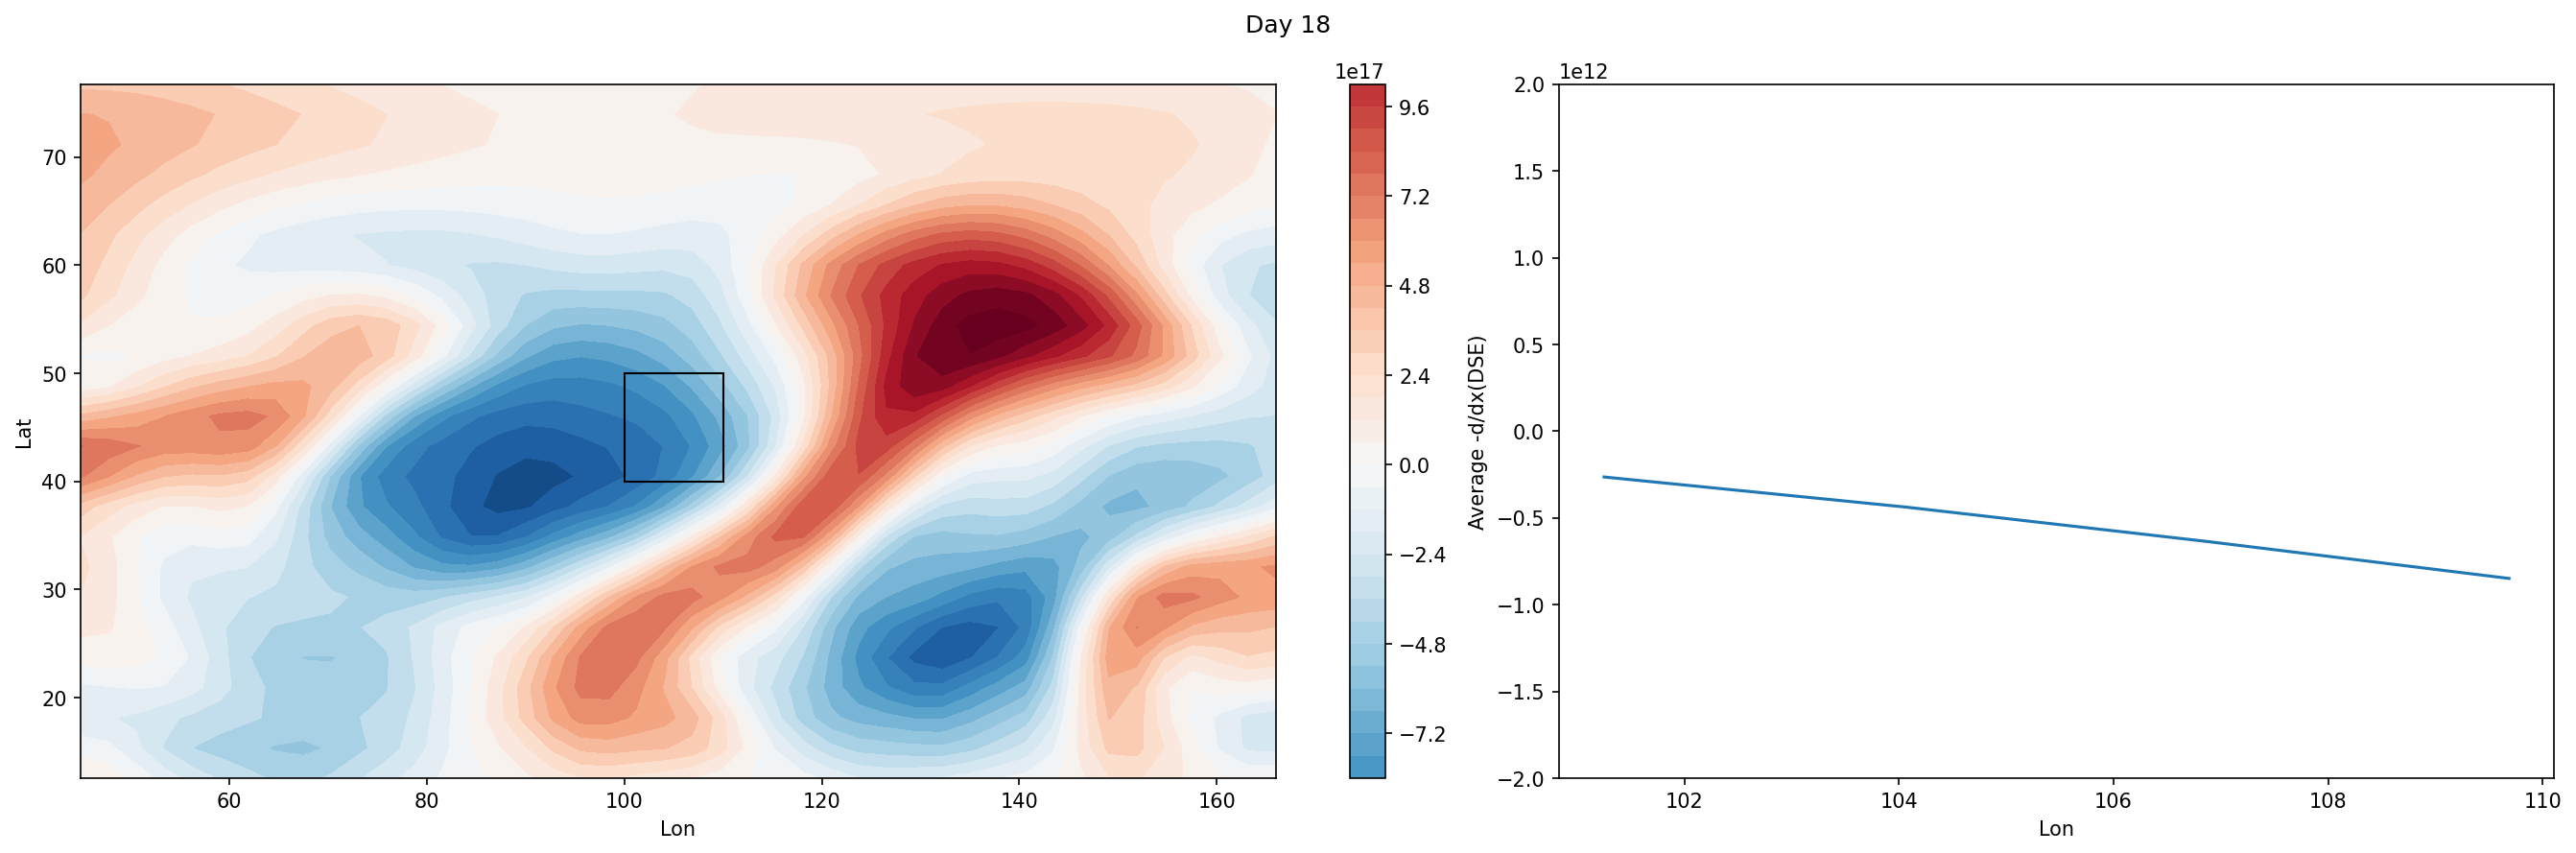

In [4]:
########################################### animation ###########################################################

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

writer = animation.writers['ffmpeg']
writer = writer(fps=1, bitrate=900)

# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexmodk', 'rb') as f:
    heat_index= pickle.load(f)

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=3
lat2=29
lon1=15
lon2=61

# lat1=13
# lat2=19
# lon1=35
# lon2=41

lat1s=13
lat2s=19
lon1s=35
lon2s=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.7 ,0.2)[::-1]*10000
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

temp_clim=interpol1d(temp_clim, press_clim)
press_int=np.insert(p_std, 0, 101300)      
dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse_clim=Cp*temp_clim+g*z

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

cut=np.sort(dur_list)[-5]
print(cut)

convergencehx=[]
convergencehy=[]
convergencev=[]
CONVhx=[]
CONVhy=[]
CONVv=[]

test=0

for e in heat_index:
    
    if (dur_list[test]>=cut):
    
#     #     if test==10:
#     #         break

#         test=test+1

        print(test)

        i=e[0]
        j=int(e[1])
    #     print(i,j)
        t_list=e[2]
        ignore=0

        for t in t_list:

    #         t=t_0+k
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            
            if np.min(press.values[0])<95000:
                ignore=1
                print(np.min(press.values[0]))
                continue

            temp=interpol1d(temp, press)

            press_int=np.insert(p_std, 0, 101300)       

            # dz calculation

            dp=(press_int[:-1]-press_int[1:])

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)

            dse=(Cp*temp+g*z-dse_clim)
            dse=((dse)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

            DSE=-(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
            
            print(dse[:6,1:-1,1:-1].sum())
            convergencehy.append(dse[:33,1:-1,1:-1])
            convergencehx.append(DSE[:33])

        if ignore==0:
    
            fig, axs = plt.subplots(1, 2, figsize=(18, 6),dpi=150, facecolor='white', gridspec_kw={'width_ratios': [1.5, 1]})
            bar_flag=0
            lim1=1.4e18
            lim2=2e12
#             lim=1e12
            def animate(i):

                rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')

                axs[0].clear()
                cs = axs[0].contourf(lon_deg[0,1:-1], lat_deg[1:-1,0],
                convergencehy[i][:6].sum(axis=0), levels=30, cmap='RdBu_r', robust=True, vmin=-lim1, vmax=lim1)
                global bar_flag
                if bar_flag==0:
                    fig.colorbar(cs, ax=axs[0])
                    bar_flag=1

                axs[0].set_xlabel('Lon')
                axs[0].set_ylabel('Lat')    
#                 axs[0].set_title('Day '+str(i-1))
#                 axs.axhline(20, linestyle='dashed',linewidth=0.7,color='black')
#                 axs.axhline(60, linestyle='dashed',linewidth=0.7,color='black')
                axs[0].add_patch(rect)
                
                axs[1].clear()
                lat_st=lat1s-lat1;lon_st=lon1s-lon1
                dse_grad= np.average(convergencehx[i][:6,lat_st:lat_st+4,lon_st:lon_st+4].sum(axis=0),
                                     weights=np.cos(lat_rad)[lat_st:lat_st+4, 0], axis=0)
                axs[1].plot(lon_deg[0,1+lon_st:lon_st+5], dse_grad)

                axs[1].set_xlabel('Lon')
                axs[1].set_ylabel('Average -d/dx(DSE)')
                axs[1].set_ylim((-lim2,lim2))
                
                fig.suptitle('Day '+str(i-1))

                fig.tight_layout()

            ani = animation.FuncAnimation(fig, animate, len(convergencehy), blit=False)

            ani.save('/home/data/lab_abel/Paper1/long'+str(test)+'.gif', writer=writer, dpi=150)
            
        
        convergencehx=[]
        convergencehy=[]
    test=test+1

# with gzip.open('/home/scratch/Abel_data/dse3d_Lintk', 'wb') as f:
#     pickle.dump([CONVhy, CONVhx], f)

3.0277777777777777
185
4.688728888497617e+19
4.492827101935597e+19
4.135347990518093e+19
2.304117085351405e+19
3.088556186942237e+19
1.6228530787454876e+19
275
8.905014093619947e+19
7.957294800179084e+19
6.175070079779822e+19
4.3444594588125364e+19
2.2654215808568218e+19
1.9765611436687245e+19
287
1.1357563045272573e+20
1.2732288636615184e+20
1.1557721391017915e+20
9.154428156961235e+19
6.267750381754564e+19
5.077288357613335e+19
335
-2.3275302225336205e+19
-3.965865057351434e+19
-6.00989644362598e+19
-5.497179951240289e+19
-4.71629182068172e+19
-3.977662118067667e+19
360
1.9787331785210253e+19
6.416609056931367e+18
5.335690513036165e+18
1.4323053203699225e+19
1.5032060588175942e+19
1.1442624572010537e+19
512
4.933409562335668e+19
4.726045316451762e+19
4.740370338030055e+19
6.40888785385586e+19
5.878529487679762e+19
2.928791573985509e+19
545
1.3511161122526021e+20
1.1595756754413281e+20
1.1532017774682831e+20
9.565496637736098e+19
6.090913187874635e+19
5.346470125041757e+19
558
9.78865

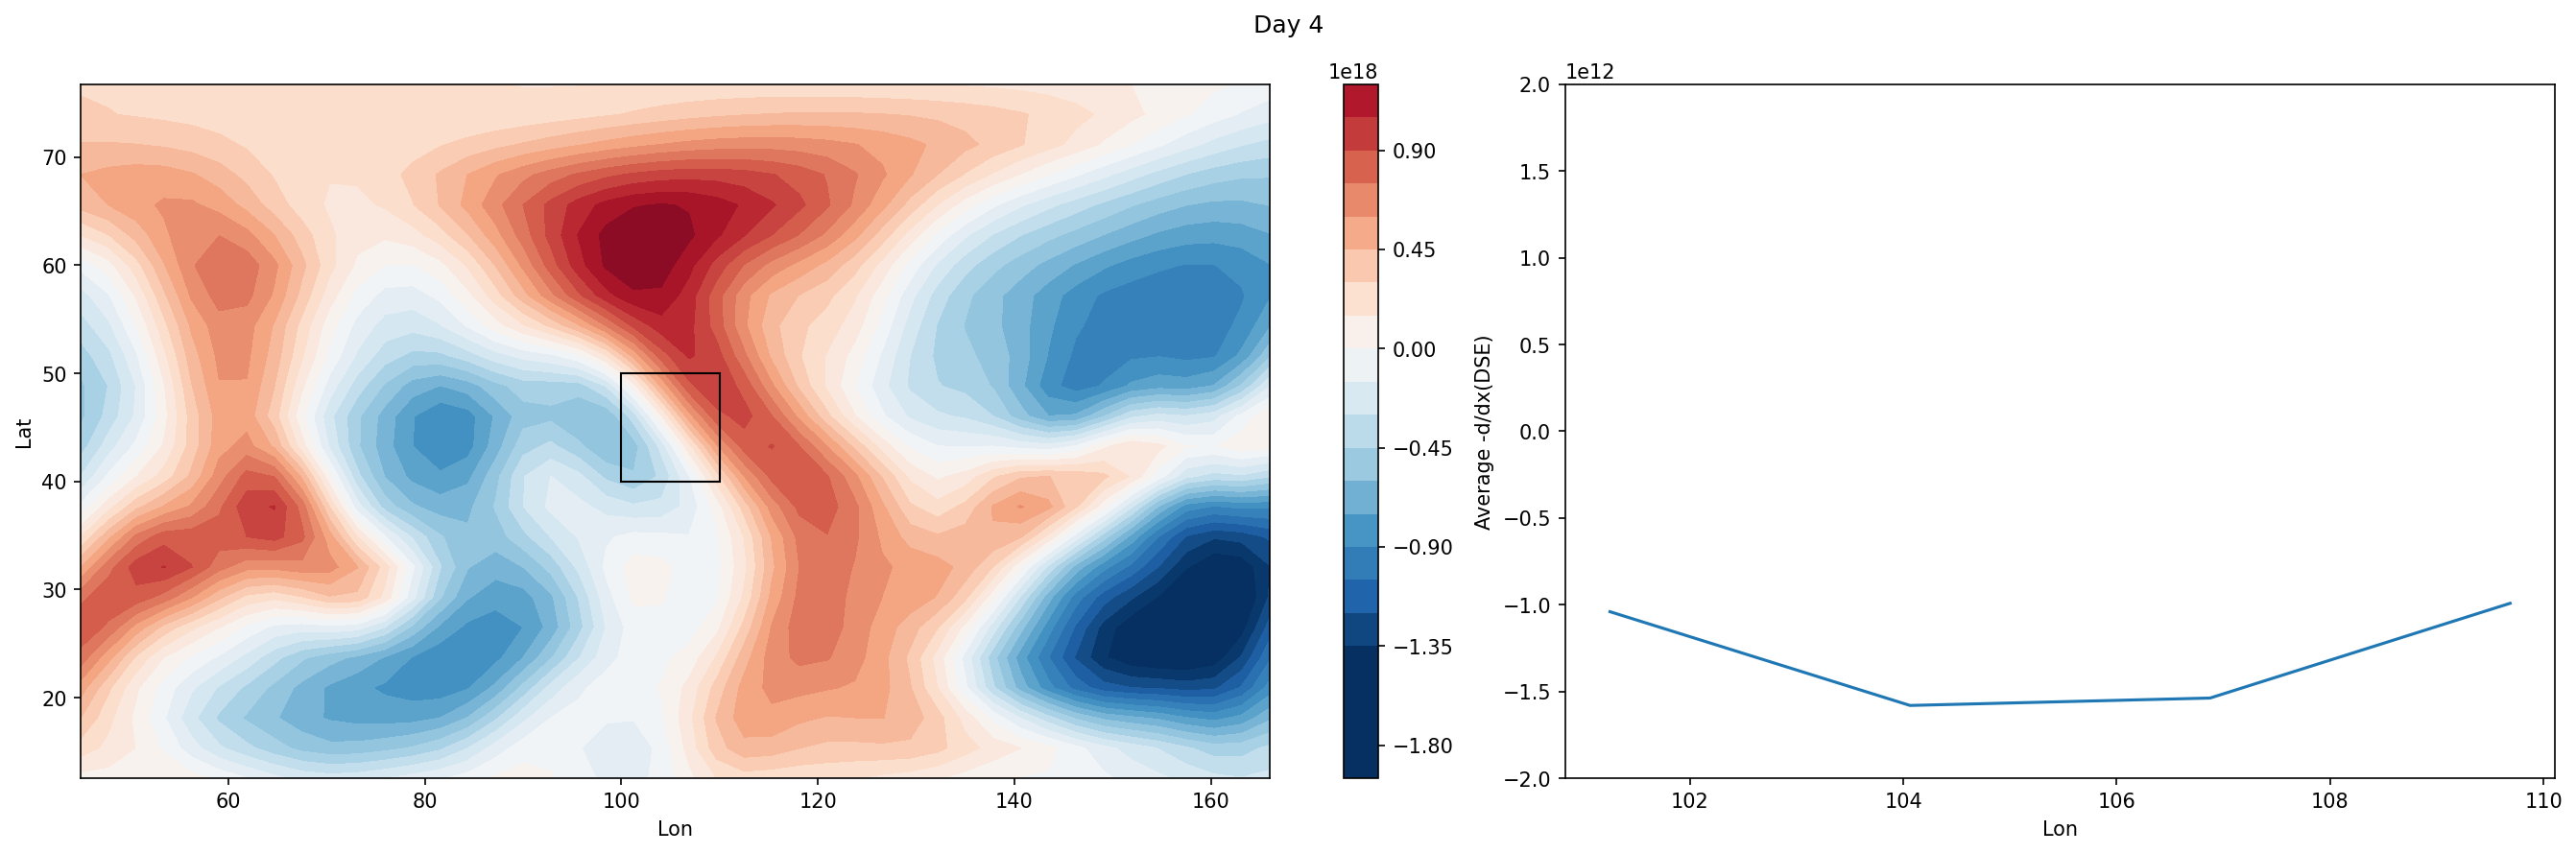

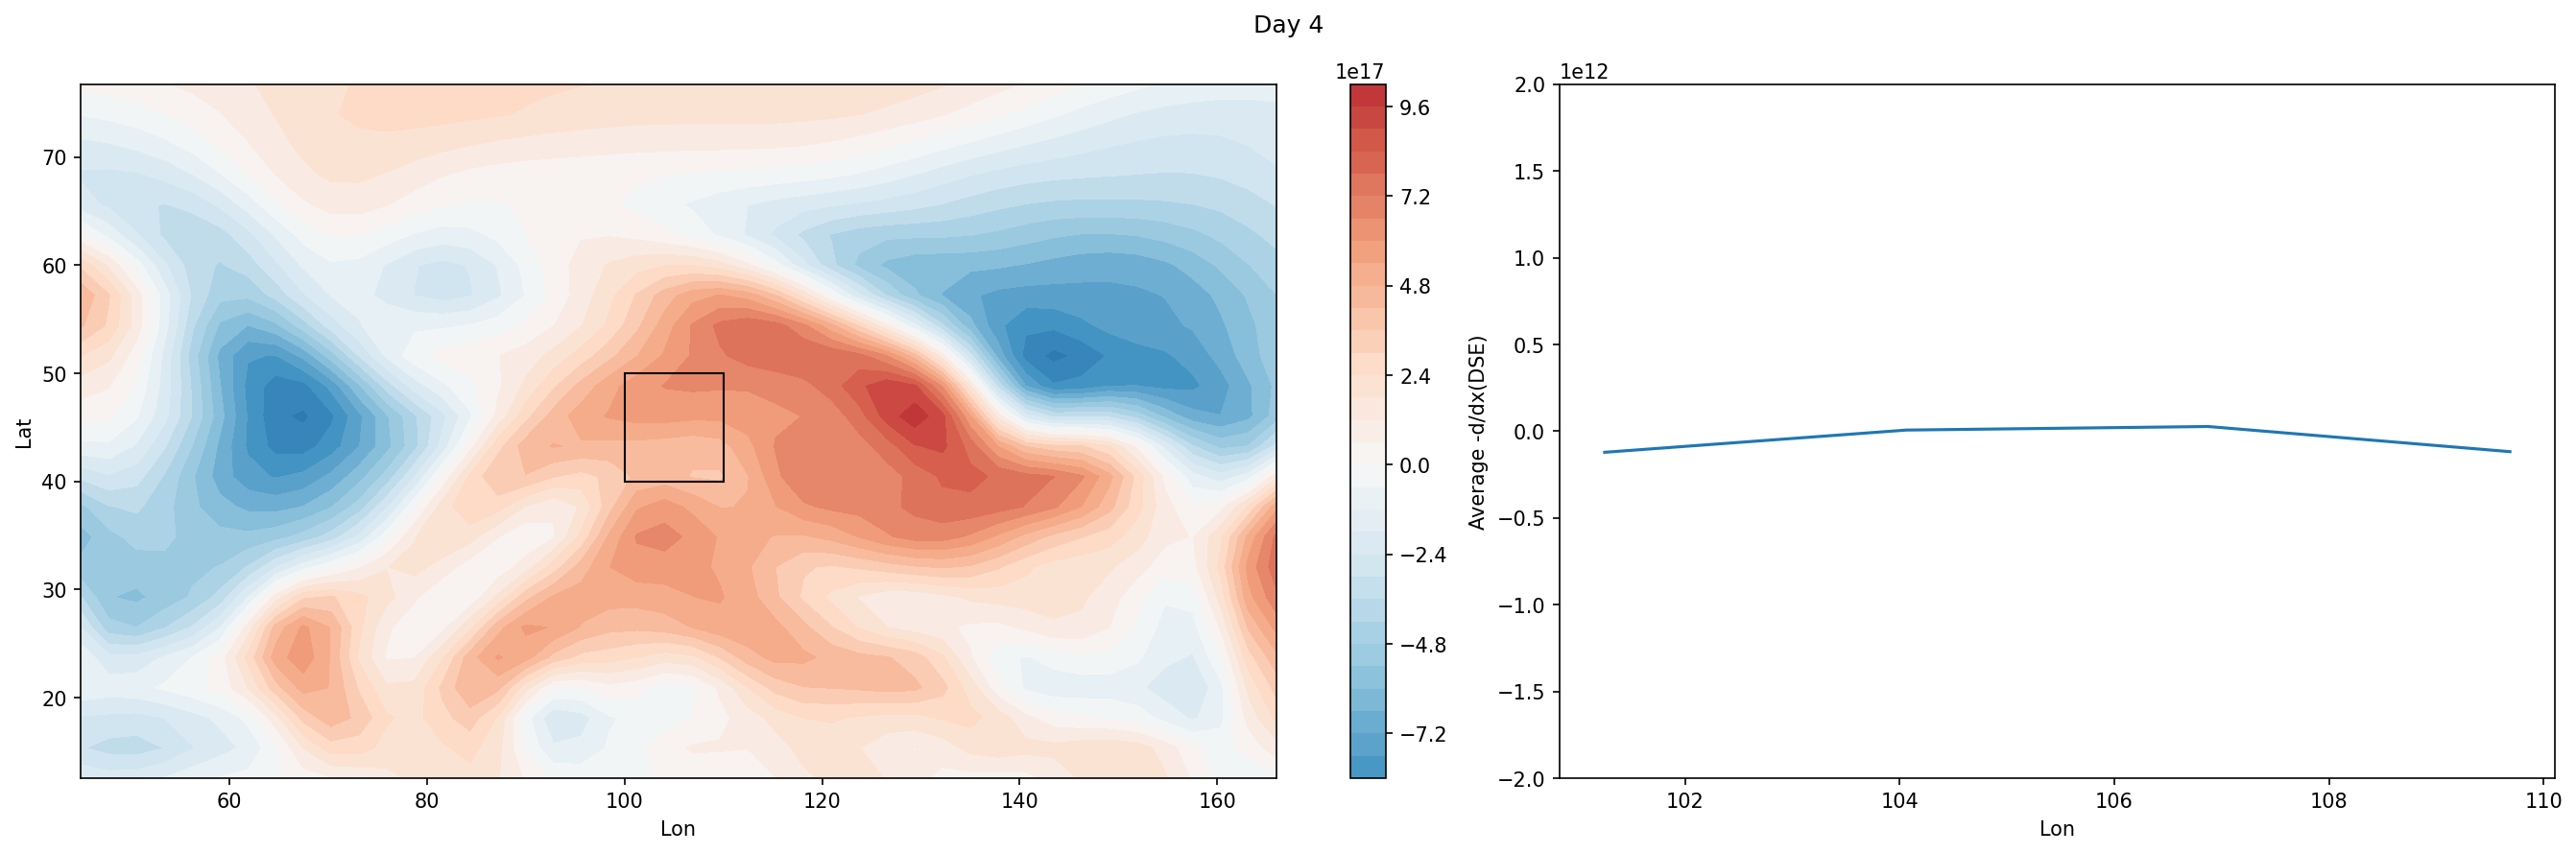

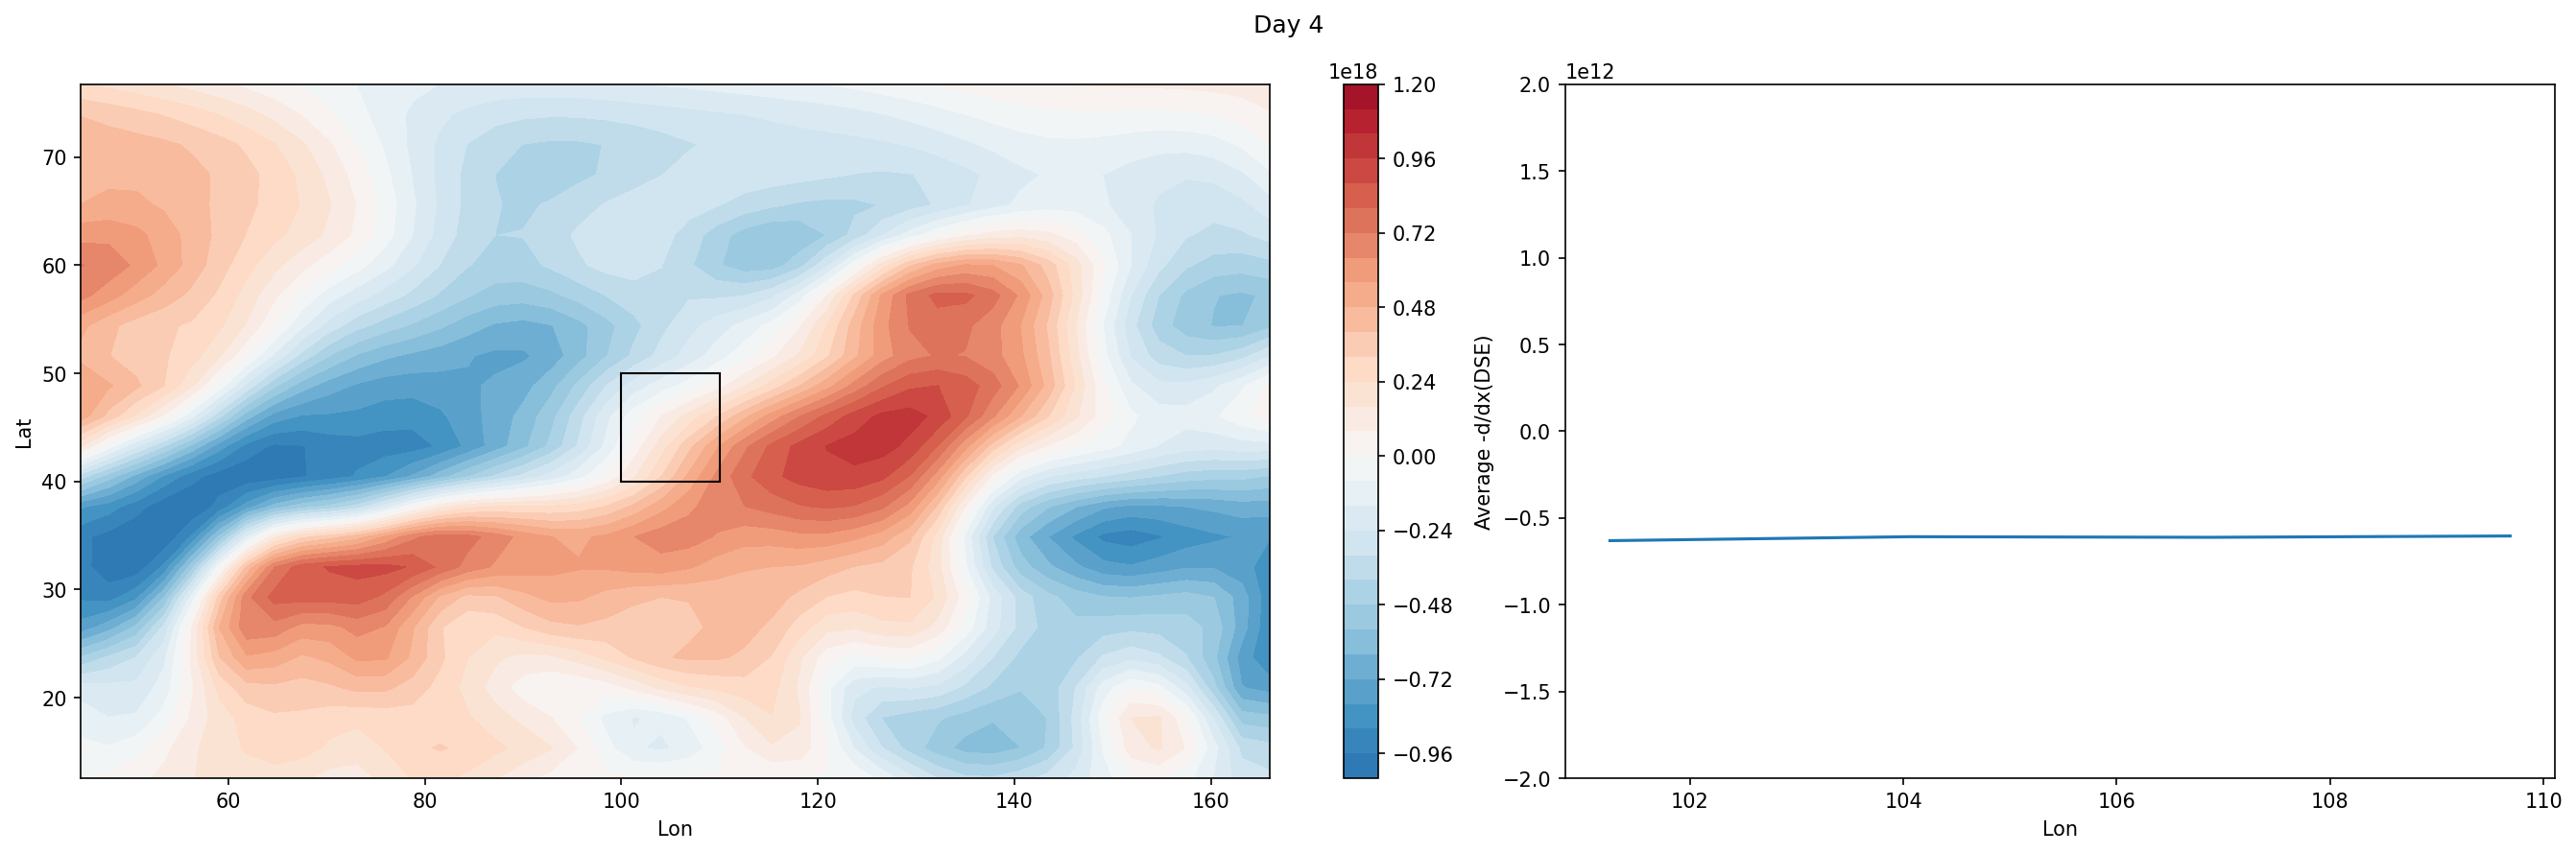

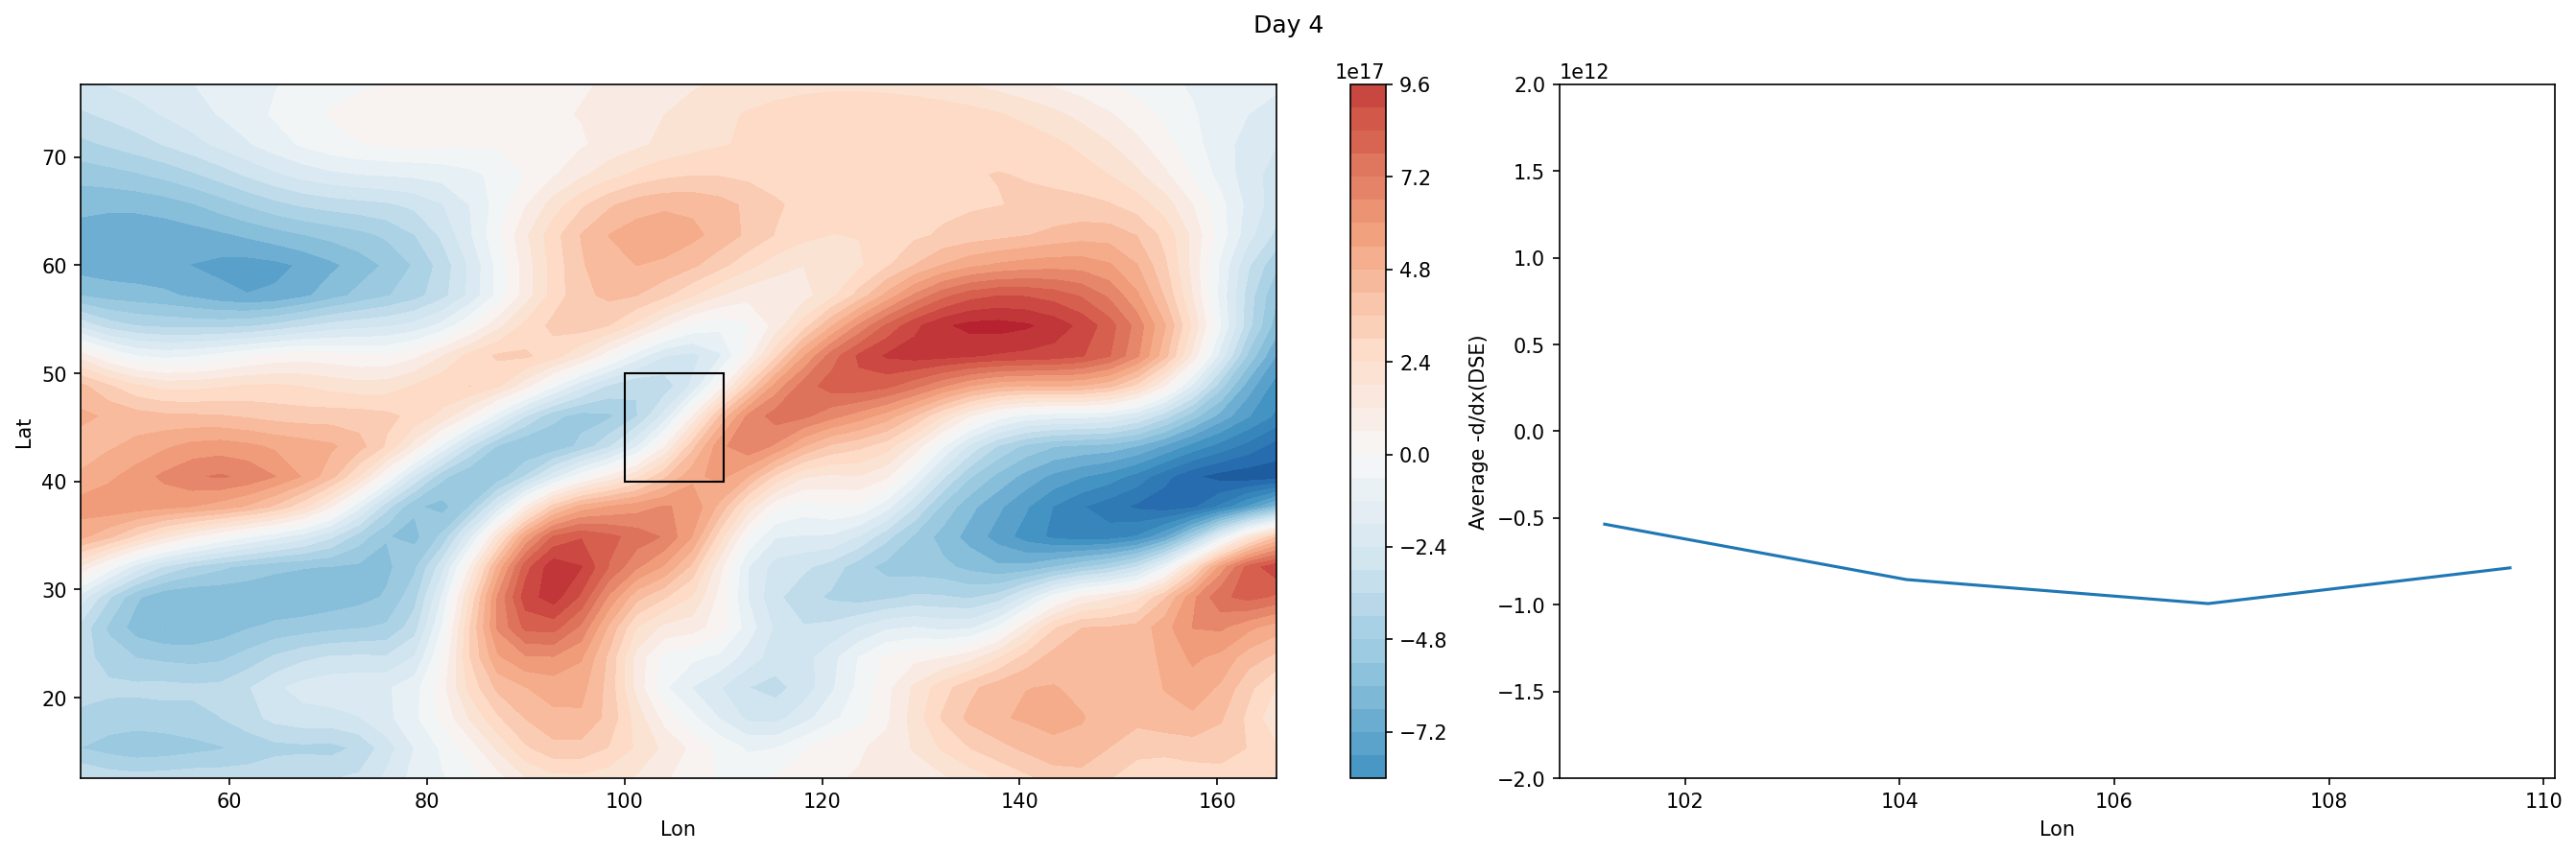

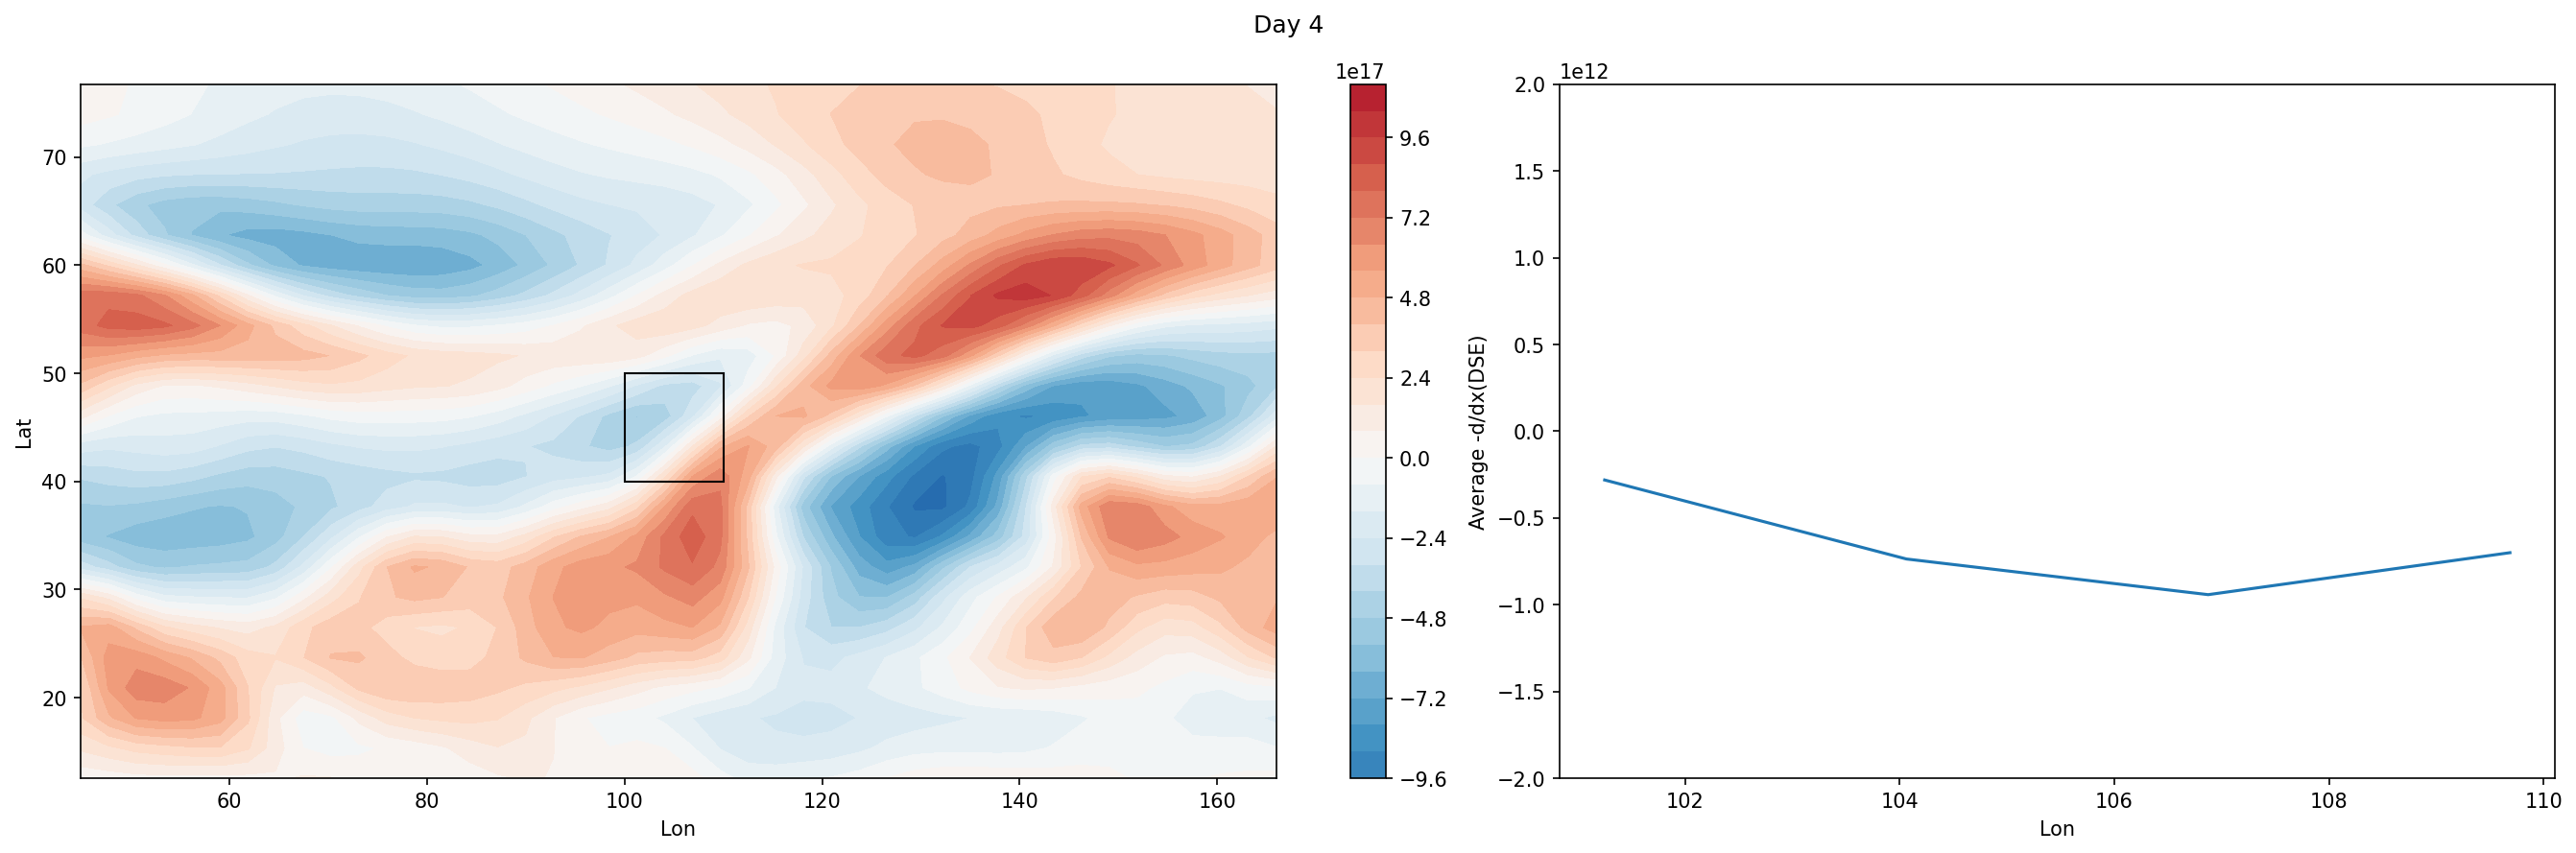

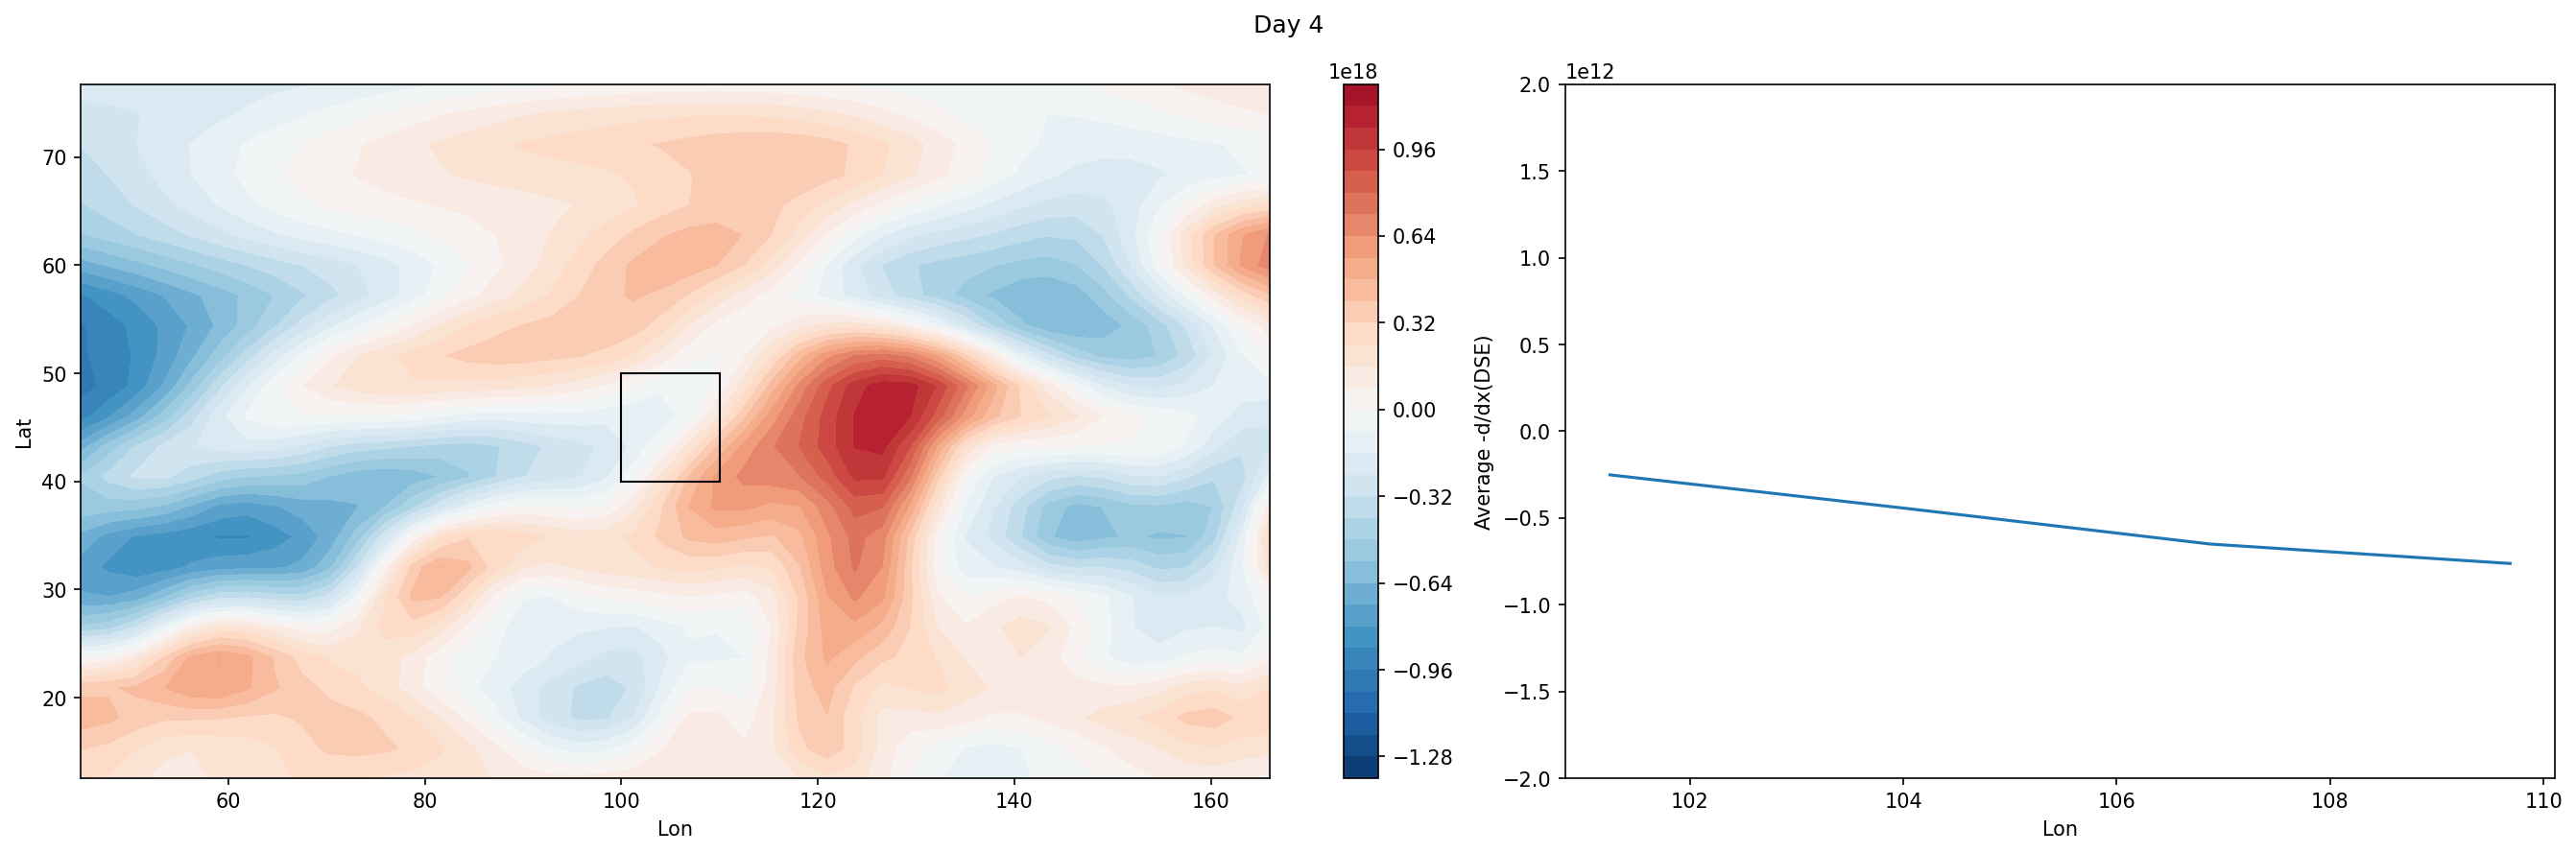

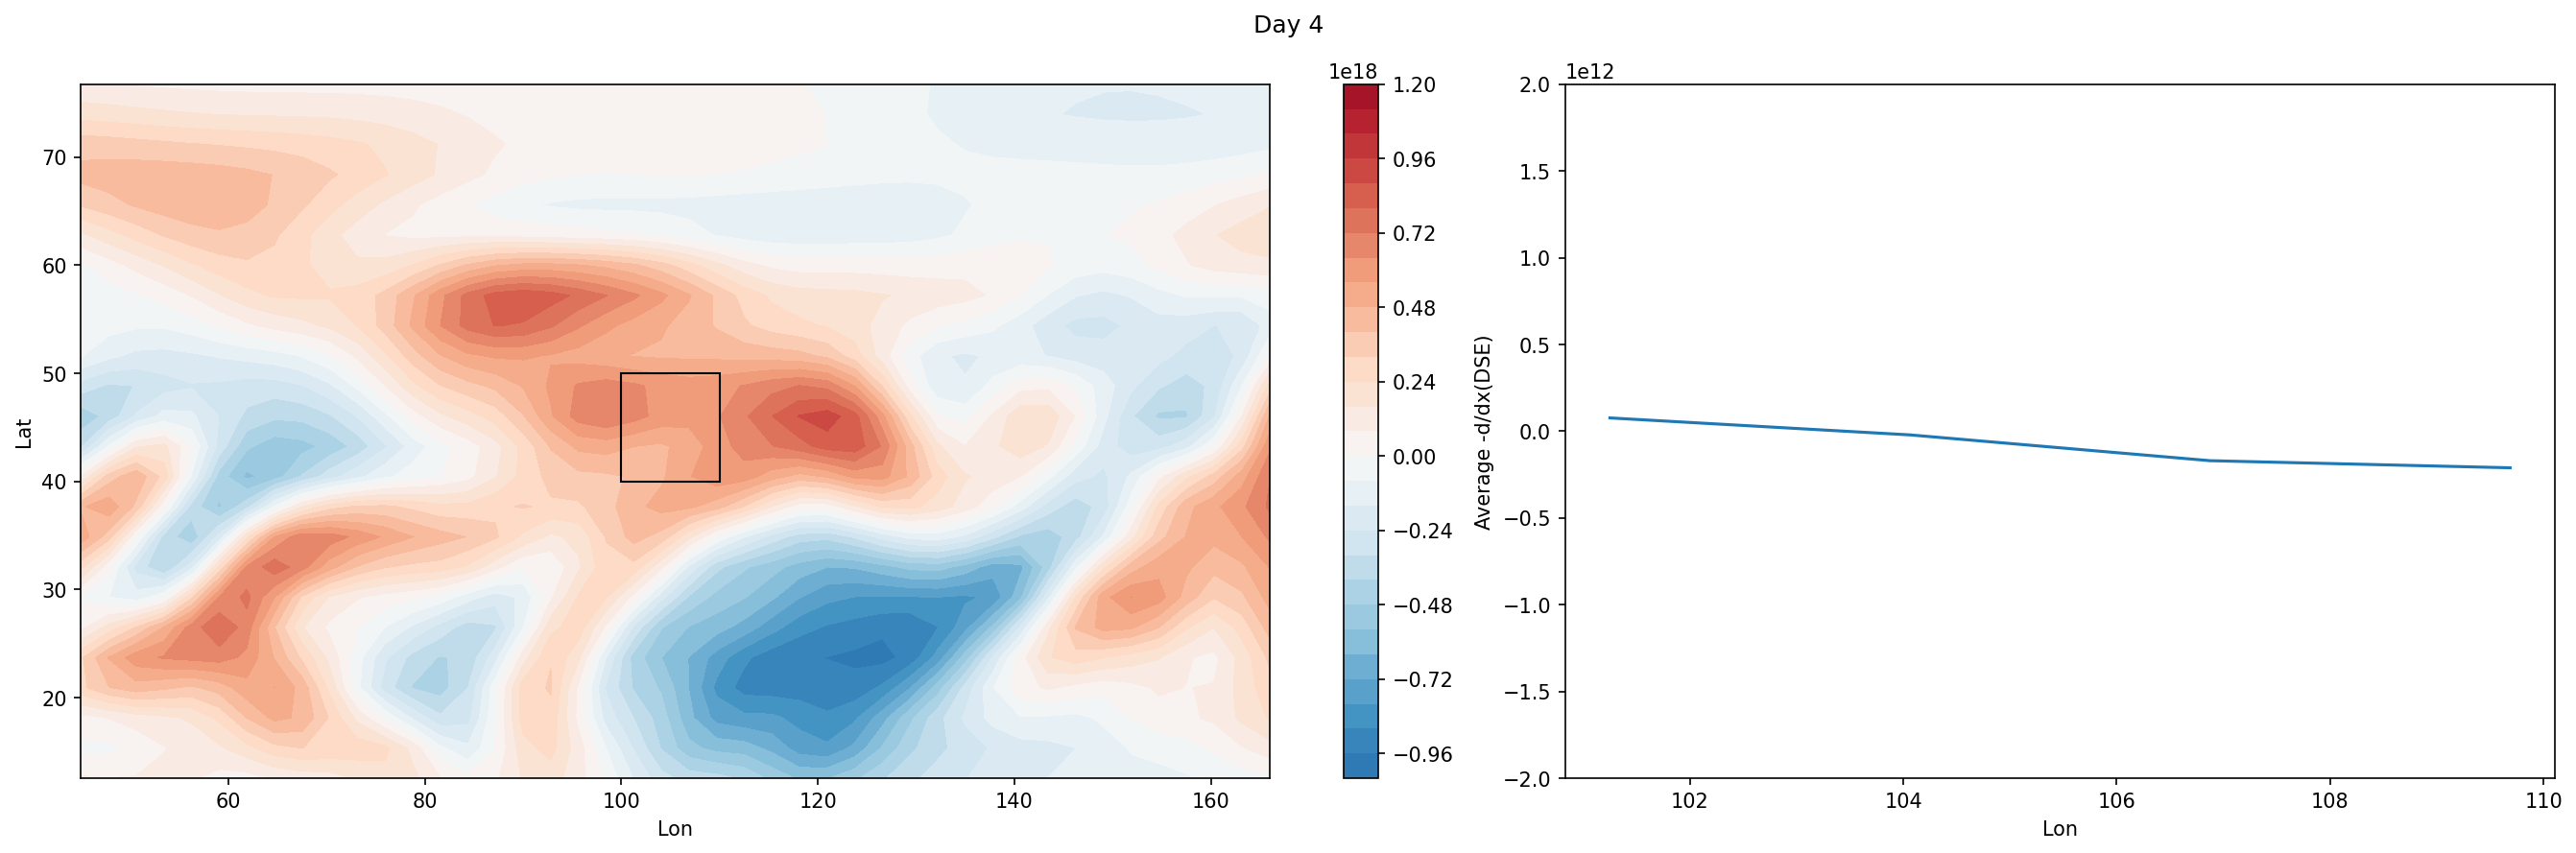

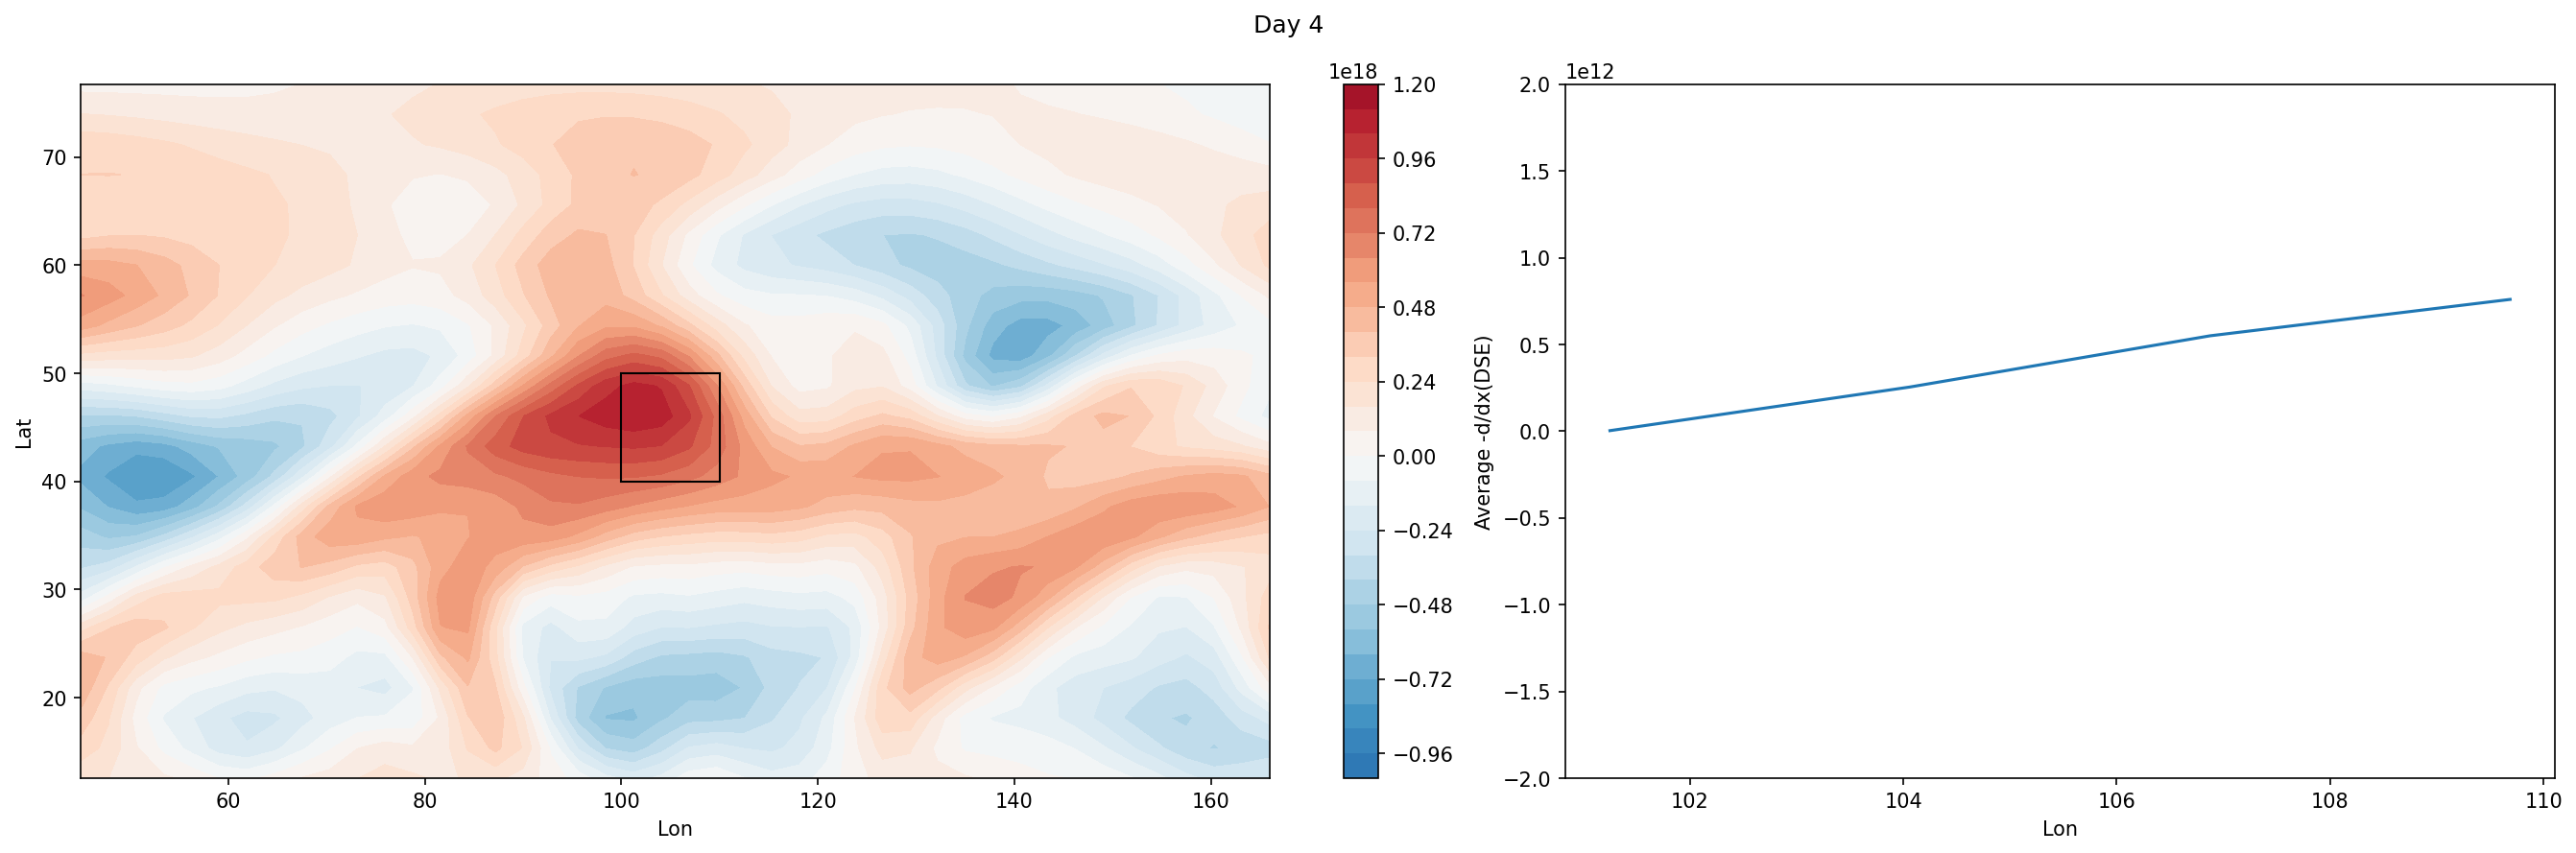

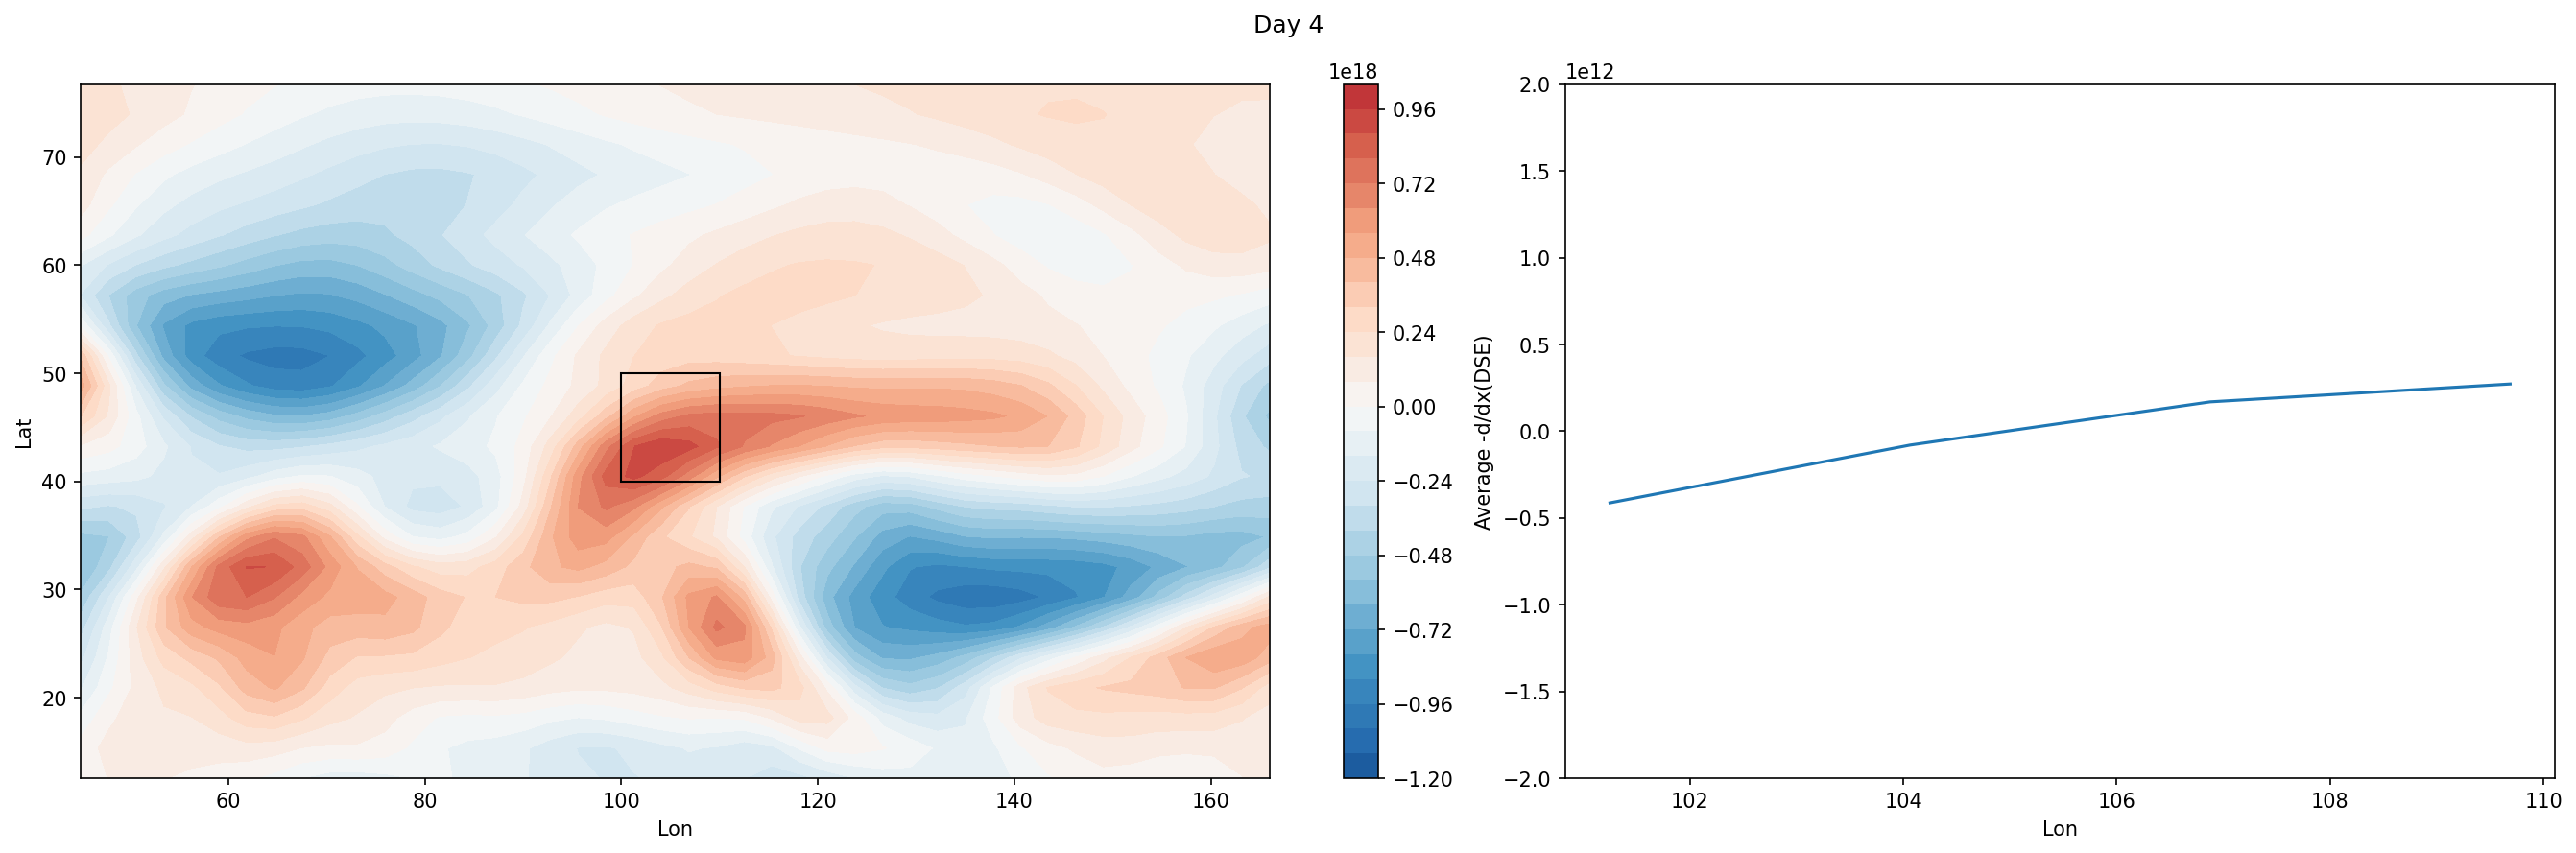

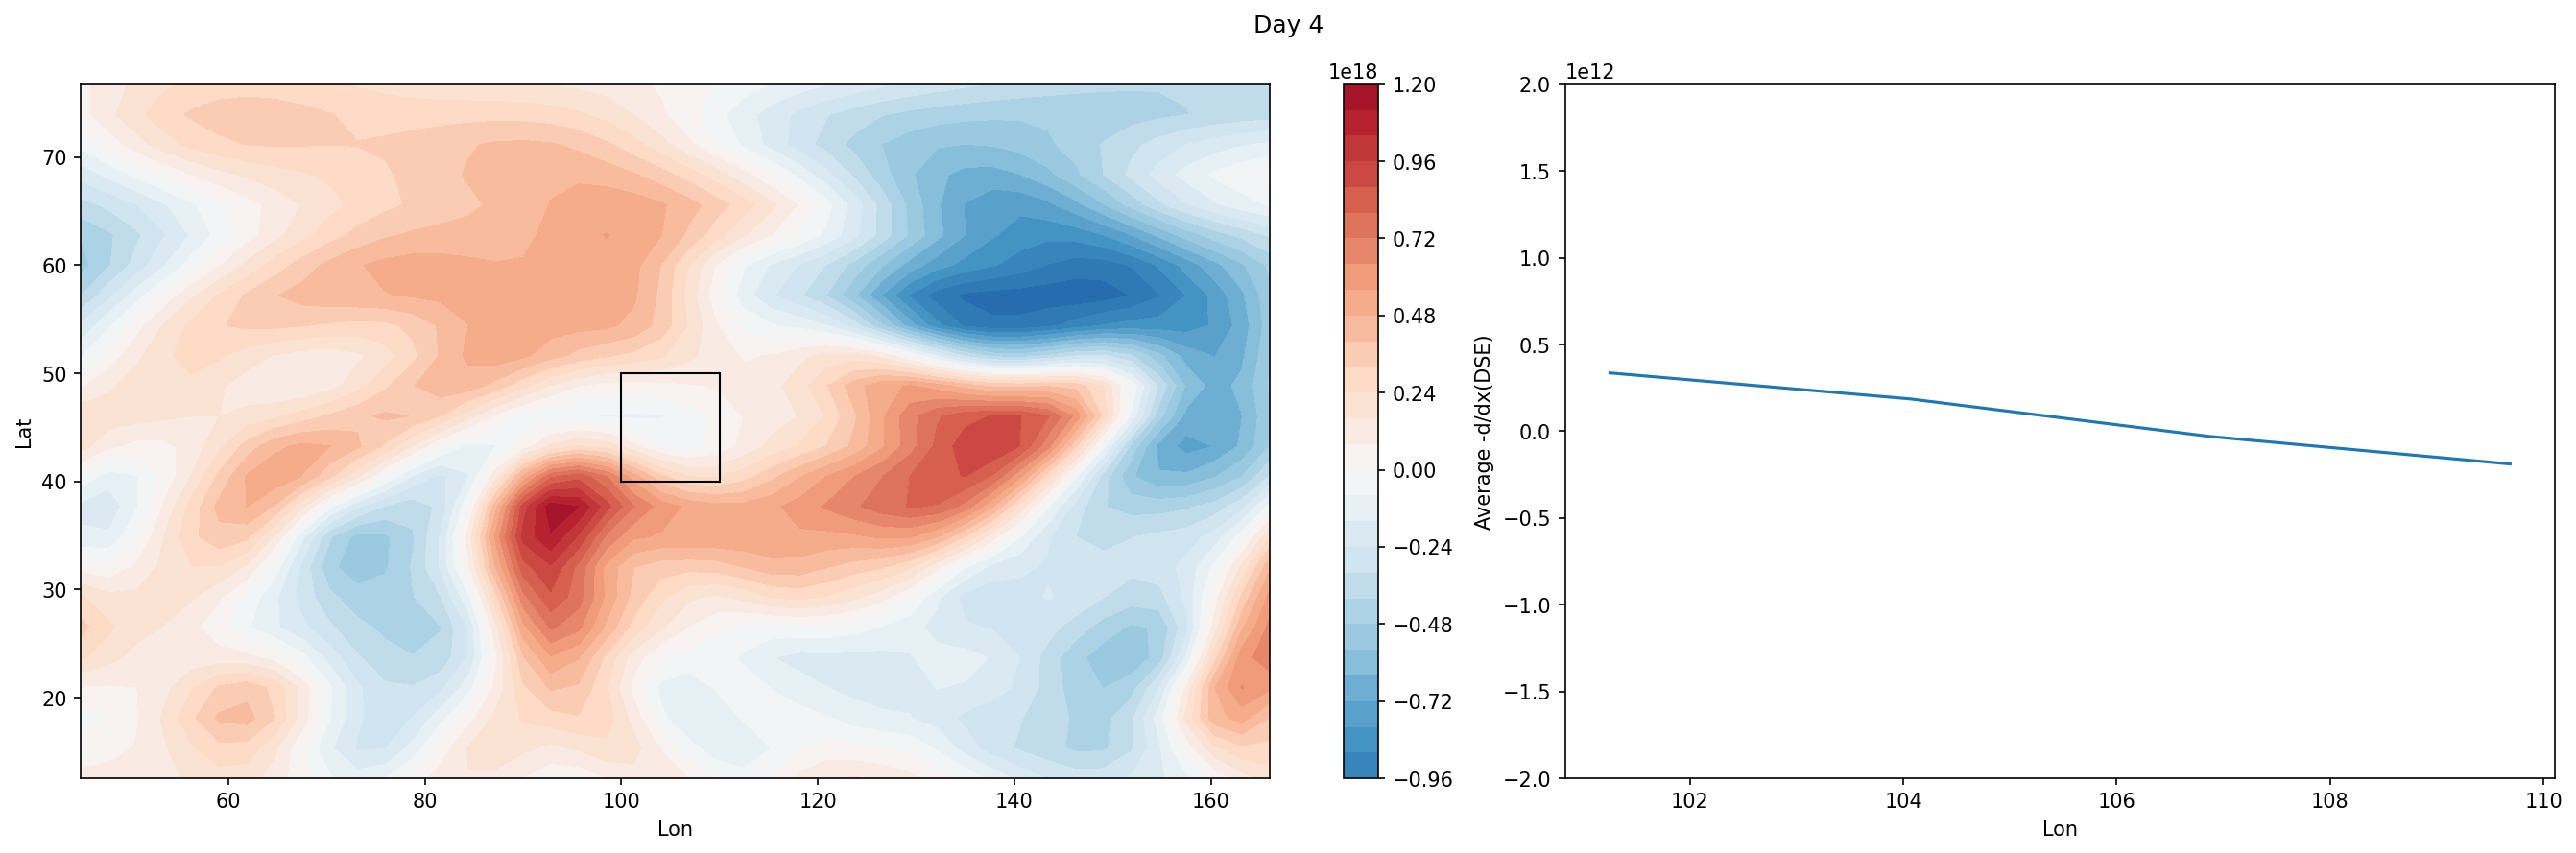

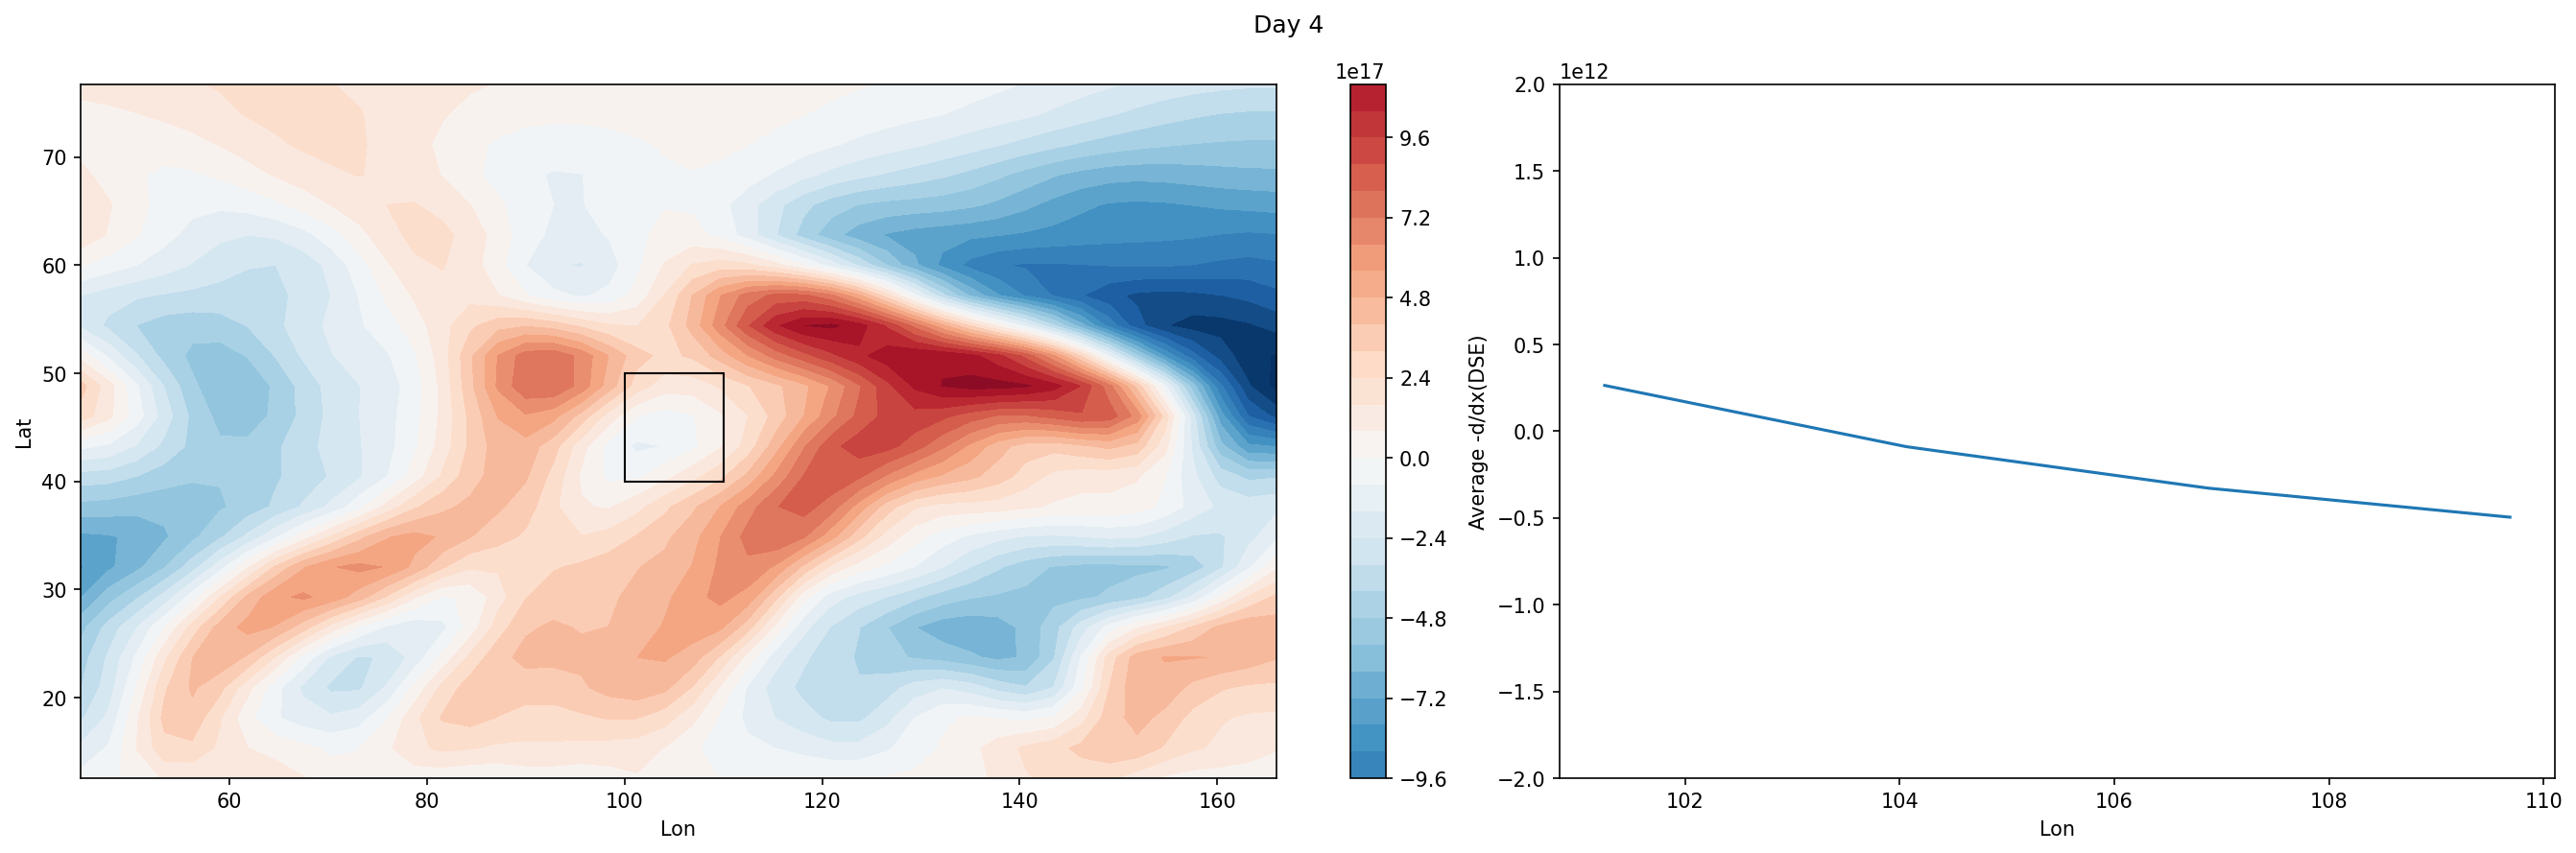

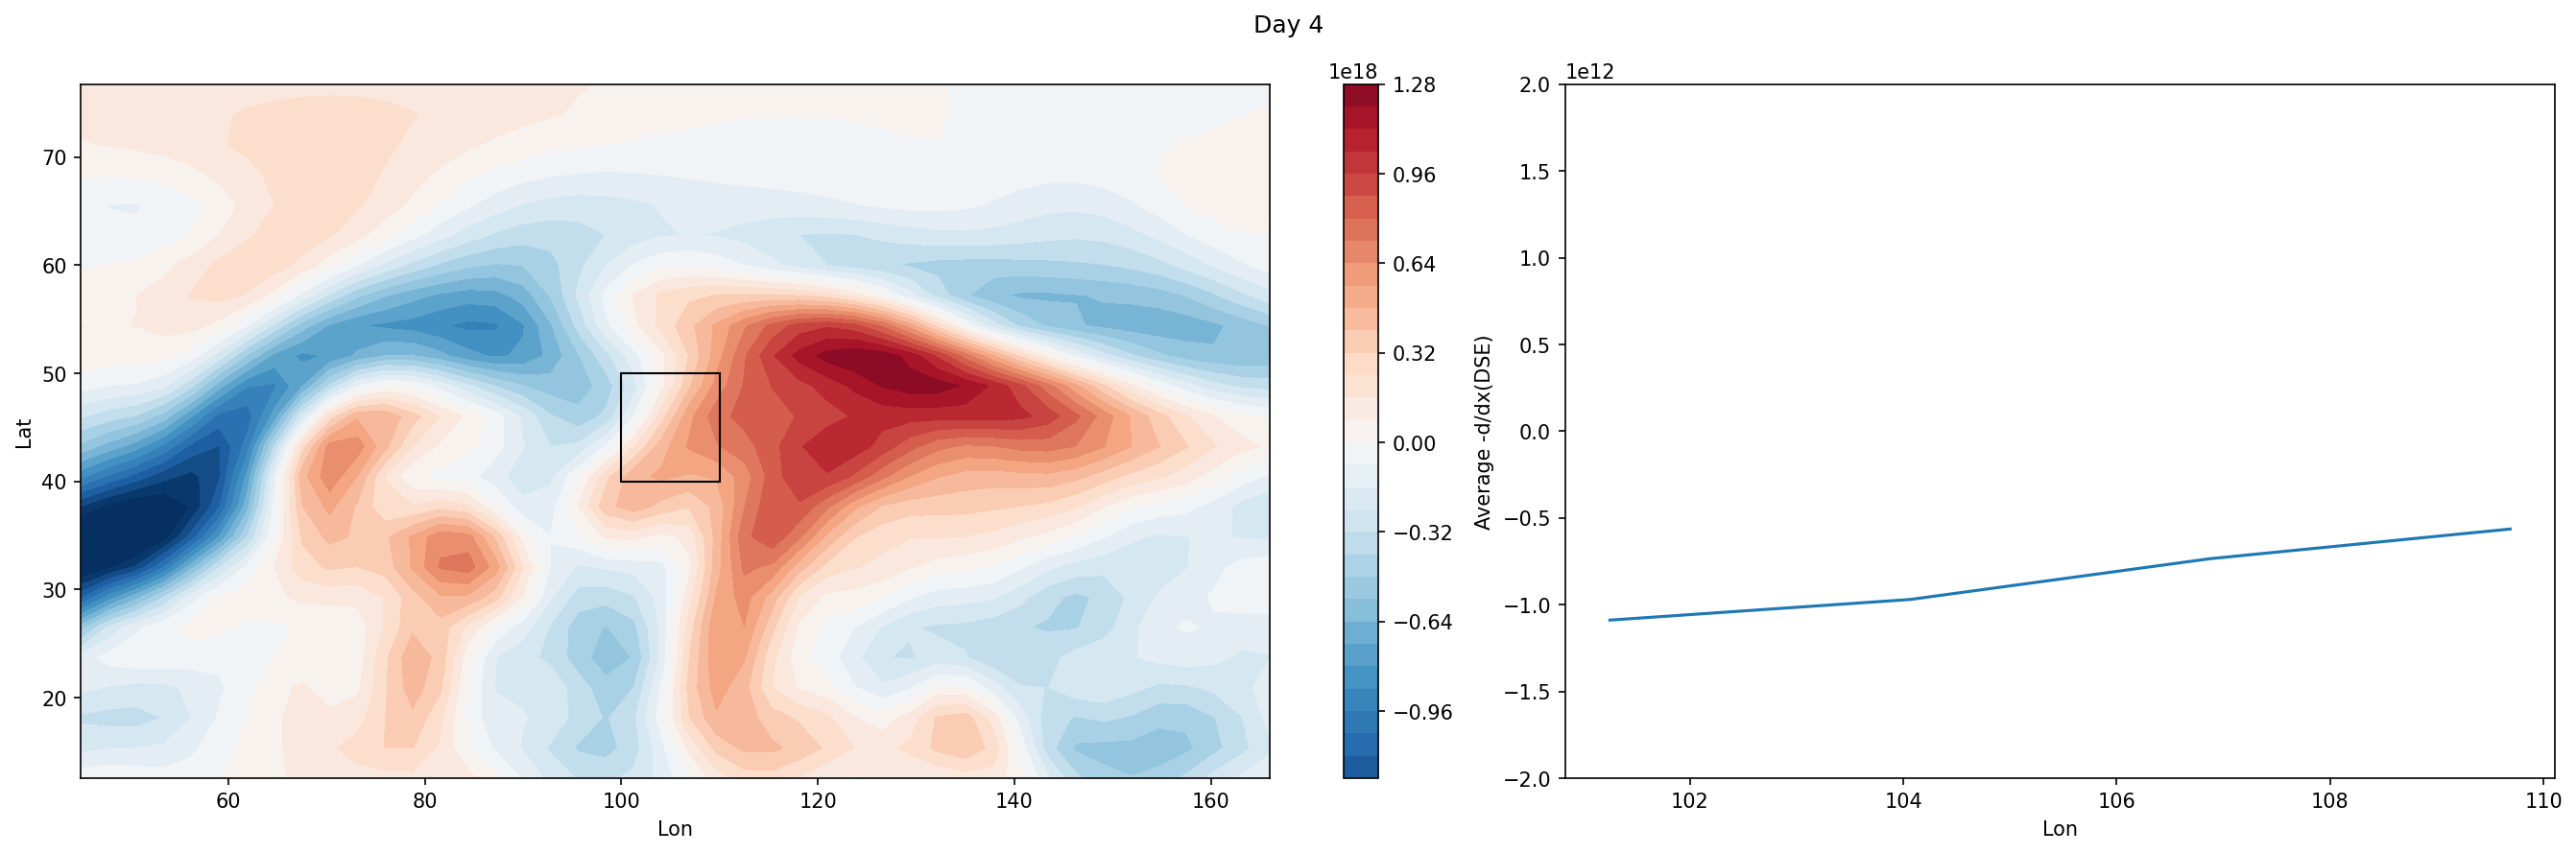

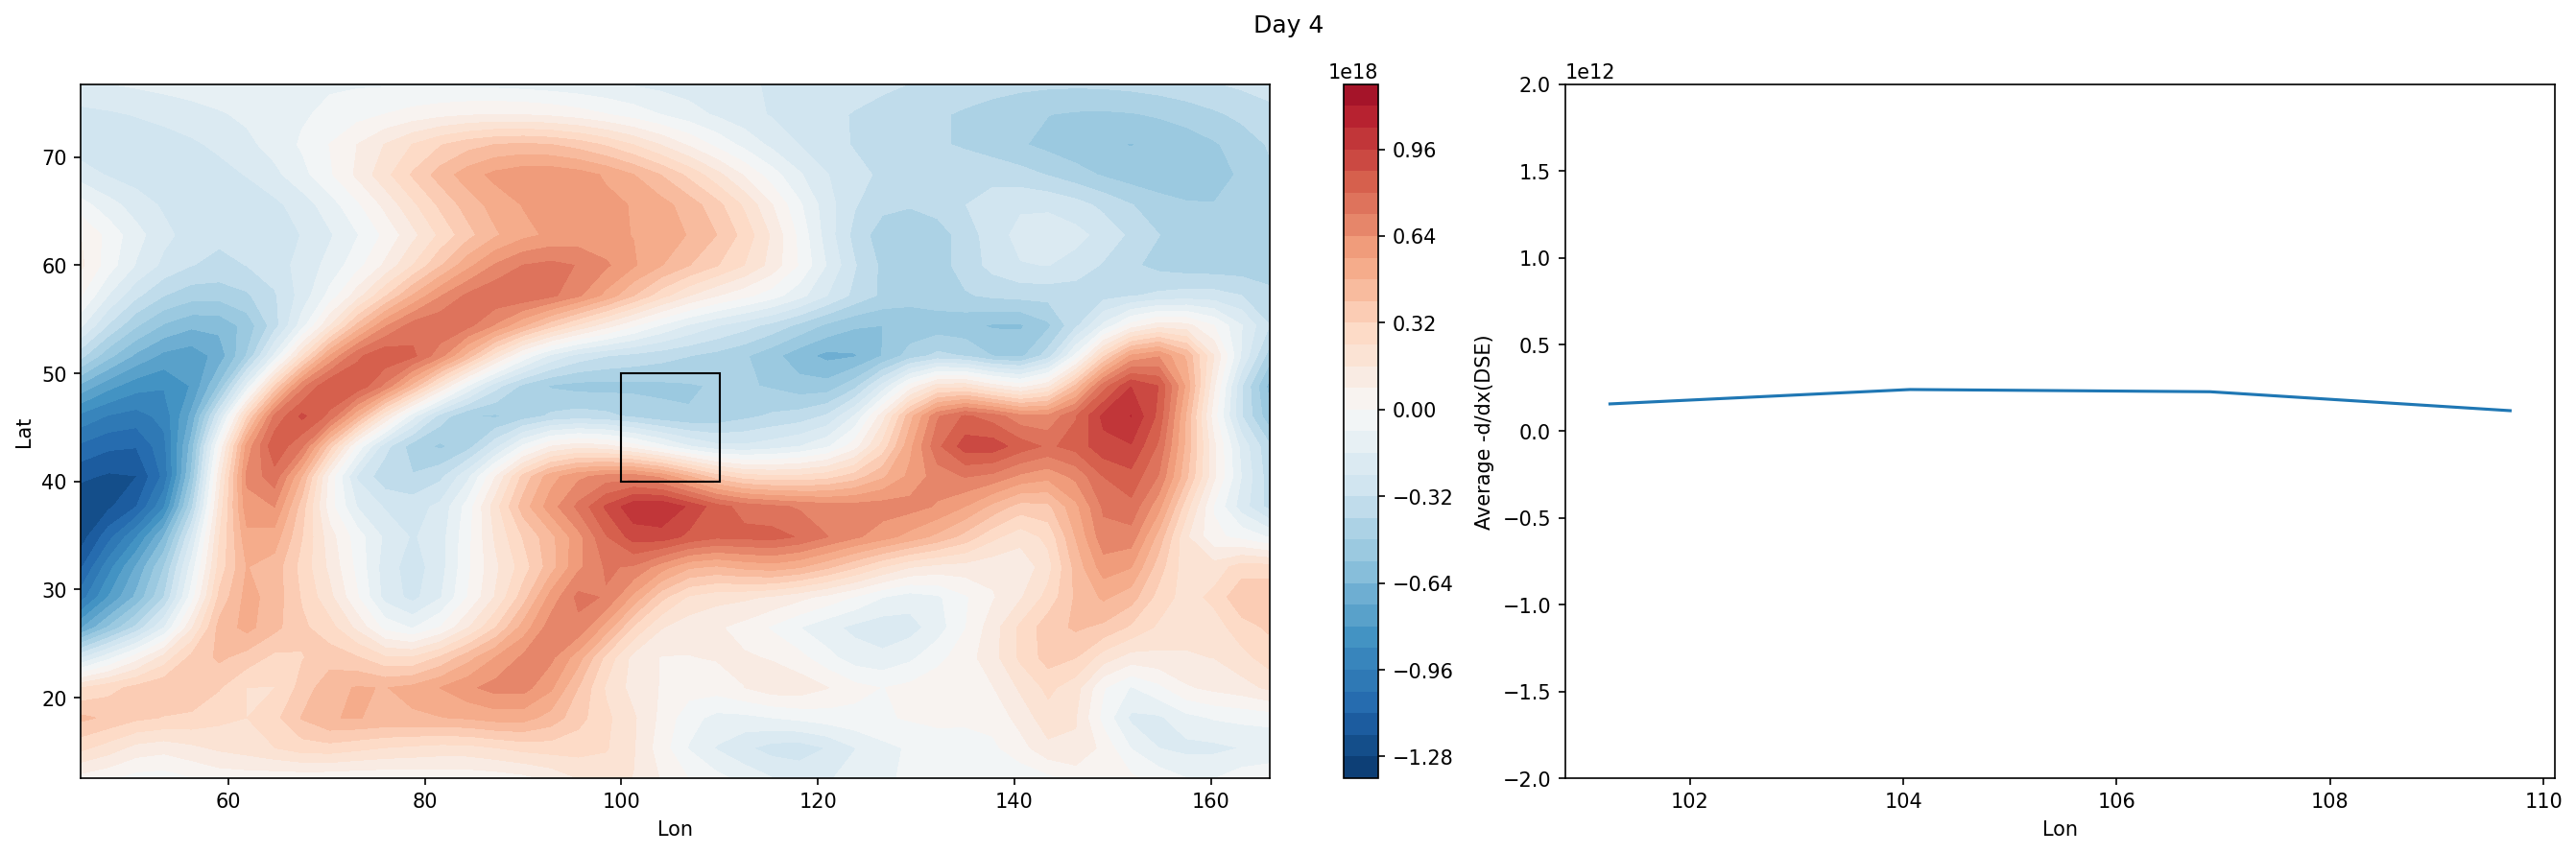

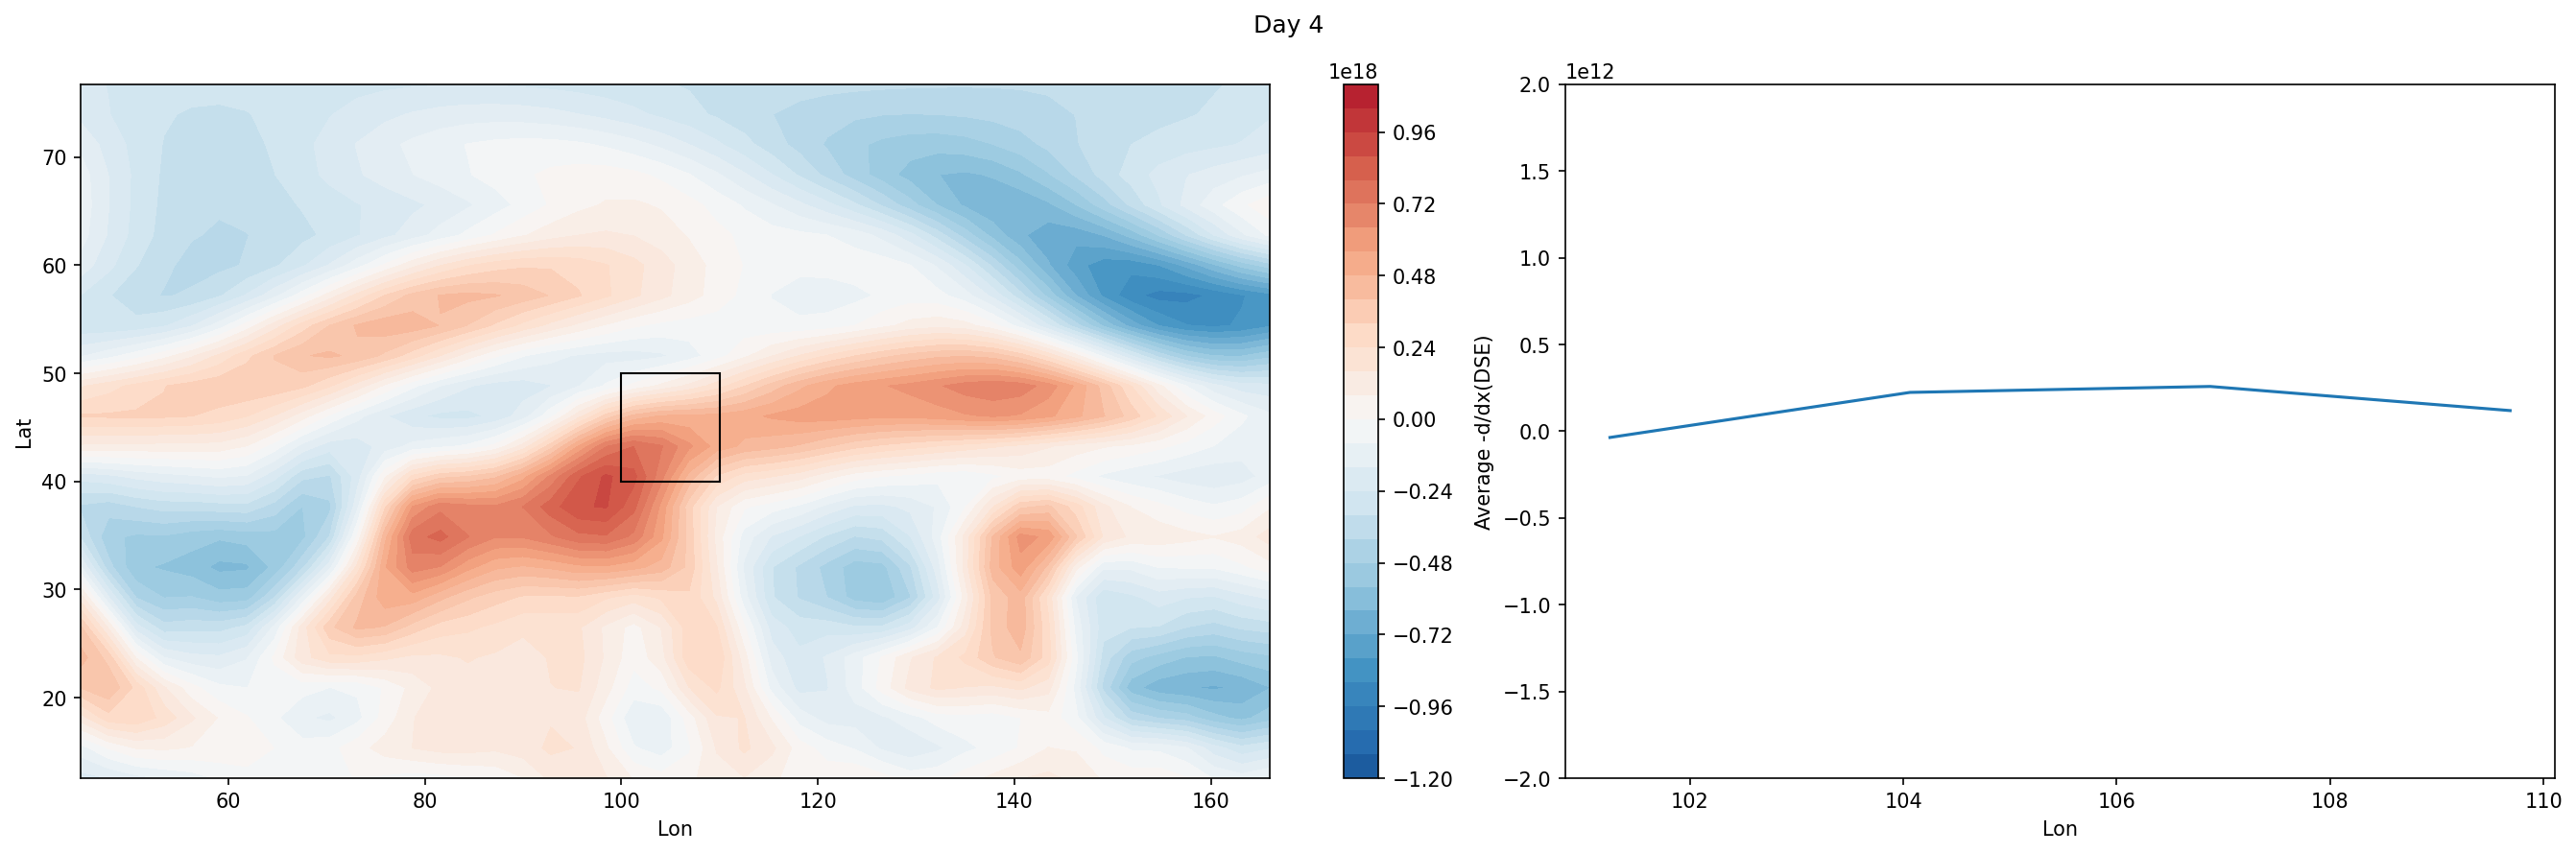

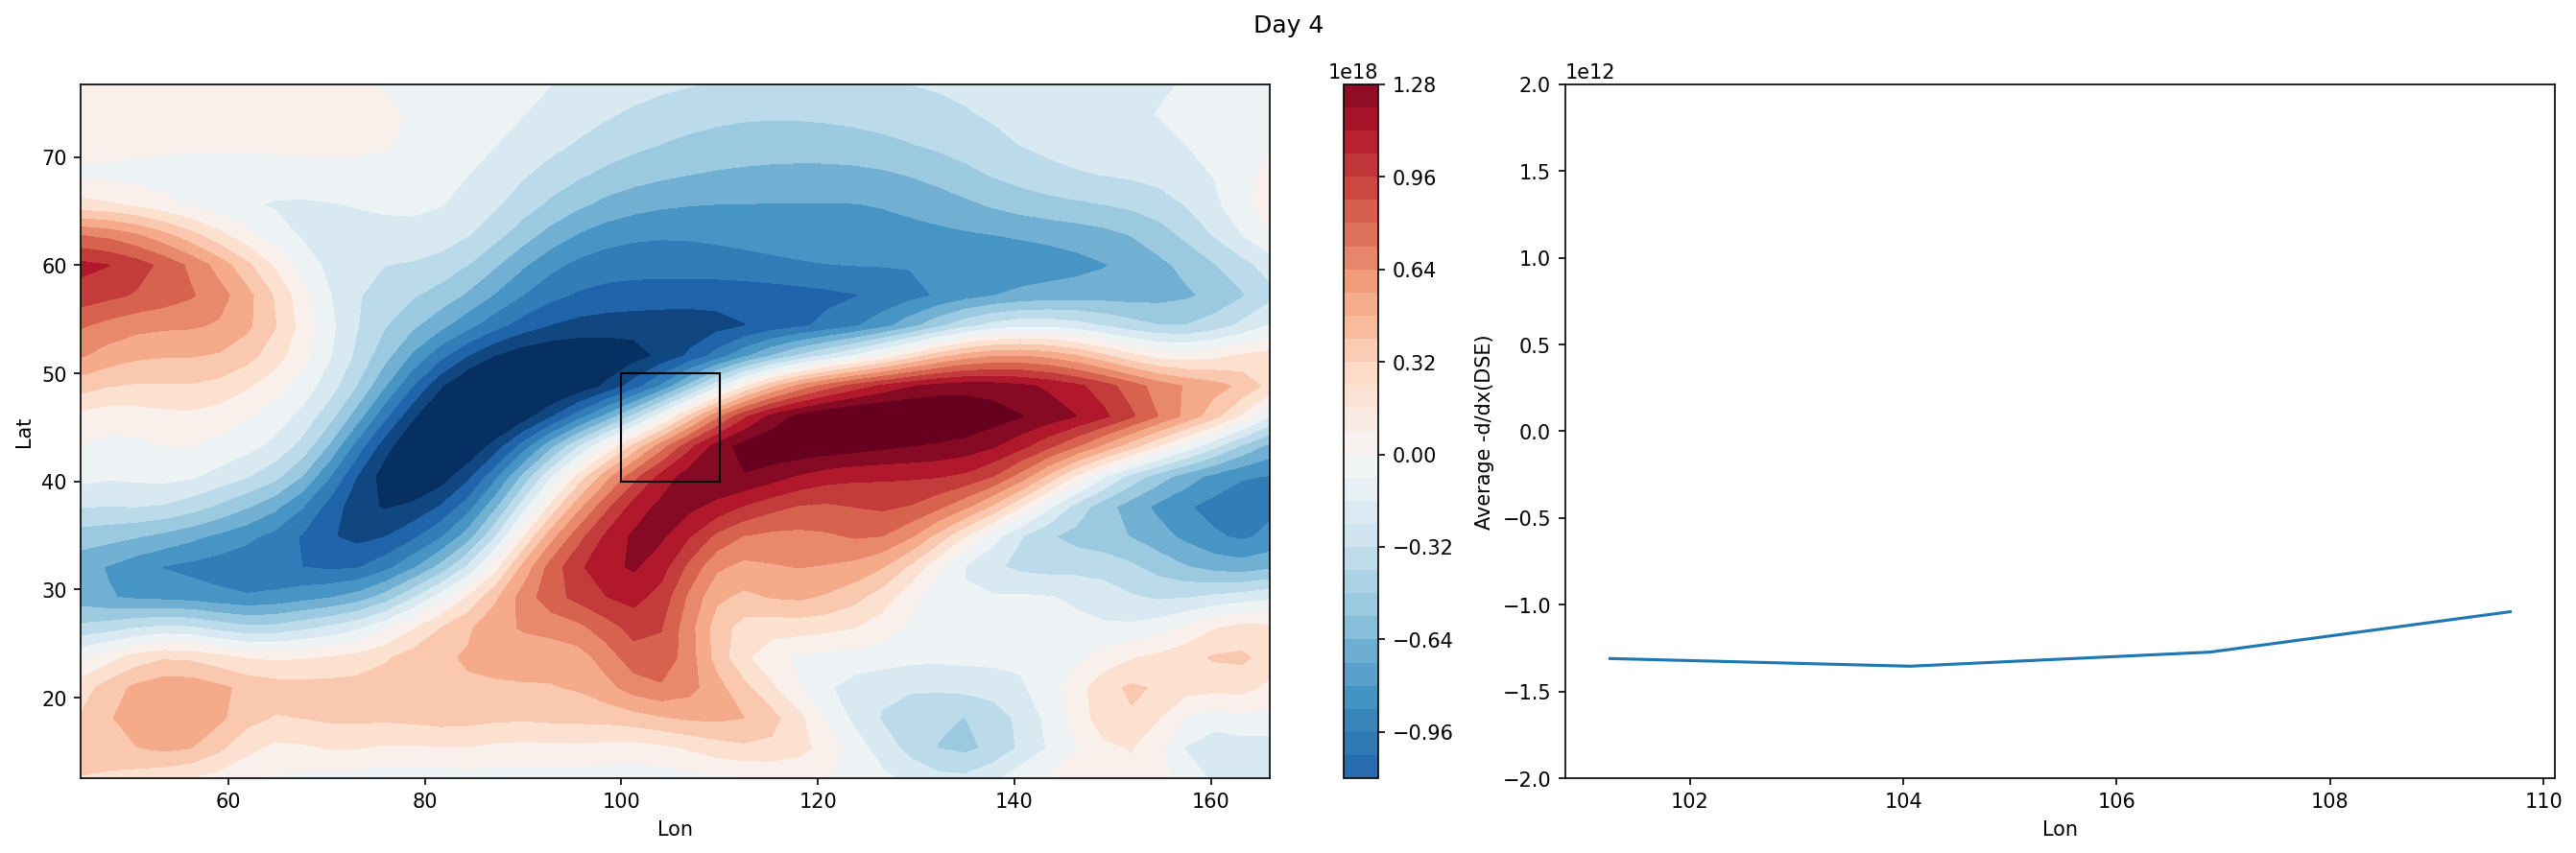

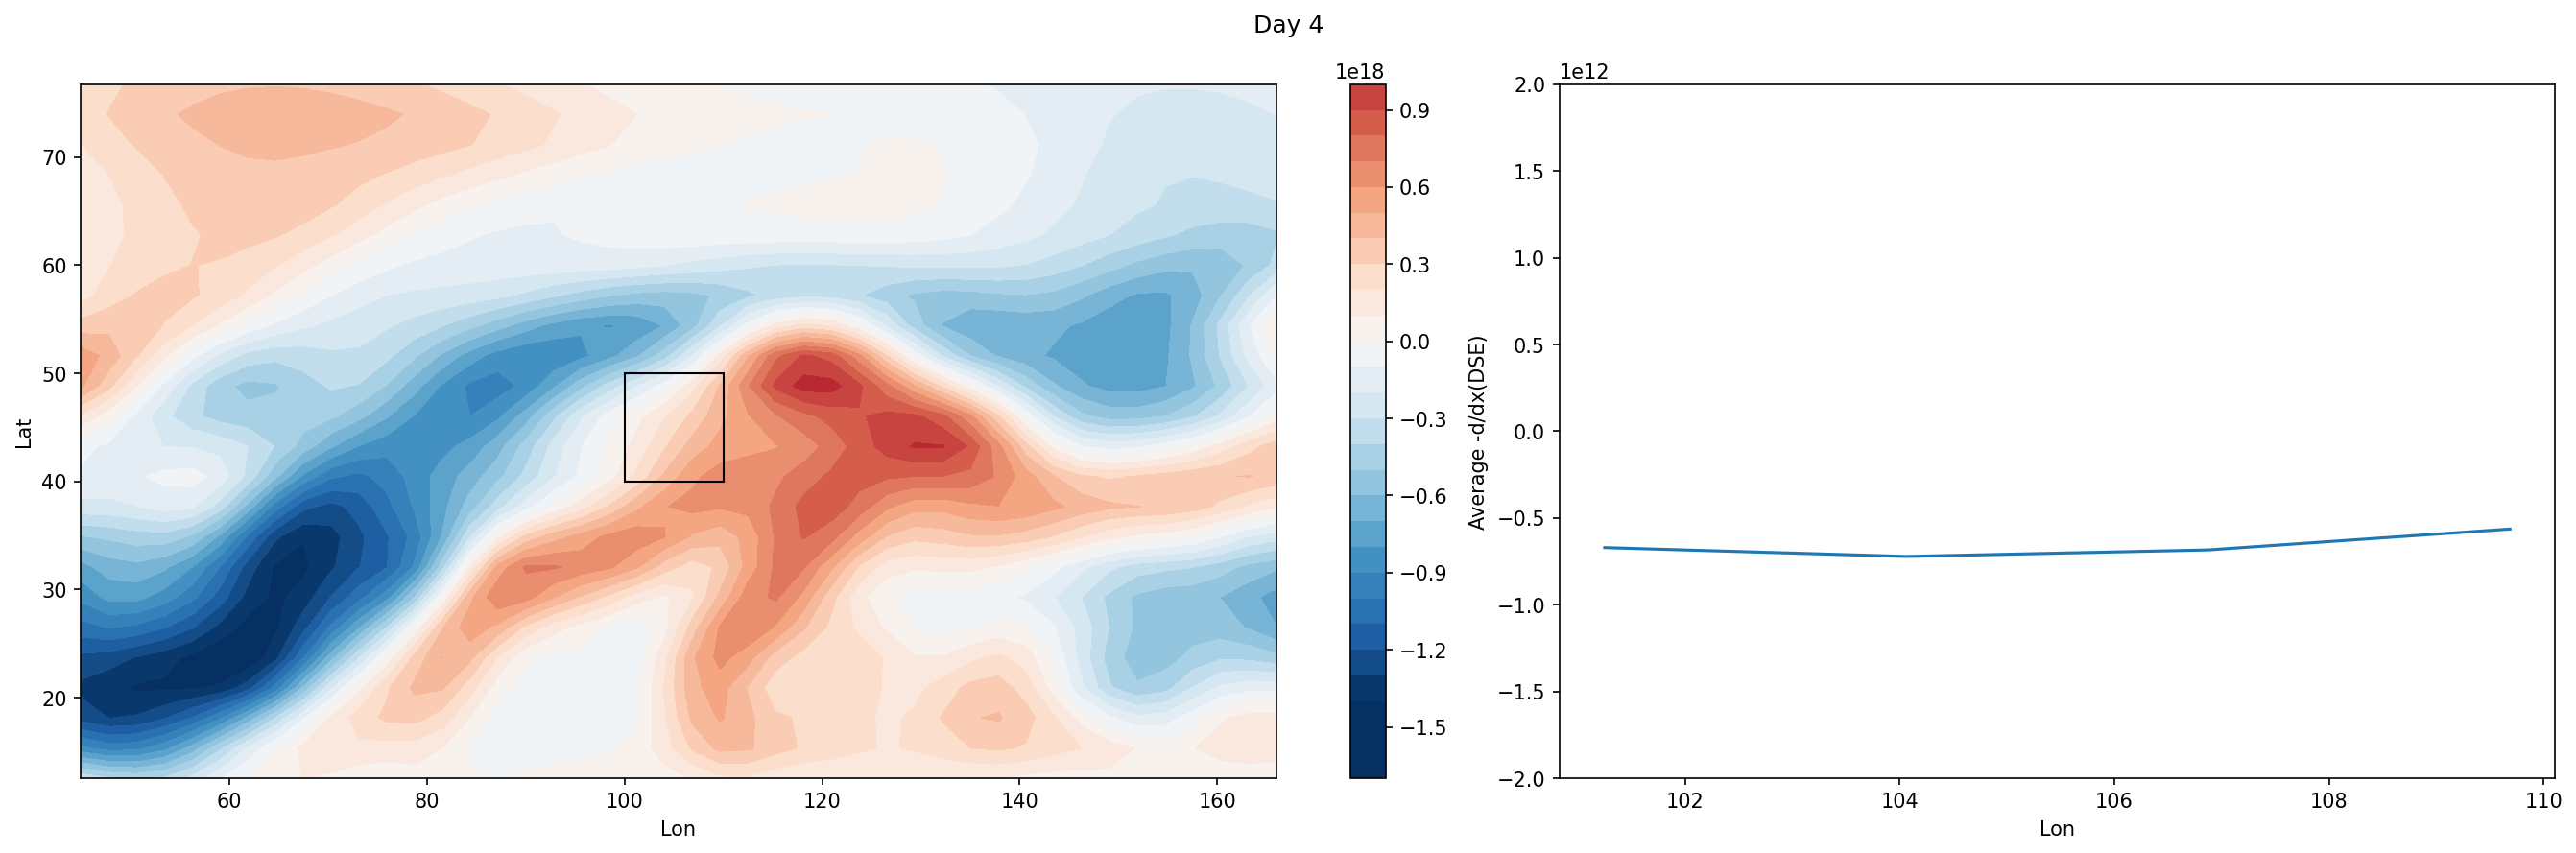

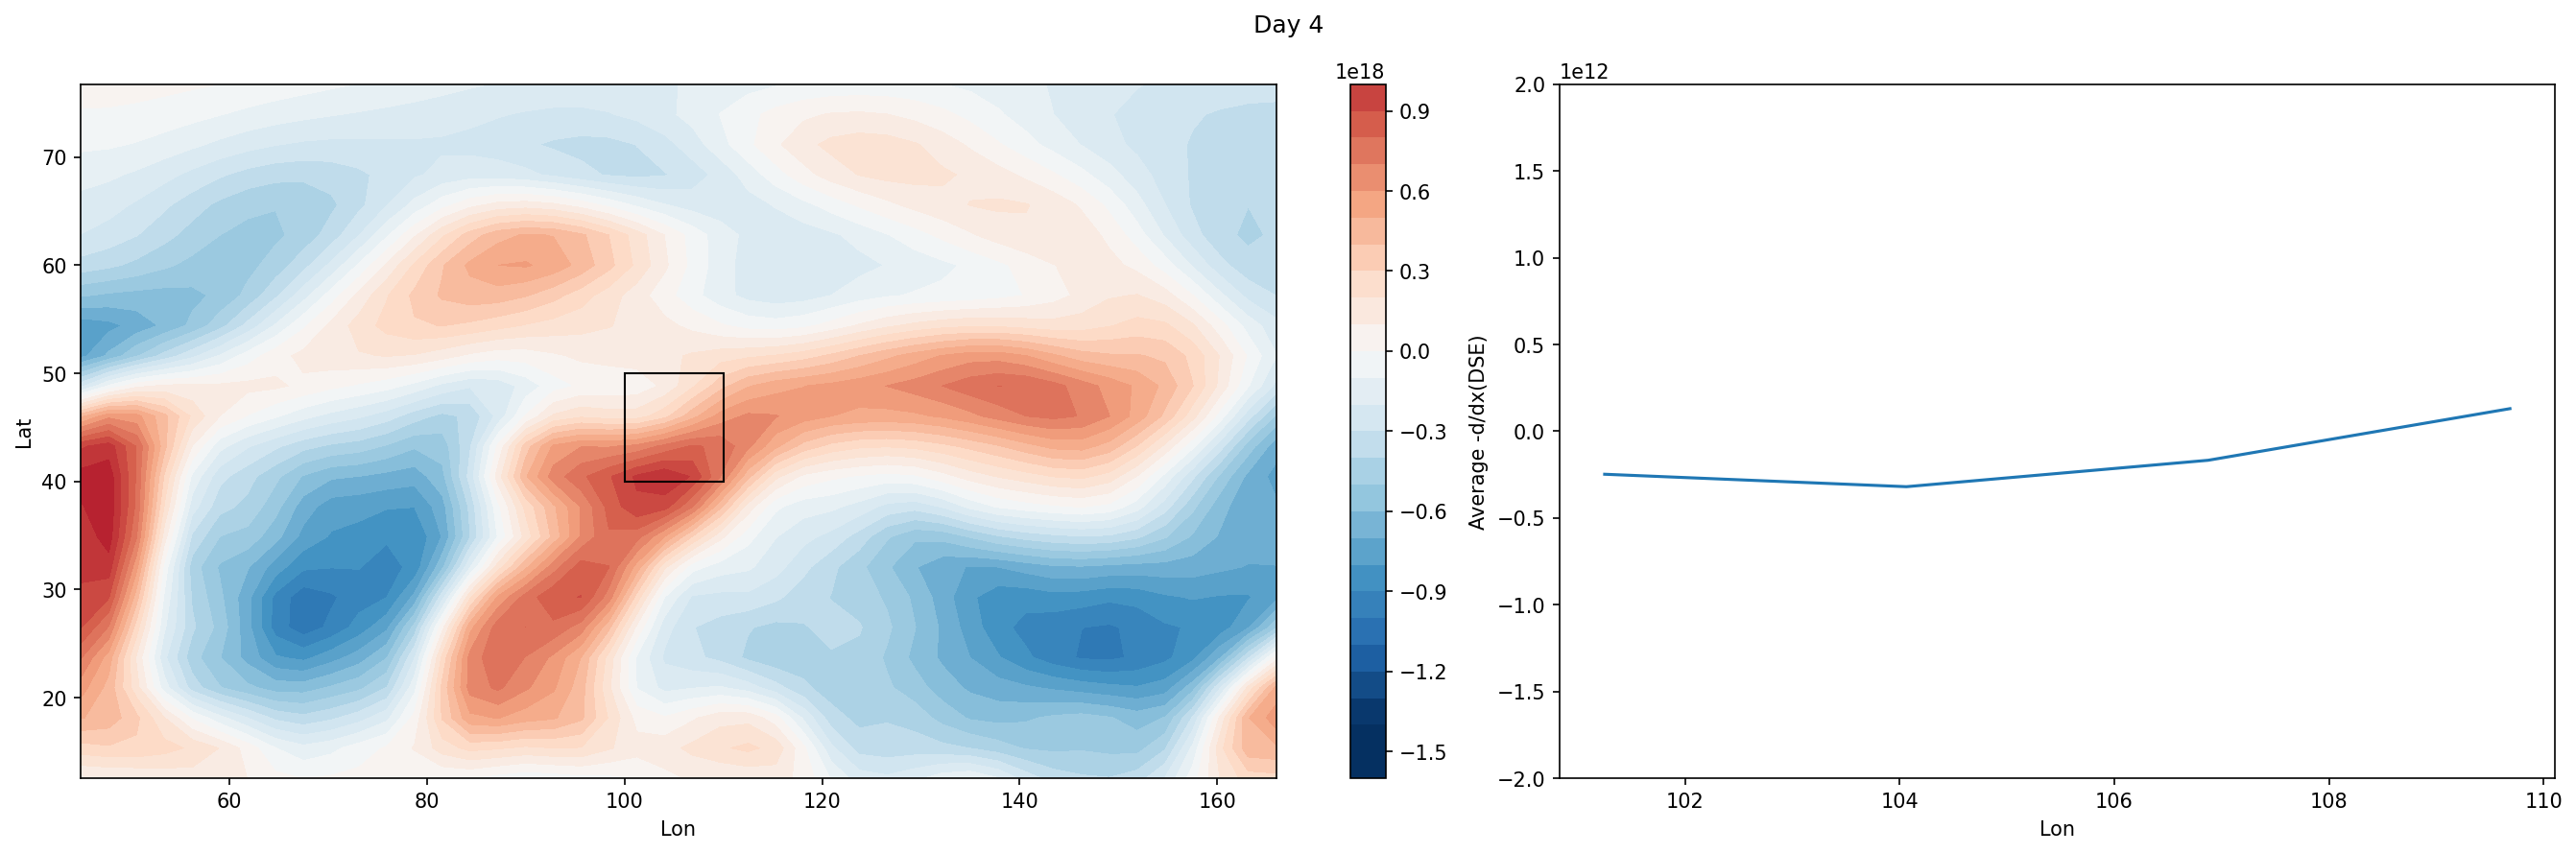

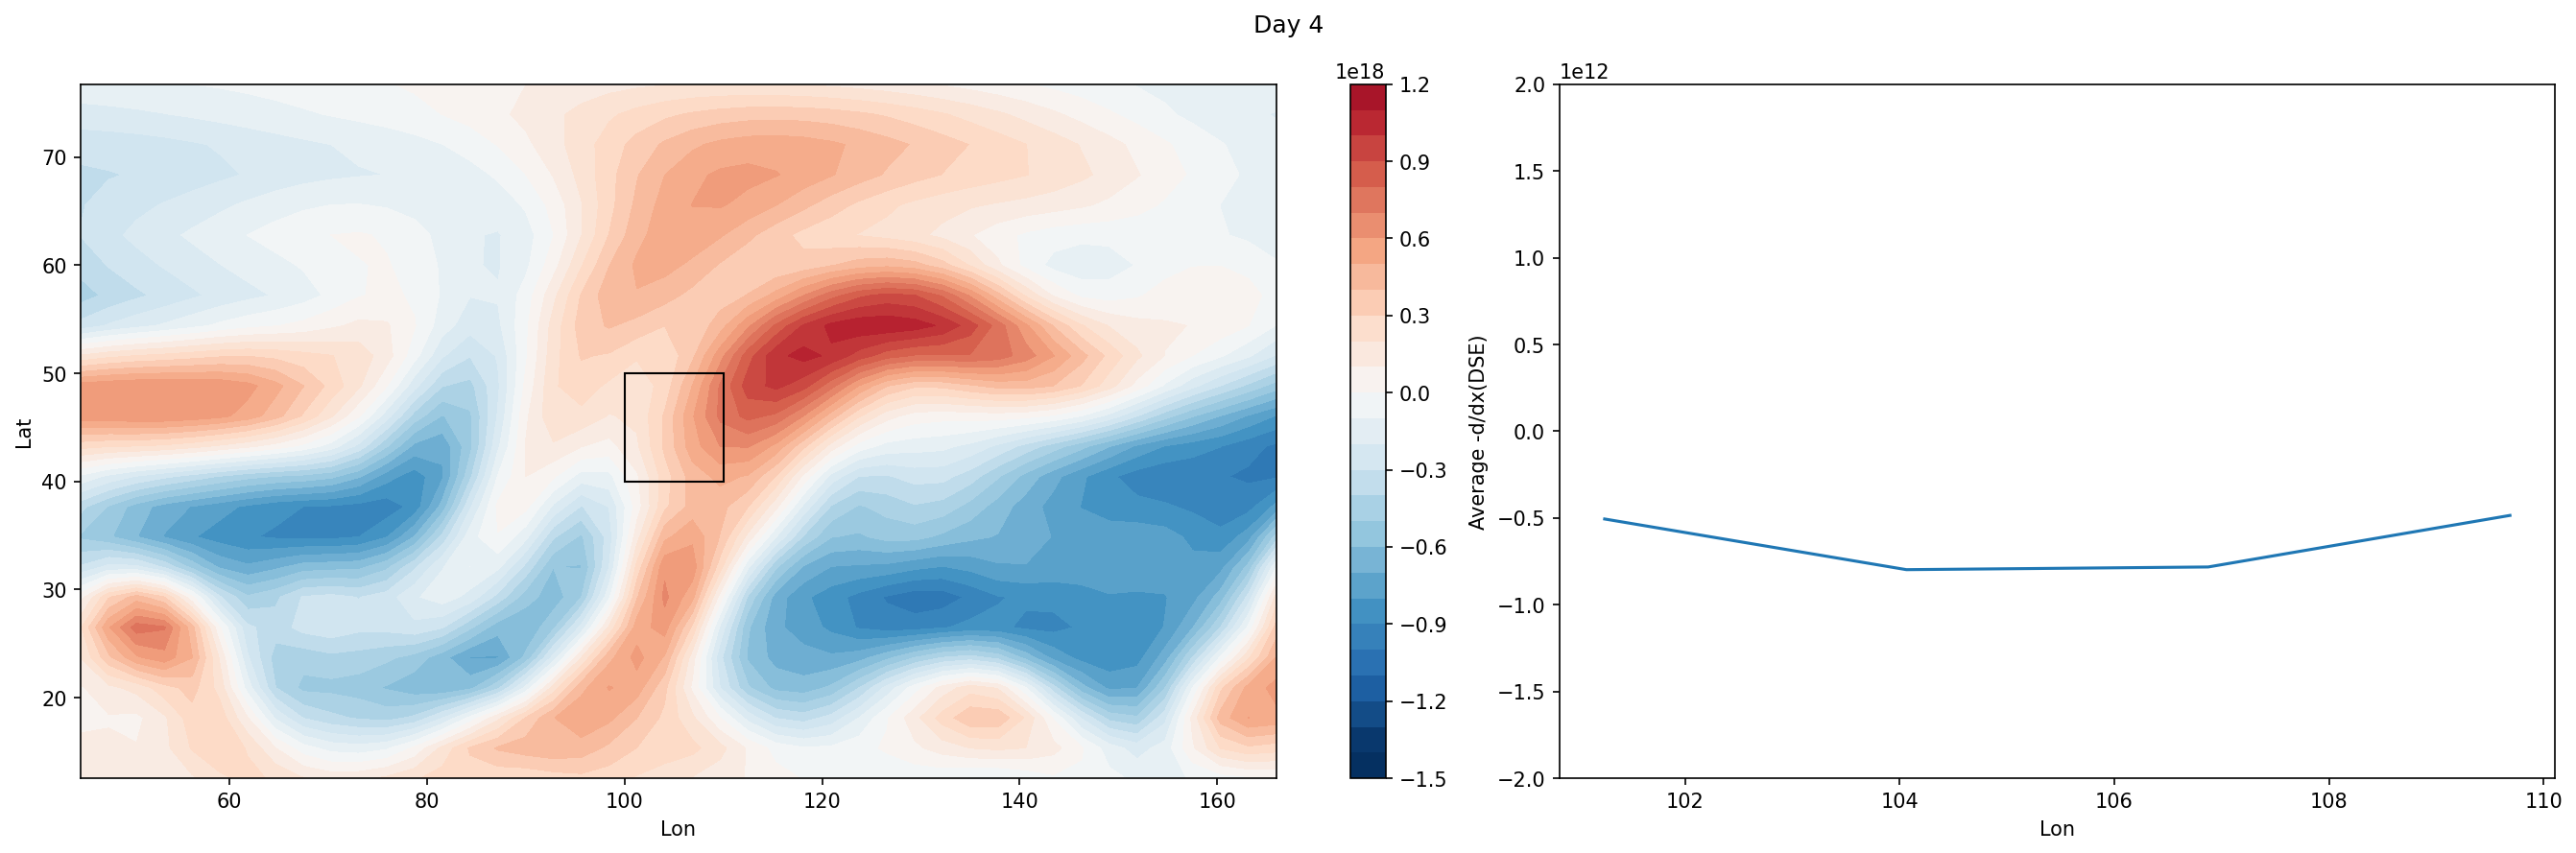

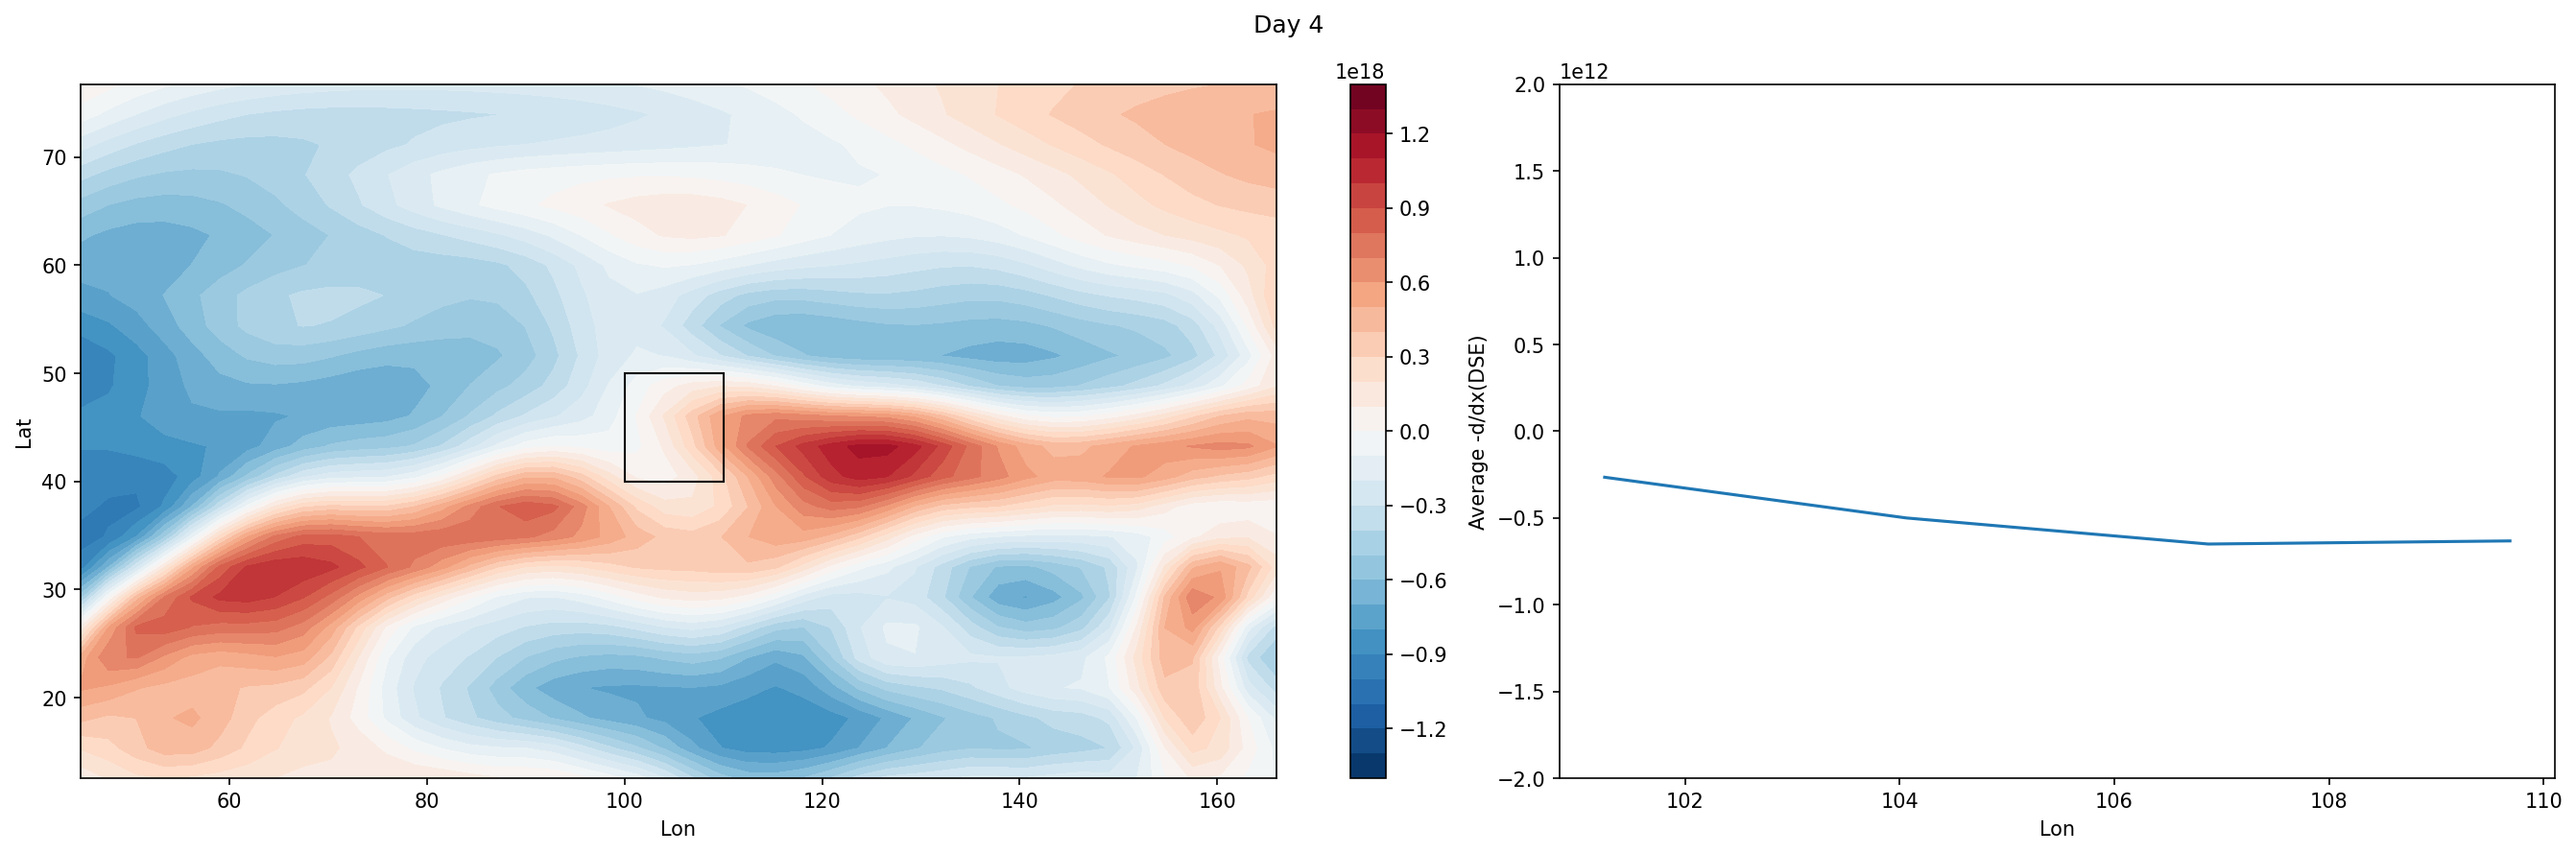

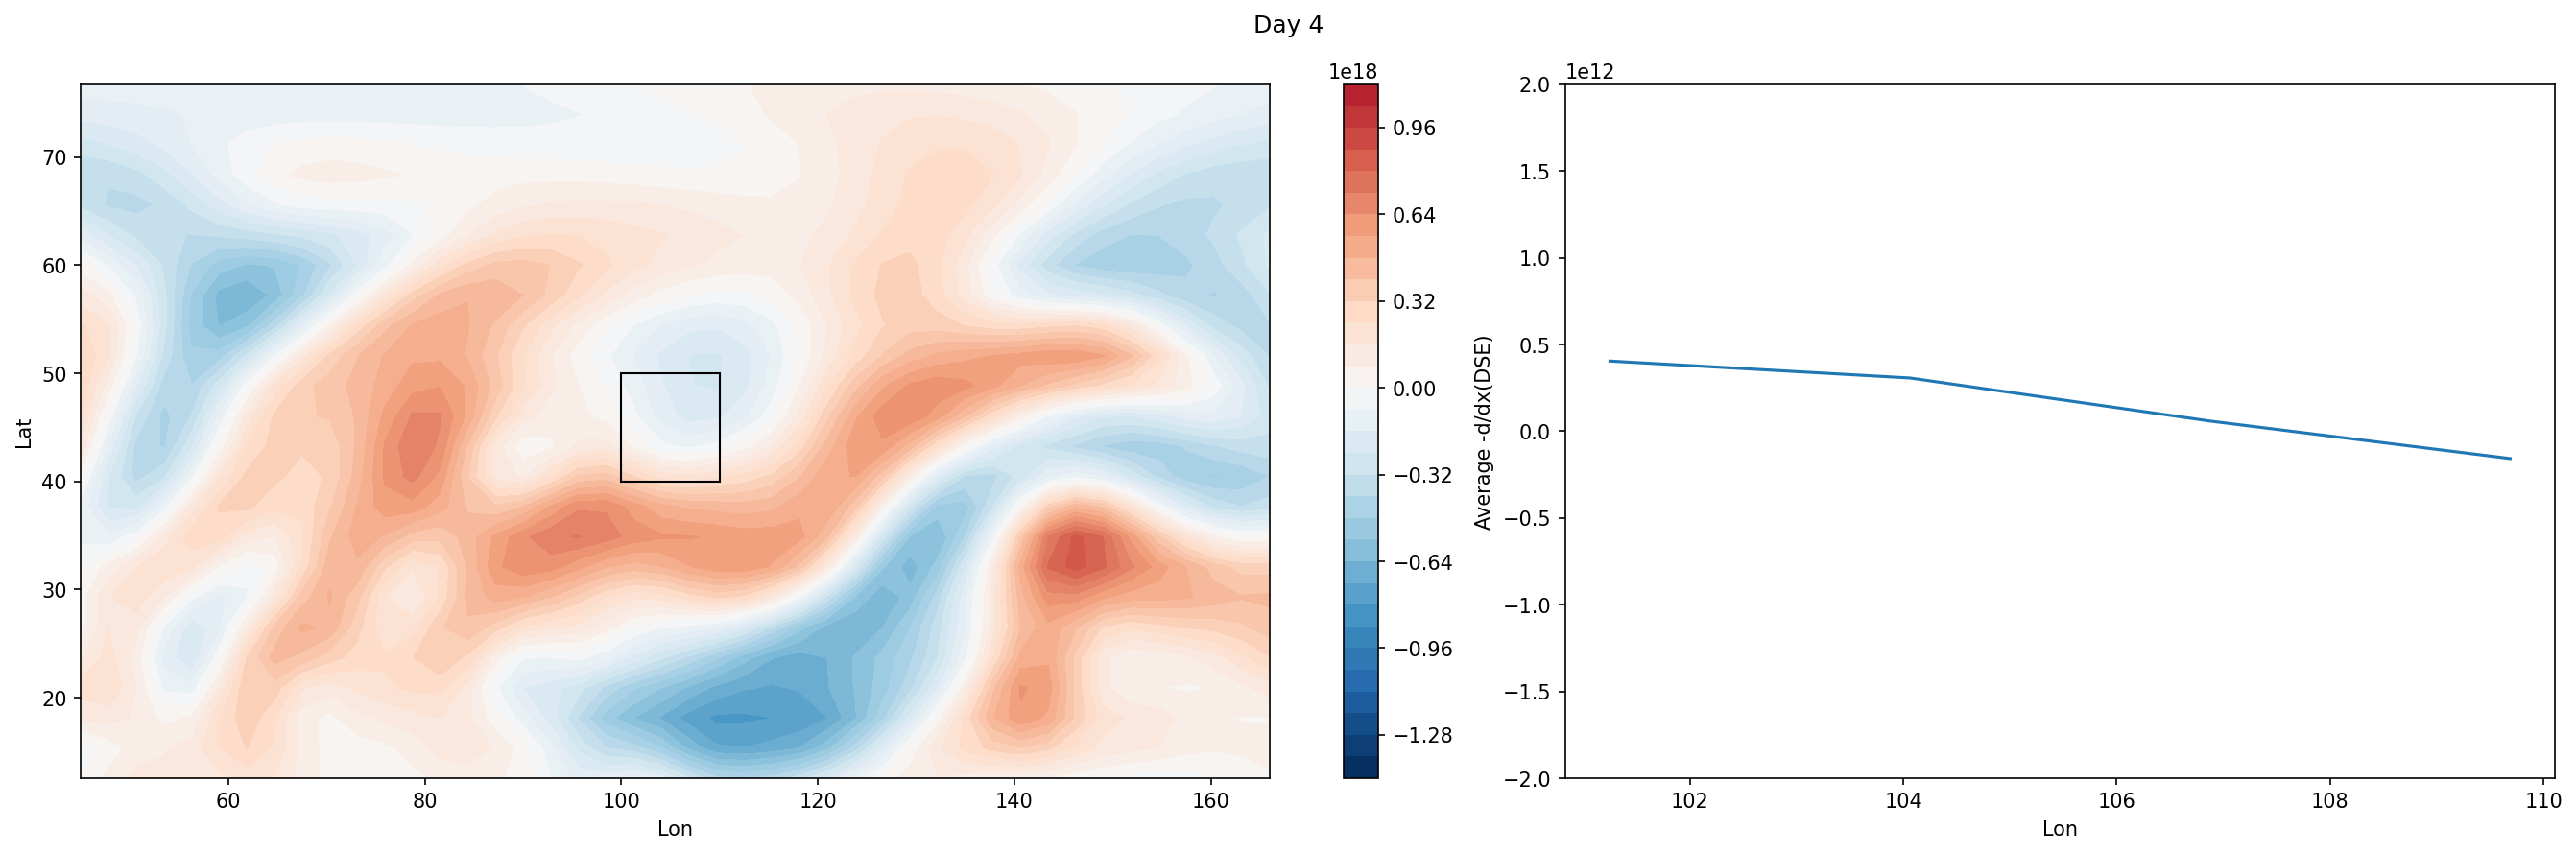

In [5]:
########################################### animation ###########################################################

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

writer = animation.writers['ffmpeg']
writer = writer(fps=1, bitrate=900)

# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexmodk', 'rb') as f:
    heat_index= pickle.load(f)

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=3
lat2=29
lon1=15
lon2=61

# lat1=13
# lat2=19
# lon1=35
# lon2=41

lat1s=13
lat2s=19
lon1s=35
lon2s=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.7 ,0.2)[::-1]*10000
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

temp_clim=interpol1d(temp_clim, press_clim)
press_int=np.insert(p_std, 0, 101300)      
dp=(press_int[:-1]-press_int[1:])

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)

dse_clim=Cp*temp_clim+g*z

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

cut=np.sort(dur_list)[4]
print(cut)

convergencehx=[]
convergencehy=[]
convergencev=[]
CONVhx=[]
CONVhy=[]
CONVv=[]

test=0

for e in heat_index:
    
    if (dur_list[test]<=cut):
    
#     #     if test==10:
#     #         break

#         test=test+1

        print(test)

        i=e[0]
        j=int(e[1])
    #     print(i,j)
        t_list=e[2]
        ignore=0

        for t in t_list:

    #         t=t_0+k
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            
            if np.min(press.values[0])<95000:
                ignore=1
                print(np.min(press.values[0]))
                continue

            temp=interpol1d(temp, press)

            press_int=np.insert(p_std, 0, 101300)       

            # dz calculation

            dp=(press_int[:-1]-press_int[1:])

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)

            dse=(Cp*temp+g*z-dse_clim)
            dse=((dse)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly)

            DSE=-(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
            
            print(dse[:6,1:-1,1:-1].sum())
            convergencehy.append(dse[:33,1:-1,1:-1])
            convergencehx.append(DSE[:33])

        if ignore==0:
    
            fig, axs = plt.subplots(1, 2, figsize=(18, 6),dpi=150, facecolor='white', gridspec_kw={'width_ratios': [1.5, 1]})
            bar_flag=0
            lim1=1.4e18
            lim2=2e12
#             lim=1e12
            def animate(i):

                rect = patches.Rectangle((100, 40), 10, 10, linewidth=1, edgecolor='black', facecolor='none')

                axs[0].clear()
                cs = axs[0].contourf(lon_deg[0,1:-1], lat_deg[1:-1,0],
                convergencehy[i][:6].sum(axis=0), levels=30, cmap='RdBu_r', robust=True, vmin=-lim1, vmax=lim1)
                global bar_flag
                if bar_flag==0:
                    fig.colorbar(cs, ax=axs[0])
                    bar_flag=1

                axs[0].set_xlabel('Lon')
                axs[0].set_ylabel('Lat')    
#                 axs[0].set_title('Day '+str(i-1))
#                 axs.axhline(20, linestyle='dashed',linewidth=0.7,color='black')
#                 axs.axhline(60, linestyle='dashed',linewidth=0.7,color='black')
                axs[0].add_patch(rect)
                
                axs[1].clear()
                lat_st=lat1s-lat1;lon_st=lon1s-lon1
                dse_grad= np.average(convergencehx[i][:6,lat_st:lat_st+4,lon_st:lon_st+4].sum(axis=0),
                                     weights=np.cos(lat_rad)[lat_st:lat_st+4, 0], axis=0)
                axs[1].plot(lon_deg[0,1+lon_st:lon_st+5], dse_grad)

                axs[1].set_xlabel('Lon')
                axs[1].set_ylabel('Average -d/dx(DSE)')
                axs[1].set_ylim((-lim2,lim2))
                
                fig.suptitle('Day '+str(i-1))

                fig.tight_layout()

            ani = animation.FuncAnimation(fig, animate, len(convergencehy), blit=False)

            ani.save('/home/data/lab_abel/Paper1/short'+str(test)+'.gif', writer=writer, dpi=150)
            
        
        convergencehx=[]
        convergencehy=[]
    test=test+1

# with gzip.open('/home/scratch/Abel_data/dse3d_Lintk', 'wb') as f:
#     pickle.dump([CONVhy, CONVhx], f)